# **데스크탑 PC CPU, GPU 성능 변화와 게임 사양의 변화**

# **주제 선정**



시대가 지남에 따라 가정내 PC 보급률이 크게 증가하였고, 하드웨어 제조 기술 역시 지속적으로 발전하면서 다양한 업무와 활동을 수행할 수 있게 되었다.
PC 게임 또한 이러한 하드웨어 성능 향상에 맞춰 그래픽, 물리 엔진, 연산 요구량이 증가하며 더 높은 수준의 성능을 요구하는 방향으로 발전해 왔다.

그러나 PC 구매를 고려하는 일반 사용자들은 자신의 사용 목적에 비해 과도하게 높은 성능의 부품을 선택하거나, 반대로 기존 또는 최신 게임을 원활하게 실행할 수 있을지 판단하지 못해 여려움을 겪는 경우가 많다. 실제로 인터넷 커뮤니티에서도 "이 게임이 내 PC에서 잘 돌아갈까?" 또는 "이 게임이 내 PC에서 잘 돌아갈까?"와 같은 질문이 빈번하게 제기된다.

이에 본 프로젝트는 시대별 CPU 및 GPU 성능 향상을 점수화하여 분석하고, 동시에 주요 게임들의 요구 사양 변화를 비교함으로써 앞으로 출시될 게임을 원활하게 즐기기 위해 필요한 적정 성능 수준이 무엇인지를 도출하고자한다. 이를 통해 향후 PC 구매나 업그래이드를 고려하는 사용자에게 합리적인 선택 기준을 제시하는 것을 목표로한다.

# **데이터 수집 방법**

**CPU / GPU 목록 및 성능 데이터**

*   CPU 성능 데이터는 PassMark의 공식 밴치마크 사이트에서 제공하는 싱글 코어 점수와 멀티 코어 점수를 수집
*   GPU 성능 데이터는 동일한 PassMark 사이트의 3DMark 기반 점수를 이용
*   CPU 및 GPU 모델 목록, 출시 연도, 제품군 정보 등 기본 사양 정보는 Wikipediada의 관련 문서를 통해 수집
*   모든 데이터는 웹 스크레이핑 방식으로 자동  수집하였으며, 분석을 위해 CSV 형태로 정리하여 저장


# **0. 라이브러리 설치 및 폴더 생성, 폰트 설치**

본 프로젝트에서는 CPU와 GPU 성능 데이터와 출시 정보를 웹에서 자동으로 수집하기 위해 다음과 같은 라이브러리를 사용하였다.

*   **requests**: 웹 페이지의 HTML 문서를 요청하고 받아오기 위한 라이브러리
*   **pandas**: 수집한 데이터를 테이블 형태로 변환하고 전처리하여, 최종적으로 CSV파일로 저장하기 위한 라이브러리
*   **time**: 웹 스크레이핑 과정에서 사이트 요청 빈도를 조절하기 위한 라이브러리
*   **re**: HTML 문서 내 텍스트에서 특정 패턴(숫자 점수, 모델명 등)을 추출하기 위한 라이브러리
*   **BeautifulSoup**: 웹 페이지 HTML 구조를 파싱하여 필요한 요소를 손쉽게 추출하기 위한 라이브러리
*   **StringIO**: 문자열 데이터를 파일 객체처럼 다루기 위한 라이브러리





In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import os

!apt-get -qq -y install fonts-nanum > /dev/null
#fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

# 단계 2: 런타임 재시작
os.kill(os.getpid(), 9)

In [1]:
from IPython.lib.display import exists
import pandas as pd
import requests
import time
import csv
import re
import os

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import urllib.request
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from bs4 import BeautifulSoup
from io import StringIO

os.makedirs("original_source", exist_ok = True)
# os.makedirs("HTMLS", exist_ok = True)
os.makedirs("first_fixed", exist_ok = True)
os.makedirs("second_fixed", exist_ok = True)
os.makedirs("duplicate", exist_ok = True)
os.makedirs("desktop", exist_ok = True)
os.makedirs("merged", exist_ok = True)
os.makedirs("cleaned", exist_ok = True)

# **1. CPU / GPU 데이터 수집 및 정제 프로세스**

**1.1 CPU / GPU 데이터 수집(웹 스크레이핑)**

아래 코드는 Wikipedia에 분산되어 있는 CPU·GPU 목록 페이지들에서 모델명, 출시일, 가격(MSRP)을 자동으로 추출하여 하나의 정제된 데이터셋으로 통합하는 웹 스크레이핑 코드이다.

먼저 URLS 딕셔너리에 인텔·AMD CPU와 NVIDA·AMD GPU의 주요 세대별 위키 페이지 URL을 하드웨어 종류(CPU / GPU)별로 분류해 저장한다. 이후 scrape_wiki_split_structure() 함수가 이 URL 목록을 순회하면서 각 페이지의 HTML을 가져오고, pandas.read_html()을 이용해 Model / Processor / Date / Launch / Release와 같은 키워드를 포함한 테이블만 골라 DataFrame으로 변환한다.

테이블 구조는 페이지마다 헤더 행 수나 컬럼 이름이 제각각이기 떄문에, 함수 내부에서 다음과 같은 구조 적응형 로직을 사용한다.

*   clean_text(), clean_price() 보조 함수를 통해 모델명에 포함된 각주 [1] 등을 제거하고, 가격 컬럼에서 $ 399 / 399 등 다양한 표기 형식을 일관된 달러 문자열로 정규화 한다.

*   MultiIdex 형태의 헤더는 문자열로 편탄화한 뒤, 소문자로 변환하여 공통된 키워드를 기준으로 출시일 컬럼(release / launch / date)과 가격 컬럼(price / msrp / usd)의 인덱스를 탐색한다.

*   첫 번째 컬럼의 값은 Ryzen / core / GeForce / Radeon 등의 브랜드명 패턴을 많이 포함하는지 검사해, 0번 컬럼을 "브랜드", 1번 컬럼을 "모델"로 사용하는 경우와 컬럼 헤더에 model / processor / sku / name이 포함된 컬럼을 직접
"모델"컬럼으로 사용하는 경우를 자동으로 구분한다.

*   브랜드 컬럼이 있는 경우에는 병합된 셀(rowspan)로 인해 비어 있는 행을 ffill()로 채워 넣어, "브랜드 + 모델명" 형태로 최종 모델명을 구성한다.

*   출시일은 각 행의 날짜 문자열에서 YYYY-MM-DD, March 12, 2025, Jan 2025, Q3 2024 등 여러 패턴을 정규표현식으로 인식하여 가능한 한 연-월-일 수준까지 정제된 문자열로 변환한다.

*   페이지 이름과 모델명에 포함된 키워드를 기반으로 Intel / AMD / NVIDIA 벤더 프리픽스를 자동으로 붙이고, 모델명이 너무 짧거나 헤더 행으로 보이는 경우는 필터링하여 노이즈를 제거한다.

이렇게 수집된 모든 행은 Type(CPU/GPU), Model, Release Date, MSRP, Source 컬럼으로 구성된 리스트로 누적되며, 마지막에 중복 모델을 제거한 뒤 DataFrame으로 변환된다. 최종적으로 CPU와 GPu 데이터를 각각 분리하여 CSV 파일로 저장함으로써, 이후 분석 단계에서 바로 사용할 수 있는 정제된 하드웨어 연도·가격 데이터셋을 자동으로 생성한다.

In [ ]:
# --- 1. URL 리스트 ---
URLS = {
    "CPU": [
        "https://en.wikipedia.org/wiki/List_of_Intel_Core_processors",
        "https://en.wikipedia.org/wiki/Skylake_(microarchitecture)",
        "https://en.wikipedia.org/wiki/Kaby_Lake",
        "https://en.wikipedia.org/wiki/Coffee_Lake",
        "https://en.wikipedia.org/wiki/Comet_Lake",
        "https://en.wikipedia.org/wiki/Ice_Lake_(microprocessor)",
        "https://en.wikipedia.org/wiki/Rocket_Lake",
        "https://en.wikipedia.org/wiki/Tiger_Lake",
        "https://en.wikipedia.org/wiki/Alder_Lake",
        "https://en.wikipedia.org/wiki/Raptor_Lake",
        "https://en.wikipedia.org/wiki/Meteor_Lake",
        "https://en.wikipedia.org/wiki/Lunar_Lake",
        "https://en.wikipedia.org/wiki/Arrow_Lake_(microprocessor)",
        "https://en.wikipedia.org/wiki/Panther_Lake_(microprocessor)",
        # AMD
        "https://en.wikipedia.org/wiki/List_of_AMD_Ryzen_processors",
        "https://en.wikipedia.org/wiki/Zen_(first_generation_microarchitecture)",
        "https://en.wikipedia.org/wiki/Zen%2B",
        "https://en.wikipedia.org/wiki/Zen_2",
        "https://en.wikipedia.org/wiki/Zen_3",
        "https://en.wikipedia.org/wiki/Zen_4",
        "https://en.wikipedia.org/wiki/Zen_5",
        "https://en.wikipedia.org/wiki/Ryzen_Threadripper"
    ],
    "GPU": [
        "https://en.wikipedia.org/wiki/List_of_Nvidia_graphics_processing_units",
        "https://en.wikipedia.org/wiki/GeForce_50_series",
        "https://en.wikipedia.org/wiki/GeForce_40_series",
        "https://en.wikipedia.org/wiki/GeForce_30_series",
        "https://en.wikipedia.org/wiki/GeForce_20_series",
        "https://en.wikipedia.org/wiki/GeForce_16_series",
        "https://en.wikipedia.org/wiki/GeForce_10_series",
        "https://en.wikipedia.org/wiki/GeForce_900_series",
        "https://en.wikipedia.org/wiki/GeForce_800_series",
        "https://en.wikipedia.org/wiki/GeForce_700_series",
        "https://en.wikipedia.org/wiki/GeForce_600_series",
        "https://en.wikipedia.org/wiki/GeForce_500_series",
        "https://en.wikipedia.org/wiki/List_of_AMD_graphics_processing_units",
        "https://en.wikipedia.org/wiki/Radeon_RX_7000_series",
        "https://en.wikipedia.org/wiki/Radeon_RX_6000_series",
        "https://en.wikipedia.org/wiki/Radeon_RX_5000_series"
    ]
}

# --- 2. 도구 함수 ---
def clean_text(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'\[.*?\]', '', text)
    text = text.replace('\xa0', ' ')
    return text.strip()

def clean_price(text):
    if not isinstance(text, str): return "N/A"
    text = re.sub(r'\[.*?\]', '', text)
    match = re.search(r'\$\s?[\d,]+', text)
    if match: return match.group(0).replace(" ", "")
    clean_num = text.replace(",", "").strip()
    if clean_num.isdigit() and 2 < len(clean_num) < 6: return f"${clean_num}"
    return "N/A"

# =========================================================
# [PART A] CPU 파서 (Zen 5 및 최신 AMD 표 대응 특수 파서 추가)
# =========================================================
def parse_ryzen_wikitable(html_text):
    """
    Ryzen 9000번대(Zen 5)처럼 rowspan이 복잡하게 얽힌 위키 테이블을 파싱합니다.
    """
    soup = BeautifulSoup(html_text, 'html.parser')
    tables = soup.find_all('table', class_='wikitable')
    parsed_data = []

    for table in tables:
        # 헤더 확인: "Model"이나 "Branding"이 있는지 확인
        headers = [th.get_text(strip=True).lower() for th in table.find_all('th')]
        if not any(k in "".join(headers) for k in ['model', 'branding', 'date']):
            continue

        # 행(Rows) 가져오기
        rows = table.find_all('tr')
        if len(rows) < 2: continue

        # 현재 상태를 추적하기 위한 변수들 (rowspan 처리용)
        current_brand = ""

        # 데이터 행 순회 (헤더 제외)
        # 보통 헤더가 1~2줄이므로 데이터가 시작되는 행을 찾아야 함
        start_row_idx = 0
        for i, row in enumerate(rows):
            # 숫자로 시작하는 모델명이 있거나, Ryzen 문자열이 있는 행부터 데이터로 간주
            text = row.get_text()
            if re.search(r'\d{4}[A-Z]*', text) or "Ryzen" in text:
                start_row_idx = i
                break

        if start_row_idx == 0: start_row_idx = 2 # 못 찾으면 대충 2번째부터

        for row in rows[start_row_idx:]:
            cells = row.find_all(['th', 'td'])
            if not cells: continue

            # 셀 텍스트 추출 및 정리
            cell_texts = []
            for cell in cells:
                # 숨겨진 텍스트 제거 (visibility:hidden)
                for hidden in cell.find_all(style=re.compile(r"visibility:hidden")):
                    hidden.decompose()

                txt = clean_text(cell.get_text())
                cell_texts.append(txt)

            # --- 데이터 매핑 로직 ---
            model_name = ""
            release_date = "N/A"
            msrp = "N/A"

            # 모델명 찾기 (패턴: 숫자 4개 + 알파벳, 예: 9950X, 9900X3D)
            # 또는 'Ryzen'이 있는 셀이 브랜드일 수 있음

            # rowspan 때문에 브랜드가 첫 번째 셀에 있을 수도, 없을 수도 있음
            # 셀들 중에서 모델명 패턴을 찾음
            for txt in cell_texts:
                if re.search(r'^\d{4}[A-Z,0-9]*$', txt): # 9950X, 9900X3D 등
                    model_name = txt
                elif "Ryzen" in txt:
                    current_brand = txt # 브랜드 갱신 (rowspan이어도 여기서 잡힘)

            # 모델명을 못 찾았으면 패스
            if not model_name: continue

            # 브랜드 결합
            if current_brand and current_brand not in model_name:
                # 이미 Ryzen이 붙어있는지 확인
                if "Ryzen" not in model_name:
                    final_name = f"AMD {current_brand} {model_name}"
                else:
                    final_name = f"AMD {model_name}"
            else:
                final_name = f"AMD {model_name}"

            # 날짜와 가격 찾기 (보통 뒤쪽에 위치)
            # 뒤에서부터 검사
            if len(cell_texts) >= 2:
                # 마지막 셀은 보통 가격
                price_candidate = cell_texts[-1]
                if "$" in price_candidate or "TBA" in price_candidate or "¥" in price_candidate:
                    msrp = clean_price(price_candidate)

                # 끝에서 두번째나 세번째가 날짜
                for cand in cell_texts[-3:]:
                    if re.search(r'\d{4}', cand) and (re.search(r'[A-Za-z]{3}', cand) or "-" in cand):
                        release_date = cand
                        break

            # 데이터 저장
            parsed_data.append({
                "Model": final_name,
                "Release Date": release_date,
                "MSRP": msrp
            })

    return parsed_data

def scrape_cpu_final(urls):
    all_data = []
    headers_ua = {"User-Agent": "Mozilla/5.0"}
    hw_type = "CPU"

    print(f"\n===== [ CPU ] 수집 시작 =====")

    for url in urls:
        page_name = url.split('/')[-1]
        try:
            r = requests.get(url, headers=headers_ua, timeout=10)
        except: continue

        page_data = []

        # [전략 1] Zen_5 등 최신 AMD 페이지는 '특수 파서' 우선 시도
        if "Zen_5" in page_name or "Ryzen" in page_name:
            # 특수 파서로 시도
            page_data = parse_ryzen_wikitable(r.text)
            if page_data:
                print(f"   -> {page_name}: {len(page_data)}개 추출 (Special Parser)")

        # [전략 2] 특수 파서가 데이터를 못 찾았거나, 다른 페이지면 기존 로직(pd.read_html) 사용
        if not page_data:
            try:
                dfs = pd.read_html(StringIO(r.text), match=r"Model|Processor|Date|Launch|Release")
                for df in dfs:
                    # 헤더 정리 및 컬럼 찾기 (기존 로직 유지)
                    if isinstance(df.columns, pd.MultiIndex):
                        df.columns = [' '.join(map(str, col)).strip() for col in df.columns]
                    df.columns = [str(c).lower() for c in df.columns]

                    date_col_idx = -1
                    price_col_idx = -1
                    for idx, col in enumerate(df.columns):
                        if any(k in col for k in ['release', 'launch', 'date', 'avail']): date_col_idx = idx
                        if any(k in col for k in ['price', 'msrp', 'usd']): price_col_idx = idx

                    if date_col_idx == -1: continue

                    brand_col_idx = -1
                    model_col_idx = -1
                    if len(df.columns) > 0:
                        col_0 = df.iloc[:, 0].astype(str).str.lower()
                        if col_0.str.contains(r"ryzen|core|atom|xeon").sum() > 0:
                            brand_col_idx = 0; model_col_idx = 1
                        else:
                            for idx, col in enumerate(df.columns):
                                if any(k in col for k in ['model', 'processor', 'sku']) and 'branding' not in col:
                                    model_col_idx = idx; break

                    if model_col_idx == -1: continue
                    if brand_col_idx != -1: df.iloc[:, brand_col_idx] = df.iloc[:, brand_col_idx].replace('nan', pd.NA).ffill()

                    for _, row in df.iterrows():
                        try:
                            raw_model = str(row.iloc[model_col_idx])
                            final_name = clean_text(raw_model)

                            if brand_col_idx != -1:
                                raw_brand = clean_text(str(row.iloc[brand_col_idx]))
                                if len(raw_brand) > 2 and raw_brand.lower() not in final_name.lower():
                                    final_name = f"{raw_brand} {final_name}"

                            # 브랜드명 보정
                            vendor = "Intel" if "intel" in page_name.lower() or "core" in final_name.lower() else "AMD"
                            if vendor == "AMD" and "ryzen" not in final_name.lower(): vendor = "AMD Ryzen"
                            if vendor not in final_name: final_name = f"{vendor} {final_name}"

                            raw_date = str(row.iloc[date_col_idx])
                            clean_date = "N/A"
                            if len(raw_date) > 5: clean_date = clean_text(raw_date)

                            final_price = "N/A"
                            if price_col_idx != -1: final_price = clean_price(str(row.iloc[price_col_idx]))

                            if len(final_name) < 4 or "model" in final_name.lower(): continue
                            page_data.append({"Model": final_name, "Release Date": clean_date, "MSRP": final_price})
                        except: continue
                if page_data: print(f"   -> {page_name}: {len(page_data)}개 추출 (Standard)")
            except: pass

        for item in page_data:
            item["Type"] = hw_type; item["Source"] = page_name
            all_data.append(item)

    return pd.DataFrame(all_data).drop_duplicates(subset=['Model'], keep='last') if all_data else pd.DataFrame()


# =======================================================
# [PART B] GPU 파서 (기존 특수 파서 유지)
# =======================================================
def parse_gpu_transposed(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    tables = soup.find_all('table', class_='wikitable')
    parsed_data = []
    for table in tables:
        rows = table.find_all('tr')
        if not rows: continue
        header_cells = rows[0].find_all(['th', 'td'])
        if not header_cells: continue
        models = []
        start_idx = 0
        if "GeForce" in header_cells[0].get_text() or "Model" in header_cells[0].get_text() or header_cells[0].has_attr("colspan"):
            start_idx = 1
        for cell in header_cells[start_idx:]:
            text = clean_text(cell.get_text())
            if text and len(text) < 50: models.append(text)
        if not models: continue
        data_map = {m: {} for m in models}
        for row in rows[1:]:
            cells = row.find_all(['th', 'td'])
            if not cells: continue
            current_ths = [c for c in cells if c.name == 'th']
            if not current_ths: continue
            label = " ".join([clean_text(th.get_text()) for th in current_ths]).lower()
            col_idx = len(current_ths)
            target_key = None
            if any(k in label for k in ['release', 'launch', 'date']): target_key = "Release Date"
            elif any(k in label for k in ['price', 'msrp', 'usd']): target_key = "MSRP"
            if not target_key: continue
            model_cursor = 0
            for v_cell in cells[col_idx:]:
                val = clean_text(v_cell.get_text())
                try: span = int(v_cell.get('colspan', 1))
                except: span = 1
                for _ in range(span):
                    if model_cursor < len(models):
                        data_map[models[model_cursor]][target_key] = val
                        model_cursor += 1
        for model, specs in data_map.items():
            if specs: parsed_data.append({"Model": model, "Release Date": specs.get("Release Date", "N/A"), "MSRP": specs.get("MSRP", "N/A")})
    return parsed_data

def scrape_gpu_hybrid(urls):
    all_data = []
    headers_ua = {"User-Agent": "Mozilla/5.0"}
    hw_type = "GPU"
    print(f"\n===== [ GPU ] 수집 시작 =====")
    for url in urls:
        page_name = url.split('/')[-1]
        try: r = requests.get(url, headers=headers_ua, timeout=15)
        except: continue
        page_data = []
        if "GeForce" in page_name and "series" in page_name: page_data = parse_gpu_transposed(r.text)
        if not page_data:
            try:
                dfs = pd.read_html(StringIO(r.text))
                for df in dfs:
                    if isinstance(df.columns, pd.MultiIndex): df.columns = [' '.join(map(str, col)).strip() for col in df.columns]
                    df.columns = [str(c).lower() for c in df.columns]
                    date_idx = next((i for i, c in enumerate(df.columns) if any(k in c for k in ['release', 'launch', 'date'])), -1)
                    model_idx = next((i for i, c in enumerate(df.columns) if any(k in c for k in ['model', 'name']) and 'branding' not in c), -1)
                    price_idx = next((i for i, c in enumerate(df.columns) if any(k in c for k in ['price', 'msrp', 'usd'])), -1)
                    if date_idx == -1 or model_idx == -1: continue
                    brand_idx = -1
                    if model_idx != 0 and any(k in str(df.iloc[0,0]).lower() for k in ['geforce', 'radeon']):
                        brand_idx = 0
                        df.iloc[:,0] = df.iloc[:,0].replace(['nan', 'NaN'], pd.NA).ffill()
                    for _, row in df.iterrows():
                        try:
                            m_name = clean_text(str(row.iloc[model_idx]))
                            if brand_idx != -1:
                                b_name = clean_text(str(row.iloc[brand_idx]))
                                if len(b_name) > 2 and b_name.lower() not in m_name.lower(): m_name = f"{b_name} {m_name}"
                            prefix = "NVIDIA" if "nvidia" in page_name.lower() or "geforce" in m_name.lower() else ("AMD" if "amd" in page_name.lower() or "radeon" in m_name.lower() else "")
                            if prefix and prefix.lower() not in m_name.lower(): m_name = f"{prefix} {m_name}"
                            r_date = clean_text(str(row.iloc[date_idx])) if date_idx != -1 else "N/A"
                            r_price = clean_price(str(row.iloc[price_idx])) if price_idx != -1 else "N/A"
                            if len(m_name) < 3 or "model" in m_name.lower(): continue
                            page_data.append({"Model": m_name, "Release Date": r_date, "MSRP": r_price})
                        except: continue
            except: pass
        if page_data:
            print(f"   -> {page_name}: {len(page_data)}개 추출")
            for item in page_data:
                item["Type"] = hw_type; item["Source"] = page_name
                all_data.append(item)
    return pd.DataFrame(all_data).drop_duplicates(subset=['Model'], keep='last') if all_data else pd.DataFrame()

# --- 3. 실행 및 저장 ---
os.makedirs("./original_source", exist_ok=True)

df_cpu = scrape_cpu_final(URLS["CPU"])
if not df_cpu.empty:
    df_cpu.to_csv("./original_source/Wiki_CPU_List_Corrected.csv", index=False, encoding='utf-8-sig')
    print(f"\n💾 CPU 저장 완료: {len(df_cpu)}개")
    # 검증: 9950X, 9900X, 9800X3D 확인
    print("[Ryzen 9000 Check]")
    print(df_cpu[df_cpu['Model'].str.contains("9950|9900|9800", case=False)][['Model', 'Release Date', 'MSRP']])

df_gpu = scrape_gpu_hybrid(URLS["GPU"])
if not df_gpu.empty:
    df_gpu.to_csv("./original_source/Wiki_GPU_List_Corrected.csv", index=False, encoding='utf-8-sig')
    print(f"\n💾 GPU 저장 완료: {len(df_gpu)}개")
    print("[RTX 5090 Check]")
    print(df_gpu[df_gpu['Model'].str.contains("5090", case=False)][['Model', 'Release Date']])


===== [ CPU ] 수집 시작 =====
   -> List_of_Intel_Core_processors: 1274개 추출 (Standard)
   -> Skylake_(microarchitecture): 167개 추출 (Standard)
   -> Kaby_Lake: 51개 추출 (Standard)
   -> Coffee_Lake: 26개 추출 (Standard)
   -> Ice_Lake_(microprocessor): 17개 추출 (Standard)
   -> Raptor_Lake: 79개 추출 (Standard)
   -> Meteor_Lake: 22개 추출 (Standard)
   -> Lunar_Lake: 9개 추출 (Standard)
   -> Arrow_Lake_(microprocessor): 32개 추출 (Standard)
   -> List_of_AMD_Ryzen_processors: 273개 추출 (Special Parser)
   -> Zen_(first_generation_microarchitecture): 90개 추출 (Standard)
   -> Zen%2B: 43개 추출 (Standard)
   -> Zen_2: 75개 추출 (Standard)
   -> Zen_3: 112개 추출 (Standard)
   -> Zen_4: 121개 추출 (Standard)
   -> Zen_5: 49개 추출 (Special Parser)
   -> Ryzen_Threadripper: 37개 추출 (Special Parser)

💾 CPU 저장 완료: 2001개
[Ryzen 9000 Check]
                                  Model      Release Date  MSRP
279                Intel Core i9 9900KS      October 2019  $524
280                 Intel Core i9 9900K      October 2018  $488
281  

**1.2 모델명 텍스트 정규화 및 데이터 클렌징**

본 단계에서는 Wikipedia에서 수집한 CPU·GPU 원시 데이터의 Model 컬럼에서 날짜 정보가 잘못 포함된 문제를 정제 하기 위해 고급 정규표현식 기반 텍스트 전처리 과정을 수행한다.
일부 Wikipedia 테이블은 모델명 옆에 출시일, 분기 정도, ISO 날짜, 또는 기타 부가 정보가 함께 기록되어 있으며, 이 데이터가 추출 과정에서 Model 필드에 병합되면서 모델명이 훼손되는 문제가 발생한다.

이를 해결하기 위해 본 코드는 다음과 같은 절차를 수행한다.



1.2.1   remove_data_safely() 함수
  *   모델명 내부에 포함된 다양한 날짜 형식을 정규표현식 패턴으로 탐지하여 제거한다.

  *   특히 월 이름(Month 이름) 기반 패턴만 매칭하도록 하여 "2400G" 같은 숫자형 모델명을 오검출하는 문제를 방지한다.

  *   제거 대상 패턴은 (January 1, 2020) / (Jan 2020) / (Q1 2020) 같은 괄호 포함 날짜와 (January 2020) / (Jan 2020) / (Jan 1, 2020)과 같은 형식, ISO 날짜 형식(2020-01-01), 분기형식(Q1 2020)이다

  *   제거 후 잔여 문자 (), -, ,등을 추가 정리하여 모델명을 복원한다.

1.2.2   clean_data() 함수
  *   지정된 CSV 파일을 로드한 후 Model 컬럼에 날짜 제거 함수를 적용한다.

  *   정제된 결과를 원본 파일과 별도로 구분하기 위해 _SafeFixed 접미사를 붙여 저장한다.

  *   특정 모델(예: AMD Ryzen 7 5800X3D)이 정삭적으로 보존되었는지를 로그로 출력하여 데이터 정제의 안정성을 확인한다.

본 정제 과정은 하루 출시일 또는 부가 정보가 모델명에 병합되어 벤치마크 매칭 또는 분석 단계에서 혼동을 일으키는 문제를 사전에 방지하여, 이후 CPU·GPU 성능 비교, 연도별 분석, 점수 매칭 등 후속 처리의 일관성과 정확성을 보장하기 위한 핵심 단계이다.

In [ ]:
def remove_date_safely(text, enable_log = False):
    if not isinstance(text, str): return str(text)

    original = text
    cleaned = text

    # 월 이름 기반 패턴
    months = r"(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)"

    # 날짜 패턴 (월 이름이 포함된 경우만 매칭)
    patterns = [
        # (January 1, 2020) 또는 (Jan 2020) - 괄호 포함
        fr'\(\s*{months}\s+\d{{1,2}},?\s+\d{{4}}\s*\)',
        fr'\(\s*{months}\s+\d{{4}}\s*\)',

        # January 1, 2020 - 괄호 없음
        fr'{months}\s+\d{{1,2}},?\s+\d{{4}}',

        # Jan 2020
        fr'{months}\s+\d{{4}}',

        # Q1 2020 (분기)
        r'Q\d\s+\d{4}',

        # 2020-01-01 (ISO)
        r'\d{4}-\d{2}-\d{2}',
    ]

    # 패턴 적용
    for pat in patterns:
        cleaned = re.sub(pat, '', cleaned, flags=re.IGNORECASE)

    # 가격 제거
    price_patterns = [
        r'US?\s*\$\s*\d[\d,]*',     # US $169 , $1,599 등
        r'\$\s*\d[\d,]*',
        r'USD\s*\d[\d,]*',
    ]

    for pat in price_patterns:
        cleaned = re.sub(pat, '', cleaned, flags=re.IGNORECASE)

    # OEM, FB, FH, Tray 등 제거
    noise_words = [
        r'\(FB\)', r'\(FH\)', r'\(OEM\)', r'\(Rev\.?\s*\d+\)',
        r'\bOEM\b', r'\bTray\b', r'\bBOX\b', r'\bFB\b', r'\bFH\b'
    ]

    for pat in noise_words:
        cleaned = re.sub(pat, '', cleaned, flags=re.IGNORECASE)

    # 잔여물 청소
    cleaned = re.sub(r'\([^)]*\)', '', cleaned)  # 남은 괄호 제거
    cleaned = re.sub(r'[,;]+', '', cleaned)      # 쉼표/세미콜론 제거
    cleaned = re.sub(r'\s+', ' ', cleaned).strip(" -_")  # 공백정리

    # LOG 출력
    if enable_log and original != cleaned: print(f"Model 변환 '{original}' → '{cleaned}'")

    return cleaned.strip()

# CSV 파일 불러와 모델명 정제 후 재저장
def clean_data(filename, enable_log = False):
    print(f"\n파일 정제 중: {filename}")

    try:
        df = pd.read_csv(filename)

        if 'Model' in df.columns:
            # 안전한 청소 함수 적용
            df['Model'] = df['Model'].apply(lambda x: remove_date_safely(x, enable_log))

            # 저장
            new_filename = filename.replace("original_source", "first_fixed")
            new_filename = new_filename.replace(".csv", "_SafeFixed.csv")
            df.to_csv(new_filename, index=False, encoding='utf-8-sig')

            print(f"\n저장 완료: {new_filename}")

            # 확인용 출력 (Ryzen 5800X3D가 살아있는지 확인)
            sample = df[df['Model'].str.contains("5800", na=False)]
            if not sample.empty:
                print(f"[생존 확인] {sample['Model'].iloc[0]}")
            else:
                print("[샘플] ", df['Model'].head(3).values)
        else:
            print("'Model' 컬럼이 없습니다.")

    except FileNotFoundError:
        print("파일을 찾을 수 없습니다.")

# 3. 실행
clean_data("./original_source/Wiki_CPU_List_Corrected.csv", enable_log=True)
clean_data("./original_source/Wiki_GPU_List_Corrected.csv", enable_log=True)


파일 정제 중: ./original_source/Wiki_CPU_List_Corrected.csv
Model 변환 'Intel Core 2 Duo E4300 SL9TB (L2) SLA99 (M0) SLA5G' → 'Intel Core 2 Duo E4300 SL9TB SLA99 SLA5G'
Model 변환 'Intel Core 2 Duo E4400 SLA3F (L2) SLA98 (M0) SLA5F' → 'Intel Core 2 Duo E4400 SLA3F SLA98 SLA5F'
Model 변환 'Intel Core 2 Duo E4500 SLA95 (M0)' → 'Intel Core 2 Duo E4500 SLA95'
Model 변환 'Intel Core 2 Duo E4600 SLA94 (M0)' → 'Intel Core 2 Duo E4600 SLA94'
Model 변환 'Intel Core 2 Duo E4700 SLALT (G0)' → 'Intel Core 2 Duo E4700 SLALT'
Model 변환 'Intel Core 2 Duo E6300 SL9SA (B2) SL9TA (L2) SLA2L (?) SLA5E (?)' → 'Intel Core 2 Duo E6300 SL9SA SL9TA SLA2L SLA5E'
Model 변환 'Intel Core 2 Duo E6320 SLA4U (B2)' → 'Intel Core 2 Duo E6320 SLA4U'
Model 변환 'Intel Core 2 Duo E6400 SL9S9 (B2) SLA5D (?) SL9T9 (L2) SLA97 (M0)' → 'Intel Core 2 Duo E6400 SL9S9 SLA5D SL9T9 SLA97'
Model 변환 'Intel Core 2 Duo E6420 SLA4T (B2)' → 'Intel Core 2 Duo E6420 SLA4T'
Model 변환 'Intel Core 2 Duo E6600 SL9S8 (B2) SL9ZL (B2)' → 'Intel Core 2 Duo E6600 SL9

**1.3 출시일(Release Date) 데이터 정규화**

Wikipedia에서 수집된 CPU·GPU 출시일 데이터는 페이지마다 날짜 형식이 매우 다양하게 기록되어 있다.

*   March 12, 2025 (영문 긴 날짜)
*   Jan 2023 (월 + 연도)
*   Q1 2020 (분기)
*   H2 2019 (반기)
*   2020-01-01 (ISO 8601)
*   Late 2024 / Early 2021 등 모호한 표현 포함

이처럼 날짜 형식이 통일되지 않으면 연도별 성능 변화 분석, 게임 사양 비교 분석시 정렬·필터링이 불가능해지므로, 모든 출시일을 YYYY-MM-DD의 단일 포멧으로 정규화하는 절차가 필요하다.

이를 위해 본 단계에서는 아래의 기능을 수행하는 정제 코드를 구성하였다.

**1.3.1 unify_date_format() 함수**
1.   분기(Quarter) 날짜 처리
*   "Q1 2025" 또는 "1Q 2025" 같은 문자열을 탐지하여 분기별 시작 날짜로 매핑해 "2025-01-01"처럼 변환
    *   Q1 → 01월
    *   Q2 → 04월
    *   Q3 → 07월
    *   Q4 → 10월

2.   반기(Half-year) 날짜 처리
*   "H1 2025" / "H2 2025" 같은 표현을 탐지한다.
    *   H1 → "2025-01-01"
    *   H2 → "2025-07-01"

3.  일반 날짜 자동 파싱
*   Pandas가 자동 인식 가능한 날자는 pd.to_datetime()으로 변환한다.
    *   "Jan 1, 2022"
    *   "January 2024"
    *   "2024-03-15"

4.  변환이 불가능한 경우
*   명확하지 않은 날짜는 None으로 처리하여 분석 단계에서 제외할 수 있도록 한다.
    *   "Unknown"
    *   "TBD"
    *   "Late 2023"

이를 통해 모든 출시일 컬럼을 분석 가능한 단일 날짜 형식으로(YYYY-MM-DD)으로 일관성 있게 정규화한다.

**1.3.2 process_date__unification() 함수**

이 함수는 CSV 파일을 로드한 뒤 출시일 컬럼을 실제로 정규화하고, 최종 분석용 CSV 파일로 저장한다.

1.   원본 CSV 파일 로드
*   Release Date 컬럼이 존재하는지 확인 후 작업을 시작한다.
*   변환 전 상위 3개 샘플을 출력해 변환이 필요한 상태임을 확인한다.

2.   날짜 정규화 적용
*   모든 행의 날짜 문자열에 unify_date_format()을 적용하여 분기·반기·일반·날짜를 모두 "YYYY-MM-DD" 형태로 통일한다.

3.   최신 출시 순으로 정렬
*   정규화된 날짜를 기준으로 descending 정렬하여 최신 CPU / GPU가 상단에 오도록 정리한다.

4.   후처리 CSV 결과 저장
*   원본 파일 뒤에 _Final.csv를 자동으로 붙여 저장한다.
*   변환 후 상위 3개 샘플을 출력해 변환 성공 여부를 검증한다.

In [ ]:
# 날짜 형식 통일 함수
def unify_date_format(date_str):
    if not isinstance(date_str, str): return None

    date_str = date_str.strip()
    if date_str == "N/A" or date_str == "": return None

    try:
        # 분기(Quarter) 처리 (Q1 2023 -> 2023-01-01)
        # "Q1 2023" 또는 "1Q 2023" 패턴
        q_match = re.search(r'[Qq](\d)\s+(\d{4})', date_str) or re.search(r'(\d)[Qq]\s+(\d{4})', date_str)

        if q_match:
            quarter = int(q_match.group(1)) if q_match.group(1).isdigit() else int(q_match.group(2))
            year = q_match.group(2)  if q_match.group(2).isdigit() else q_match.group(1)

            # 분기별 시작 월 매핑
            month_map = {1: "01", 2: "04", 3: "07", 4: "10"}
            formatted = f"{year}-{month_map.get(quarter, '01')}-01"
            print(f"[Q → ISO] '{date_str}' → '{formatted}")
            return formatted

        # 반기(Half) 처리 (H1 2023 -> 2023-01-01)
        h_match = re.search(r'[Hh](\d)\s+(\d{4})', date_str)
        if h_match:
            half = int(h_match.group(1))
            year = h_match.group(2)
            month = "01" if half == 1 else "07"
            formatted = f"{year}-{month}-01"
            print(f"[H → ISO] '{date_str}' → '{formatted}'")
            return formatted

        # 일반적인 날짜 (Jan 1, 2023 / 2023-01-01)
        dt = pd.to_datetime(date_str, errors='coerce')

        if pd.notnull(dt):
          formatted = dt.strftime('%Y-%m-%d')
          print(f"[일반 → ISO] '{date_str}' → '{formatted}'")
          return formatted

        # 변환 실패 시 원본 반환 (혹은 None)
        print(f"[변환 실패]: '{date_str}'")
        return None

    except:
        return None

# 파일 로드 -> 변환 -> 저장
def process_date_unification(filename):
    print(f"\n날짜 통일 작업 중: {filename}")

    try:
        df = pd.read_csv(filename)

        if 'Release Date' not in df.columns:
            print("'Release Date' 컬럼이 없습니다.")
            return

        # 변환 전 샘플
        print(f"[변경 전] {df['Release Date'].dropna().head(5).values}")

        # 날짜 변환 적용
        df['Release Date'] = df['Release Date'].apply(unify_date_format)

        # 변환 후 샘플
        print("[변환 후 샘플]", df['Release Date'].dropna().head(5).values)

        # 날짜순 정렬 (최신순)
        df = df.sort_values(by='Release Date', ascending=False)

        # 저장
        new_filename = filename.replace("first_fixed", "second_fixed")
        new_filename = new_filename.replace("_Corrected_SafeFixed.csv", "_Final.csv")
        df.to_csv(new_filename, index=False, encoding='utf-8-sig')

        print(f"저장 완료: {new_filename}")

    except FileNotFoundError:
        print("파일을 찾을 수 없습니다.")

# 실행
process_date_unification("./first_fixed/Wiki_CPU_List_Corrected_SafeFixed.csv")
process_date_unification("./first_fixed/Wiki_GPU_List_Corrected_SafeFixed.csv")


날짜 통일 작업 중: ./first_fixed/Wiki_CPU_List_Corrected_SafeFixed.csv
[변경 전] ['May 2010' 'May 2010' 'September 2009' 'July 2010' 'September 2009']
[일반 → ISO] 'May 2010' → '2010-05-01'
[일반 → ISO] 'May 2010' → '2010-05-01'
[일반 → ISO] 'September 2009' → '2009-09-01'
[일반 → ISO] 'July 2010' → '2010-07-01'
[일반 → ISO] 'September 2009' → '2009-09-01'
[일반 → ISO] 'January 2010' → '2010-01-01'
[일반 → ISO] 'July 2010' → '2010-07-01'
[일반 → ISO] 'September 2009' → '2009-09-01'
[일반 → ISO] 'January 2010' → '2010-01-01'
[일반 → ISO] 'June 2009' → '2009-06-01'
[일반 → ISO] 'November 2008' → '2008-11-01'
[일반 → ISO] 'October 2009' → '2009-10-01'
[일반 → ISO] 'June 2009' → '2009-06-01'
[일반 → ISO] 'November 2008' → '2008-11-01'
[일반 → ISO] 'February 2010' → '2010-02-01'
[일반 → ISO] 'November 2008' → '2008-11-01'
[일반 → ISO] 'April 2010' → '2010-04-01'
[일반 → ISO] 'January 2010' → '2010-01-01'
[일반 → ISO] 'January 2010' → '2010-01-01'
[일반 → ISO] 'January 2010' → '2010-01-01'
[일반 → ISO] 'May 2010' → '2010-05-01'
[일반 → ISO] 'J

# **2. CPU / GPU 성능 데이터 수집**

본 단계에서는 CPU와 GPU의 실제 성능 지표를 제공하는 PassMark Benchmark 사이트에서 CPU 멀티 코어 점수, CPU 싱글코어 점수, GPU 3DMark. 점수를 자동으로 수집하여 통합된 하드웨어 성능 데이터셋을 구축한다. PassMark는 상업적 벤치마크 플랫폼으로 최신 하드웨어의 상대 성능을 비교할 수 있는 데표적인 지표를 제공하기 때문에, 게임 사양 변화 분석에 필수적인 기초 데이터로 활용된다.

아래 코드는 PassMark HTML 페이지를 분석하고 필요한 요소(모델명, 점수, 가격)를 정규화하여 DataFrame형태로 저장한 뒤 최종 CSV 파일로 출력한다.

**2.1 scrape_passmark() 함수**

scrape_passmark(url, data_type) 함수는 PassMark의 CPU / GPU 성능 페이지에서 리스트 형태로 정리된 밴치마크 데이터를 추출 후 저장한다.

2.1.1 HTML 구조 기반 정밀 스크레이핑
*   ul.chartlist > li 요소를 선택해 반복 처리하면서 다음 정보를 파싱한다.
    *   prdname: CPU 또는 GPU 모델명
    *   count: PassMark 점수 (CPU 멀티코어 / 싱글코어 / GPU 3DMark)
    *   price-new / price-neww: 제품 가격(MSRP 또는 시장 평균가)
    *   header class 요소 제외: 첫 번째 행(헤더)은 실제 데이터가 아니므로 필터링

2.1.2 data_type에 따른 분기 처리
*   data_type값에 따라 수집해야 하는 항목이 달라진다.
    *   multi_cpu는 high_end_cpus.html 페이지를 이용하여 모델명, 멀티코어, 가격을 수집한다.
    *   single_cpu는 singleThread.html 페이지를 이용하여 모델명, 싱글코어 점수를 수집한다.
    *   gpu는 high_end_gpus.html 페이지를 이용하여 모델명, 3DMark 점수, 가격을 수집한다.

싱글코어 페이지에는 가격 정보가 없는 경우가 많아 가격 파싱을 비활성화 했다.


**2.2 CPU 점수 병합**

PassMark는 CPU 멀티 / 싱글 점수를 서로 다른 페이지에서 제공하므로 아래 단계로 통합히다.
1. df_cpu_multi: 멀티코어 점수 수집
2. df_cpu_single: 멀티 코어 점수 수집
3. pd.merge(..., on = "Name", how = "outer") 사용
    *   동일한 모델명의 행을 기준으로 두 점수를 하나의 레코드로 병합
    *   어는 한쪽에만 존재하는 모델도 보존(outer_join)
4. 컬럼 순서를 Name, Multi_Score, Single_Score, Price로 정리
5. 완성된 CPU 성능 데이터를 CPU_Final_Specs.csv로 저장


**2.3 GPU 점수 저장**

CPU는 PassMark 하나의 페이지에서 모델명 / 3DMark 점수 / 가격이 모두 제공되게에 별도 병합 과정 없이 데이터를 GPU_Final_Specs.csv로 저장

**2.4 로그 기록**

어떤 URL에서 데이터를 수집하는지, 수집된 데이터 개수와 CPU 성능 데이터 병합 여부를 출력하고 CSV 파일 내에 저장된 데이터 개수와 미리보기를 출력한다.

In [ ]:
def scrape_passmark(url, data_type):
    """
    data_type: 'multi_cpu', 'single_cpu', 'gpu' 중 하나
    """
    print(f"{data_type} 데이터 수집 중... ({url})")
    headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36" }

    try:
      session = requests.Session()
      response = requests.get(url, headers=headers)
      response.raise_for_status()
      soup = BeautifulSoup(response.text, "html.parser")
      # 차트 리스트 찾기
      chart_list = soup.select("ul.chartlist > li")

      results = []
      for row in chart_list:
        if "header" in row.get("class", []): continue
        try:
          # 1. 이름
          name_tag = row.select_one(".prdname")
          if not name_tag: continue
          name = name_tag.get_text(strip=True)

          # 2. 점수
          score_tag = row.select_one(".count")
          score = score_tag.get_text(strip=True).replace(",", "") if score_tag else "0"

          # 3. 가격
          price = "N/A"
          # 가격은 'single_cpu' 페이지에는 보통 없거나 중복되므로
          # 'multi_cpu'와 'gpu' 수집 때만 거의 사용된다.
          if data_type in ['multi_cpu', 'gpu']:
            price_tag = row.select_one(".price-neww") or row.select_one(".price-new") or row.select_one(".price")
            if price_tag:
              raw_price = price_tag.get_text(strip=True).replace("*", "").replace("NA", "").strip()
              if "$" in raw_price or any(c.isdigit() for c in raw_price): price = raw_price
              # 데이터 저장 구조 분기
              if data_type == 'multi_cpu': results.append({"Name": name, "Multi_Score": int(score), "Price": price})
              elif data_type == 'single_cpu': results.append({"Name": name, "Single_Score": int(score)})
              elif data_type == 'gpu': results.append({"Name": name, "G3D_Score": int(score), "Price": price})
        except: continue

        print(f"{len(results)}개 데이터 확보 완료.\n")
        return pd.DataFrame(results)

    except Exception as e:
      print(f"오류 발생: {e}")
      return pd.DataFrame()


# 실행 및 데이터 병합 (Merge)
# --- CPU 데이터 수집 (멀티 & 싱글) ---
df_cpu_multi = scrape_passmark("https://www.cpubenchmark.net/high_end_cpus.html", "multi_cpu")
df_cpu_single = scrape_passmark("https://www.cpubenchmark.net/singleThread.html", "single_cpu")

# --- CPU 데이터 합치기 (이름 기준) ---
if not df_cpu_multi.empty and not df_cpu_single.empty:
  print("\nCPU 멀티 점수와 싱글 점수를 하나로 합치는 중...")
  # 'Name' 컬럼을 기준으로 두 표를 합친다 (how='outer'는 둘 중 하나만 있어도 저장)
  df_cpu_final = pd.merge(df_cpu_multi, df_cpu_single, on="Name", how="outer")

  # 보기 좋게 컬럼 순서 정렬
  df_cpu_final = df_cpu_final[["Name", "Multi_Score", "Single_Score", "Price"]]

  # 저장
  df_cpu_final.to_csv("./original_source/CPU_Final_Specs.csv", index=False, encoding="utf-8-sig")
  print(f"[완료] CPU 통합 데이터 저장됨: CPU_Final_Specs.csv (총 {len(df_cpu_final)}개)")
  print(df_cpu_final.head())
else: print("CPU 데이터 수집 실패로 병합하지 못했습니다.")

# --- GPU 데이터 수집 ---
print("\n")
df_gpu = scrape_passmark("https://www.videocardbenchmark.net/high_end_gpus.html", "gpu")

if not df_gpu.empty:
  df_gpu.to_csv("./original_source/GPU_Final_Specs.csv", index=False, encoding="utf-8-sig")
  print(f"[완료] GPU 데이터 저장됨: GPU_Final_Specs.csv (총 {len(df_gpu)}개)")
  print(df_gpu.head())
else: print("GPU 데이터 수집 실패.")

multi_cpu 데이터 수집 중... (https://www.cpubenchmark.net/high_end_cpus.html)
1개 데이터 확보 완료.

single_cpu 데이터 수집 중... (https://www.cpubenchmark.net/singleThread.html)
0개 데이터 확보 완료.

CPU 데이터 수집 실패로 병합하지 못했습니다.


gpu 데이터 수집 중... (https://www.videocardbenchmark.net/high_end_gpus.html)
1개 데이터 확보 완료.

[완료] GPU 데이터 저장됨: GPU_Final_Specs.csv (총 1개)
                 Name  G3D_Score Price
0  GeForce RTX 5090 D      42899   N/A


아래의 코드는 위의 코드와 내용은 동일하지만, url 접속이 불가능하거나(4XX오류) 데이터를 1개 또는 불러오지 못 할경우를 대비한 코드이다.
*   `https://www.cpubenchmark.net/high_end_cpus.html`
*   `https://www.cpubenchmark.net/singleThread.html`
*   `https://www.videocardbenchmark.net/high_end_gpus.html`

위의 페이지에 접속하여 HTML을 각각 cpu_multi.html, cpu_single.html, gpu.html로 저장하였다. 이 파일을 업로드 후 아래의 코드를 실행시 정상적으로 데이터를 거져오는 것을 확인할 수 있다.

**다운로드 일자: 2025.12.06**

In [ ]:
def parse_local_html(file_path, data_type):
    """
    저장된 HTML 파일을 읽어서 파싱하는 함수
    """
    print(f"파일 읽는 중... ({file_path})")

    if not os.path.exists(file_path):
        print(f"오류: '{file_path}' 파일이 없습니다. 코랩에 파일을 업로드했는지 확인해주세요.")
        return pd.DataFrame()

    try:
        # 파일 열기 (인코딩 에러 방지를 위해 utf-8 지정)
        with open(file_path, "r", encoding="utf-8") as f:
            soup = BeautifulSoup(f, "html.parser")

        # 차트 리스트 찾기
        chart_list = soup.select("ul.chartlist > li")

        results = []
        for row in chart_list:
            if "header" in row.get("class", []): continue

            try:
                # 1. 이름
                name_tag = row.select_one(".prdname")
                if not name_tag: continue
                name = name_tag.get_text(strip=True)

                # 2. 점수
                score_tag = row.select_one(".count")
                score = score_tag.get_text(strip=True).replace(",", "") if score_tag else "0"

                # 3. 가격
                price = "N/A"
                if data_type in ['multi_cpu', 'gpu']:
                    price_tag = row.select_one(".price-neww") or row.select_one(".price-new") or row.select_one(".price")
                    if price_tag:
                        raw_price = price_tag.get_text(strip=True).replace("*", "").replace("NA", "").strip()
                        if "$" in raw_price or any(c.isdigit() for c in raw_price):
                            price = raw_price

                # 데이터 저장 구조 분기
                if data_type == 'multi_cpu':
                    results.append({"Name": name, "Multi_Score": int(score), "Price": price})
                elif data_type == 'single_cpu':
                    results.append({"Name": name, "Single_Score": int(score)})
                elif data_type == 'gpu':
                    results.append({"Name": name, "G3D_Score": int(score), "Price": price})

            except: continue

        print(f"{len(results)}개 데이터 추출 성공!\n")
        return pd.DataFrame(results)

    except Exception as e:
        print(f"처리 중 오류 발생: {e}")
        return pd.DataFrame()

# --- 실행 부분 ---

# 1. 업로드한 HTML 파일 이름 (저장할 때 이름과 똑같아야 함)
file_cpu_multi = "./HTMLS/cpu_multi.html"   # 멀티 코어 HTML 파일명
file_cpu_single = "./HTMLS/cpu_single.html" # 싱글 코어 HTML 파일명
file_gpu = "./HTMLS/gpu.html"               # GPU HTML 파일명

# 2. 데이터 추출
df_cpu_multi = parse_local_html(file_cpu_multi, "multi_cpu")
df_cpu_single = parse_local_html(file_cpu_single, "single_cpu")

# 3. CPU 병합
if not df_cpu_multi.empty and not df_cpu_single.empty:
    print("CPU 데이터 병합 중...")
    df_cpu_final = pd.merge(df_cpu_multi, df_cpu_single, on="Name", how="outer")

    # 컬럼 정리
    cols = ["Name", "Multi_Score", "Single_Score"]
    if "Price" in df_cpu_final.columns: cols.append("Price")
    df_cpu_final = df_cpu_final[cols]

    df_cpu_final.to_csv("./original_source/CPU_Specs.csv", index=False, encoding="utf-8-sig")
    print(f"[완료] CPU 데이터 저장됨: CPU_Final_Specs.csv (총 {len(df_cpu_final)}개)")
else:
    print("CPU 데이터가 부족하여 병합하지 못했습니다.")

# 4. GPU 처리
print("\n")
df_gpu = parse_local_html(file_gpu, "gpu")
if not df_gpu.empty:
    df_gpu.to_csv("./original_source/GPU_Specs.csv", index=False, encoding="utf-8-sig")
    print(f"[완료] GPU 데이터 저장됨: GPU_Final_Specs.csv (총 {len(df_gpu)}개)")

파일 읽는 중... (./HTMLS/cpu_multi.html)
1369개 데이터 추출 성공!

파일 읽는 중... (./HTMLS/cpu_single.html)
6409개 데이터 추출 성공!

CPU 데이터 병합 중...
[완료] CPU 데이터 저장됨: CPU_Final_Specs.csv (총 6430개)


파일 읽는 중... (./HTMLS/gpu.html)
742개 데이터 추출 성공!

[완료] GPU 데이터 저장됨: GPU_Final_Specs.csv (총 742개)


**2.5 CPU명 표준화**

PassMark에서 수집한 CPU 성능 데이터에는 다음과 같이 클럭 속도가 포함된 비정규화 문자열이 존재한다.
*   Intel Core i3-2100 @ 3.10GHz
*   Intel Core i7-7700K @ 4.20GHz
*   AMD Ryzen 5 3600 @ 3.60GHz

그러나 Wikipedia에서 수집한 CPU 리스트는 모델명만 포함하며, 클럭 속도 정보가 없다. 따라서 두 데이터셋을 정확히 매칭하기 위해 CPU 이름에서 클럭 속도 정보를 제거하여 통일할 필요가 있다.

2.5.1 remove_clock_speed(name) 함수
*   CPU 이름 문자열에서 @ 3.10GHz, @3.5GHz 등 클럭 속도 표기 패턴을 파악하여 제거한다
*   @ 는 클럭 속도 표기 시작을, \s* 은 공백 0~n개, \d+(\.\d+)? 는 정수 혹은 소수를 의미하며 (G|M)Hz 는 단위를 의미한다.
*   클럭 속도 부분을 문자열로 치환 후 문자열 양 끝 공백을 제거하고, 불필요한 중복 공백을 정리한다.
*   데이터 정제된 데이터를 CPU_Final_Specs_List.csv 파일로 저장한다.

In [ ]:
def remove_clock_speed(name):
    if not isinstance(name, str):
        return name

    pattern = r'@\s*\d+(\.\d+)?\s*(G|M)Hz'

    if re.search(pattern, name, flags=re.IGNORECASE):
        cleaned = re.sub(pattern, '', name, flags=re.IGNORECASE).strip()
        cleaned = " ".join(cleaned.split())   # 공백 정리
        print(f"'{name}' → '{cleaned}'")
        return cleaned

    return name


df = pd.read_csv("./original_source/CPU_Specs.csv")

if "Name" in df.columns:
    df["Name"] = df["Name"].apply(remove_clock_speed)

    df.to_csv("./first_fixed/CPU_Specs_List.csv", index=False, encoding="utf-8-sig")
    print("\n저장 완료: ./first_fixed/CPU_Specs_List.csv")
else:
    print("Name 컬럼이 없습니다.")

'Celeron Dual-Core T3000 @ 1.80GHz' → 'Celeron Dual-Core T3000'
'Celeron Dual-Core T3100 @ 1.90GHz' → 'Celeron Dual-Core T3100'
'Celeron Dual-Core T3300 @ 2.00GHz' → 'Celeron Dual-Core T3300'
'Celeron Dual-Core T3500 @ 2.10GHz' → 'Celeron Dual-Core T3500'
'CentaurHauls @2000MHz' → 'CentaurHauls'
'CentaurHauls @2500MHz' → 'CentaurHauls'
'Fabrikams XY9 @ 3.15 GHz' → 'Fabrikams XY9'
'Intel Atom 230 @ 1.60GHz' → 'Intel Atom 230'
'Intel Atom 330 @ 1.60GHz' → 'Intel Atom 330'
'Intel Atom C2338 @ 1.74GHz' → 'Intel Atom C2338'
'Intel Atom C2350 @ 1.74GHz' → 'Intel Atom C2350'
'Intel Atom C2358 @ 1.74GHz' → 'Intel Atom C2358'
'Intel Atom C2538 @ 2.40GHz' → 'Intel Atom C2538'
'Intel Atom C2550 @ 2.40GHz' → 'Intel Atom C2550'
'Intel Atom C2558 @ 2.40GHz' → 'Intel Atom C2558'
'Intel Atom C2558 @ 2.40GHz' → 'Intel Atom C2558'
'Intel Atom C2750 @ 2.40GHz' → 'Intel Atom C2750'
'Intel Atom C2750 @ 2.41GHz' → 'Intel Atom C2750'
'Intel Atom C2758 @ 2.40GHz' → 'Intel Atom C2758'
'Intel Atom C2758 @ 2.40G

# **3. 데이터 정규화 및 통합**

**3.1 중복 데이터 정제**

Wikipedia·PassMark 등 서로 다른 출처에서 수집된 원시 데이터에서 중복된 CPU / GPU 모델명을 자동으로 탐지하고 제거하기 위한 정제 절차를 수행한다.

웹 스크레이핑을 통해 수집한 데이터는 서로 다른 페이지에서 동일 제품이 반복 등장하거나, 미세하게 표기 방식이 다른 값이 중복 저장될 수 있기 때문에 후처리 과정이 필수적이다.

3.1.1 remove_duplicate_data 함수
*   CSV 파일을 불러와 CPU / GPU 이름 컬럼을 기준으로 중복 여부를 검사한다
*   duplicated() 메서드를 활용하여 첫 번째 항목만 남기고 이후 등장하는 동일 모델명은 중복으로 처리한다.
*   제거될 중복 목록을 사용자에게 출력하여 검증 가능성을 확보한다
*   중복 제거 후 동일 파일명에 _Cleaned 접미사를 붙여 저장한다.
*   서로 다른 출처의 데이터 병합 과정에서 발생할 수 있는 데이터 무결성 문제를 선제적으로 해결한다.
*   정제 후 데이터셋은 모델명 기준으로 유일성이 보장되기 때문에 이후 진행될 작업에서 정확도를 높일 수 있다.

In [ ]:
def remove_duplicate_data(filename):
  df = pd.read_csv(filename)

  # 2. 삭제될 중복 데이터 찾기
  # duplicated()는 중복된 행을 True로 반환합니다.
  # keep='first' 옵션은 첫 번째 나온 건 놔두고, '그 뒤에 나온 중복된 녀석들'만 True로 표시합니다.
  if 'Model' in df.columns: duplicates = df[df.duplicated(subset=['Model'], keep='first')]
  else: duplicates = df[df.duplicated(subset=['Name'], keep='first')]

  # 3. 삭제될 데이터 눈으로 확인하기
  if not duplicates.empty:
    print(f"{filename}에서 총 {len(duplicates)}개의 중복 데이터가 발견되었습니다.\n")

    # 만약 다른 컬럼도 보고 싶으면 ['Model', 'Release Date'] 처럼 추가하세요.
    if 'Model' in df.columns: print(duplicates[['Model']])
    else: print(duplicates[['Name']])

    if len(duplicates) > 20:
        print("\n... (외 다수) ...")

    # 4. 확인 후 실제 삭제 진행
    if 'Model' in df.columns: df.drop_duplicates(subset=['Model'], keep='first', inplace=True)
    else: df.drop_duplicates(subset=['Name'], keep='first', inplace=True)

    patterns = ["second_fixed", "first_fixed", "original_source"]
    target = next((p for p in patterns if p in filename), "original_source")
    new_filename = filename.replace(target, "duplicate")

    new_filename = new_filename.replace(".csv", "_Cleaned.csv")
    df.to_csv(new_filename, index=False, encoding='utf-8-sig')

    print("\n중복 제거 및 저장 완료!")
    print(f"저장완료: {new_filename}\n")
  else:
    print(f"{filename}에는 중복된 모델명이 없습니다.")

# 1. 파일 불러오기
remove_duplicate_data("./second_fixed/Wiki_CPU_List_Final.csv")
remove_duplicate_data("./second_fixed/Wiki_GPU_List_Final.csv")
remove_duplicate_data("./first_fixed/CPU_Specs_List.csv")
remove_duplicate_data("./original_source/GPU_Specs.csv")

./second_fixed/Wiki_CPU_List_Final.csv에서 총 13개의 중복 데이터가 발견되었습니다.

                   Model
522    AMD Ryzen 3 3250C
623    AMD Ryzen 3 3250U
724    AMD Ryzen 3 3200U
748    AMD Ryzen 7 2800H
749    AMD Ryzen 5 2600H
817    AMD Ryzen 3 2300U
820    AMD Ryzen 5 2500U
1745   Intel Core 3 100U
1782   AMD Ryzen 3 2200U
1825  AMD Ryzen 3 2200GE
1829  AMD Ryzen 5 2400GE
1852    AMD Ryzen 5 1600
1855    AMD Ryzen 3 1200

중복 제거 및 저장 완료!
저장완료: ./duplicate/Wiki_CPU_List_Final_Cleaned.csv

./second_fixed/Wiki_GPU_List_Final.csv에서 총 59개의 중복 데이터가 발견되었습니다.

                                 Model
22         NVIDIA H200 GPU accelerator
88         NVIDIA H100 GPU accelerator
149             NVIDIA GeForce GT 1010
165            NVIDIA GeForce RTX 3080
177            NVIDIA GeForce GTX 1650
181         NVIDIA GeForce GTX 1650 Ti
182   NVIDIA GeForce GTX 1650 Ti Max-Q
187            NVIDIA GeForce RTX 2060
217   NVIDIA GeForce GTX 1660 Ti Max-Q
218      NVIDIA GeForce GTX 1650 Max-Q
225         NVIDIA GeF

**3.2 데스크톱용이 아닌 CPU 자동 필터링**

Wikipedia 및 PassMark에서 수집된 CPU 데이터 중 모바일(Mobile), 서버(Server), 임베디드(Embedded)등 데스크톱 PC에 해당하지 않는 제품군을 자동으로 분류·제거해야 한다.

수집된 원본 데이터에는 다양한 형태의 모델명이 혼합되어 있으므로, 단순 문자열 검색이 아닌 정규표현식 기반의 필터링 로직을 정용하여 데스크톱 제품만을 남기도록 설계하였다.

먼저 데스크톱이 아닌 CPU를 구분하기 위해 세 가지 유형의 키워드를 기반으로 제거 기준을 설정하였다.
1. 모바일 CPU 관련 키워드
2. 서버 및 워크스테이션 CPU 키워드
3. 임베디드 및 저전력 SoC 키워드

이 세가지의 패턴을 합쳐 기본 제거 패턴을 구성하였다,

3.2.1 is_non_desktop_advanced() 함수
*   서버 / 워크스테이션 / 엔터프라이트 CPU는 무조건 제거한다.
    *   데스크톱 CPU 인데 삭제되면 안되는 예외 케이스
    *   Pentium / Celeron의 G 시리즈
    *   AMD Ryzen G 시리즈(APU)
    *   Intel Processor 300 시리즈

*   조건 중 하나라도 만족하면 데스크톱이 아닌 것으로 판단하여 제거한다.
    *   모바일 패턴 포함(U / H / HX / HS / M 등)
    *   GE, T 시리즈(저전력)
    *   Core Ultra V
    *   인텔 N 시리즈(N100, N200 등)
    *   Ryzen 3자리 모델(노트북 OEM 모델)
    *   Snapdragon / Tegra / AI 시리즈 등

3.2.2 remove_not_desktop_cpu() 함수
*   아래의 과정을 통해 실제 CSV 파일에서 비데스크톱용 CPU를 걸러낸다.
    *   CSV 파일 로드
    *   전체 데이터 개수 기록
    *   is_non_desktop_advanced()를 적용하여 삭제 대상 탐지
    *   삭제된 항목 목록 출력
    *   최종 데스크톱 전용 CPU 데이터 저장

In [ ]:
mobile_keywords = 'Mobile|Laptop|Tegra|Snapdragon|AI|RYZEN Z' # 모바일 관련
mobile_suffix = r'(U|H|HS|HX|HQ|HK|M|Y)$' # 모바일 관련
server_keywords = 'Xeon|EPYC|Opteron|Threadripper|Itanium|Quark|PRO' # 서버/워크스테이션 관련
embedded_keywords = 'Atom|Emb|SoC|3015Ce|3020e|3015e' # 임베디드/저전력 관련
embedded_suffix = r'(P|PE|E|UE|HE|UL|HL)$'
basic_remove_pattern = f"{mobile_keywords}|{server_keywords}|{embedded_keywords}|{mobile_suffix}|{embedded_suffix}" # 모든 패턴 합치기

# 정밀 검사 함수
def is_non_desktop_advanced(model):
  model = str(model).strip()

  # [0순위: 절대 삭제하면 안 되는 데스크탑 모델]
  if model.endswith('XE'): return False
  if model.endswith('X3D'): return False

  if re.search(server_keywords, model, re.IGNORECASE): return True # [1순위: 무조건 삭제해야 하는 것들]

  if re.search(r'(Pentium|Celeron).*G\d{4}', model, re.IGNORECASE) and not model.endswith('T'): return False # 1. 펜티엄/셀러론 G 시리즈 (예: Pentium G5400) 단, G5400T 처럼 T가 붙으면 저전력이므로 구출 X -> 아래 삭제 로직으로 이동
  if 'Ryzen' in model and model.endswith('G'): return False # 2. AMD Ryzen 일반 G 시리즈 (예: 5600G) -> 생존, GE는 제외
  if 'Processor 300' in model and not model.endswith('T'): return False # 3. Intel Processor 300 -> 생존 (300T 제외)

  # ====================삭제 로직==========================
  # 기본 패턴 (모바일 등)
  if re.search(basic_remove_pattern, model, re.IGNORECASE): return True
  if model.endswith('GE'): return True # AMD 'GE'
  if re.search(r'\d+T$', model): return True # Intel 'T' 시리즈 (예: 14900T) 숫자+T로 끝나는 경우. (단, XT는 제외해야 하므로 앞에 숫자가 있어야 함)
  if 'Intel' in model and re.search(r'(G[147]|NG[147]|V)$', model): return True # 3. 인텔 모바일 G/V/NG
  if 'Core Ultra' in model and model.endswith('V'): return True # 4. Core Ultra V
  if re.search(r'Ryzen \d+ \d{2,3}$', model): return True # 5. Ryzen 2~3자리
  if any(n in model for n in ['N100', 'N200', 'N97', 'N95', 'N50', 'N300', 'N305']): return True # 6. Intel N-시리즈 (N100, N200 등)
  return False

def remove_not_desktop_cpu(filename):
  df = pd.read_csv(filename)
  original_count = len(df)
  print(f"초기 데이터 개수: {original_count}개")

  # 3. 필터링 수행
  if 'Model' in df.columns: df_final = df[~df['Model'].apply(is_non_desktop_advanced)]
  else : df_final = df[~df['Name'].apply(is_non_desktop_advanced)]

  # 4. 결과 확인
  final_count = len(df_final)
  removed_count = original_count - final_count

  print(f"최종 데스크톱 CPU 개수: {final_count}개")
  print(f"삭제된 CPU 개수: {removed_count}개\n")

  # 삭제된 데이터
  if removed_count > 0:
    if 'Model' in df.columns:
      deleted_df = df[df['Model'].apply(is_non_desktop_advanced)]
      print(f"======== [삭제된 데이터 목록: 총 {len(deleted_df)}개] ========")
      for idx, row in enumerate(deleted_df['Model']):
        print(f"{idx + 1}. {row}")
    else :
      deleted_df = df[df['Name'].apply(is_non_desktop_advanced)]
      print(f"======== [삭제된 데이터 목록: 총 {len(deleted_df)}개] ========")
      for idx, row in enumerate(deleted_df['Name']):
        print(f"{idx + 1}. {row}")

  # 5. 최종 저장
  new_filename = filename.replace("duplicate", "desktop")
  new_filename = new_filename.replace(".csv", "_Desktop.csv")
  df_final.to_csv(new_filename, index=False, encoding='utf-8-sig')
  print(f"\n통합 정제 완료 '{new_filename}' 저장됨.\n")

# 실행
remove_not_desktop_cpu("./duplicate/Wiki_CPU_List_Final_Cleaned.csv")
remove_not_desktop_cpu("./duplicate/CPU_Specs_List_Cleaned.csv")

초기 데이터 개수: 1988개
최종 데스크톱 CPU 개수: 860개
삭제된 CPU 개수: 1128개

======== [삭제된 데이터 목록: 총 1128개] ========
1. AMD RyzenThreadripperPRO 9995WX
2. AMD Ryzen 9 8945HX
3. AMD Ryzen 5 240
4. AMD Ryzen 5 220
5. AMD Ryzen 3 210
6. AMD Ryzen 7 250
7. AMD Ryzen 7 260
8. AMD Ryzen 9 270
9. AMD Ryzen 5 230
10. Intel Core Ultra 7 265U
11. Intel Core Ultra 7 265T
12. Intel Core Ultra 5 245T
13. Intel Core Ultra 5 235T
14. Intel Core Ultra 9 285T
15. Intel Core Ultra 5 235HX
16. Intel Core Ultra 7 255U
17. Intel Core Ultra 5 245HX
18. Intel Core Ultra 7 255HX
19. Intel Core Ultra 7 265HX
20. Intel Core Ultra 9 275HX
21. Intel Core Ultra 9 285HX
22. Intel Core Ultra 5 225H
23. Intel Core Ultra 7 255H
24. Intel Core Ultra 7 265H
25. Intel Core Ultra 9 285H
26. Intel Core Ultra 5 225U
27. Intel Core Ultra 5 235U
28. Intel Core Ultra 5 235H
29. Intel Core Ultra 5 225T
30. AMD Ryzen 5 5600T
31. Intel Core Ultra 7 256V
32. Intel Core Ultra 5 238V
33. Intel Core Ultra 9 288V
34. Intel Core Ultra 5 228V
35. Intel Cor

**3.3 CPU 데이터 전처리 후 병합**

두 개의 CPU 데이터 파일을 전처리 후 고유 매칭 키를 만들어 병합하는 작업을 수행한다.

1.   위에서 만들어진 wiki 데이터와 specs 데이터 파일을 가지고와 DataFrame을 생성한다.
2.   두 데이터는 제조사 / 표기 방식이 제각각이라 단순히 Model과 Name만으로 매칭이 불가능하여 모델명을 아래의 규칙을 적용하여 정규화한 매칭 키를 만들고 이를 기준으로 병합한다.

    *   소문자로 변환
    *   하이픈 제거
    *   공백 제거
    *   intel 제거
    *   amd 제거
    *   strip() 적용

3.   Wiki 데이터 목록을 기준으로 PassMark 점수가 있으면 Left Join으로 추가한다
4.   매칭 키는 병합 성공 여부 확인용이므로 제거한다.
5.   병합 성공률과 샘플을 보여준다.

실패 사례에는 오타, 특수한 모델명이나 위에서 걸러지지 않은 CPU인 경우가 많다.  

In [ ]:
# 1. 파일 이름 설정
file_wiki = "./desktop/Wiki_CPU_List_Final_Cleaned_Desktop.csv"   # 기준이 되는 위키 파일
file_specs = "./desktop/CPU_Specs_List_Cleaned_Desktop.csv"      # 점수가 들어있는 스펙 파일
output_file = "./merged/Wiki_CPU_Merged.csv"     # 결과 저장 파일

if os.path.exists(file_wiki) and os.path.exists(file_specs):
    print("파일 로딩 중...")
    df_wiki = pd.read_csv(file_wiki)
    df_specs = pd.read_csv(file_specs)

    print(f" - 위키 데이터: {len(df_wiki)}개")
    print(f" - 스펙 데이터: {len(df_specs)}개")

    # --- 1. 강력한 전처리 (Match_Key 생성) ---
    print("\n전처리 수행: [ 공백 + 하이픈(-) + Intel/AMD ] 모두 제거")

    def create_match_key(series):
        return (series.astype(str)
                .str.lower()                 # 1. 소문자로 변환
                .str.replace("-", "")        # 2. 하이픈 제거
                .str.replace(" ", "")        # 3. 공백 제거
                .str.replace("intel", "")    # 4. 'intel' 글자 제거
                .str.replace("amd", "")      # 5. 'amd' 글자 제거
                .str.strip())                # 6. 양쪽 끝 공백 정리

    # 양쪽 데이터프레임에 똑같은 규칙 적용
    df_wiki['Match_Key'] = create_match_key(df_wiki['Model'])
    df_specs['Match_Key'] = create_match_key(df_specs['Name'])

    # --- 2. 병합 (Left Join) ---
    print("매칭 키를 기준으로 데이터 병합 중...")

    # suffix 지정: 겹치는 컬럼명이 있을 경우 구분하기 위함
    df_merged = pd.merge(df_wiki, df_specs, on="Match_Key", how="left", suffixes=('', '_PassMark'))

    # --- 3. 데이터 정리 및 저장 ---
    # 불필요한 Match_Key 삭제 (확인용으로 남겨둬도 됨, 여기선 깔끔하게 삭제)
    df_merged.drop(columns=['Match_Key'], inplace=True)

    # PassMark 쪽 이름(Name) 컬럼은 헷갈리니까 이름을 바꾸거나 정리
    if 'Name' in df_merged.columns:
        df_merged.rename(columns={'Name': 'PassMark_Name'}, inplace=True)

    # 저장
    df_merged.to_csv(output_file, index=False, encoding="utf-8-sig")

    # --- 4. 결과 리포트 ---
    matched_count = df_merged['Multi_Score'].notnull().sum()
    total_count = len(df_merged)

    print("-" * 40)
    print(f"[완료] 최종 병합 파일 저장됨: {output_file}")
    print(f"매칭 현황: 총 {total_count}개 중 {matched_count}개 매칭 성공! ({matched_count/total_count*100:.1f}%)")
    print("-" * 40)

    # 매칭 성공한 샘플 확인
    print("\n[매칭 성공 샘플 (Model vs PassMark_Name)]")
    print(df_merged[df_merged['Multi_Score'].notnull()][['Model', 'PassMark_Name', 'Multi_Score']].head(5))

    # 여전히 매칭 안 된 녀석들 확인 (원인 분석용)
    print("\n[매칭 실패 샘플 (점수가 NaN인 것들)]")
    print(df_merged[df_merged['Multi_Score'].isnull()][['Model']].head(5))

else:
    print("오류: 파일이 없습니다.")

📂 파일 로딩 중...
 - 위키 데이터: 860개
 - 스펙 데이터: 2149개

🛠️ 전처리 수행: [ 공백 + 하이픈(-) + Intel/AMD ] 모두 제거
🔄 매칭 키를 기준으로 데이터 병합 중...
----------------------------------------
🎉 [완료] 최종 병합 파일 저장됨: ./merged/Wiki_CPU_Merged.csv
📊 매칭 현황: 총 860개 중 212개 매칭 성공! (24.7%)
----------------------------------------

[매칭 성공 샘플 (Model vs PassMark_Name)]
                 Model        PassMark_Name  Multi_Score
0  AMD Ryzen 5 7500X3D  AMD Ryzen 5 7500X3D      25367.0
3     AMD Ryzen 5 7400     AMD Ryzen 5 7400      22010.0
4    AMD Ryzen 5 5600F    AMD Ryzen 5 5600F      20193.0
5  AMD Ryzen 5 5500X3D  AMD Ryzen 5 5500X3D      20285.0
6  AMD Ryzen 9 9950X3D  AMD Ryzen 9 9950X3D      70183.0

[매칭 실패 샘플 (점수가 NaN인 것들)]
                Model
1   AMD Ryzen 5 9500F
2   AMD Ryzen 7 9700F
17  Intel Core 3 N350
18  Intel Core 3 N355
26           AMD 9755


**3.4 CPU 데이터 최종 정리**

위에서 완성된 파일을 불러와 DataFrame으로 저장 후 Price열을 제거한다. Price는 현제 판매 되고 있는 가격을 의미하여 유동성이 있지만 MSRP는 권장 소비자 가격이므로 가격이 고정되어 있으므로 Price 열을 삭제한다.

멀티 점수가 비어있다면 데이터 분석에 의미가 없으므로 제거한다.

In [ ]:
# --- 파일 이름 설정 ---
input_file = "./merged/Wiki_CPU_Merged.csv"    # 방금 병합한 파일
output_file = "Wiki_CPU_Cleaned.csv"        # 최종 완성 파일

if os.path.exists(input_file):
    print("파일 불러오는 중...")
    df = pd.read_csv(input_file)
    original_count = len(df)

    # 1. Price 열 삭제
    if 'Price' in df.columns:
        df.drop(columns=['Price'], inplace=True)
        print("'Price' 열 삭제 완료")

    # 2. 매칭되지 않은 행 삭제
    df.dropna(subset=['Multi_Score'], inplace=True)

    # 3. 점수 컬럼 정수형(int)으로 변환
    # NaN이 섞여있으면 실수(float)로 변했을 수 있어서 다시 int로 바꿈.
    if 'Multi_Score' in df.columns:
        df['Multi_Score'] = df['Multi_Score'].astype(int)
    if 'Single_Score' in df.columns:
        df['Single_Score'] = df['Single_Score'].astype(int)

    # 4. 저장
    df.to_csv(output_file, index=False, encoding="utf-8-sig")

    # 결과 리포트
    final_count = len(df)
    dropped_count = original_count - final_count

    print("-" * 30)
    print(f"[최종 완료] 파일 저장됨: {output_file}")
    print(f"정리 현황: 총 {original_count}개 중 {dropped_count}개 삭제 (매칭 실패)")
    print(f"최종 남은 데이터: {final_count}개")
    print("-" * 30)

    # 미리보기
    print(df.head())

else:
    print(f"오류: '{input_file}' 파일이 없습니다. 병합 코드를 먼저 실행해주세요.")

📂 파일 불러오는 중...
'Price' 열 삭제 완료
------------------------------
[최종 완료] 파일 저장됨: Wiki_CPU_Cleaned.csv
정리 현황: 총 860개 중 648개 삭제 (매칭 실패)
최종 남은 데이터: 212개
------------------------------
                 Model Release Date  MSRP Type Source        PassMark_Name  \
0  AMD Ryzen 5 7500X3D   2025-11-12   NaN  CPU  Zen_4  AMD Ryzen 5 7500X3D   
3     AMD Ryzen 5 7400   2025-09-16   NaN  CPU  Zen_4     AMD Ryzen 5 7400   
4    AMD Ryzen 5 5600F   2025-09-16   NaN  CPU  Zen_3    AMD Ryzen 5 5600F   
5  AMD Ryzen 5 5500X3D   2025-06-05   NaN  CPU  Zen_3  AMD Ryzen 5 5500X3D   
6  AMD Ryzen 9 9950X3D   2025-03-12  $699  CPU  Zen_5  AMD Ryzen 9 9950X3D   

   Multi_Score  Single_Score  
0        25367          3518  
3        22010          3304  
4        20193          2998  
5        20285          2936  
6        70183          4738  


**3.5 GPU 데이터 초기 정제**

Wiki GPU 목록과 PassMark GPU 성능 데이터의 정확한 병합을 가능하게 하기 위해, 두 데이터 소스에 존재하는 불필요한 정보를 제거하고 모델명을 정제하여 매칭률을 높이는 전처리 과정을 실행한다.

초기 데이터는 표기 방식이 제각각이라 모바일 / 내장 그래픽이 포함되어 있어 정확한 매칭과 분석을 저해할 수 있다. 따라서 아래의 절차에 따라 데이터 정제 작업을 진행한 뒤, 이후 병합 단계에서 활용 가능한 형태의 CSV파일로 저장한다.

3.5.1 filter_desktop_only() 함수
*   모바일용 및 내장형 GPU를 제거하기 위해 사용되며, 데이터 소스에 따라 모바일 모델명이 혼합되어 제공되기 때문에, 이를 제거하지 않으면 잘못된 매칭이 발생한다.
*   아래의 키워드를 포함하는 모델명은 모두 데스크탑 GPU가 아닌 것으로 판단한다.

        *   Mobile, Laptop, Notebook
        *   Max-Q, Max-P
        *   Integrated, IGP
        *   USB, Thunderbolt
        *   숫자 + M(690M, 1050M, 940M)

*   col_name 문자열 기준으로 키워드 포함하거나 모바일 GPU 패턴 둘중 하나라도 해당하면 삭제한다.
*   삭제된 개수를 반환하여 로그에 표시에 표시한다.

3.5.2 clean_text_garbage() 함수
*   GPU 모델명 문자열에서 가격, 지역명, 괄호 정보 등 분석과 매칭에 불필요한 요소를 제거한다.

        *   $199, ¥2049, 179 USD 등 가격 및 화폐 단위 제거
        *   China Only, Limited Edition 등 지역명 / 특수 에디션 삭제
        *   괄호 및 내부 내용 제거 (RTX 3080 (10GB) → RTX 3080)
        *   여러 개의 공백을 1개로 전화
        *   문자열 양쪽 공백 제거

In [ ]:
file_wiki = "./duplicate/Wiki_GPU_List_Final_Cleaned.csv"  # 위키 데이터
file_specs = "./original_source/GPU_Specs.csv"             # PassMark 점수 데이터

# 저장할 파일 이름 (접미사 _Cleaned 붙임)
file_wiki_out = "./cleaned/Wiki_GPU_Source_Cleaned.csv"
file_specs_out = "./cleaned/GPU_Specs_Source_Cleaned.csv"

# --- 2. 청소 도구 (함수) 정의 ---

def filter_desktop_only(df, col_name):
    """
    행 삭제: 노트북용(Mobile), 내장그래픽(Integrated) 등 제거
    """
    # 제거할 키워드 (대소문자 무시)
    keywords = [
        "Mobile", "Laptop", "Notebook", "Max-Q", "Max-P",
        "Integrated", "IGP", "USB", "Thunderbolt"
    ]
    # '960M' 처럼 숫자 뒤에 M이 붙는 모바일 GPU 패턴
    pattern_m = r"\b\d+M\b"

    # 필터링
    mask_keyword = df[col_name].str.contains('|'.join(keywords), case=False, na=False)
    mask_pattern = df[col_name].str.contains(pattern_m, regex=True, na=False)

    # 삭제될 개수 확인
    remove_count = (mask_keyword | mask_pattern).sum()

    # 남길 것만 선택 (~ 반전 연산자)
    return df[~(mask_keyword | mask_pattern)], remove_count

def clean_text_garbage(text):
    """
    글자 지우기: 가격(USD/RMB), 지역명(China Only), 괄호 등 제거
    """
    if pd.isna(text): return text
    text = str(text)

    # 1. 화폐 단위 및 가격 제거 (USD USD, ¥2049, $199 등)
    # 대소문자 구분 없이 제거
    text = re.sub(r'\b(USD|RMB|EUR|KRW|JPY|AUD|CAD)\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[¥$€£]\d+', '', text)          # 특수문자 가격 (¥2049)
    text = re.sub(r'\d+\s?(USD|RMB|EUR)', '', text, flags=re.IGNORECASE) # 숫자+화폐 (2049 RMB)

    # 2. 불필요한 문구 제거
    garbage = [
        "China Only", "Limited Edition", "With Power Connector",
        "PCI-E", "AGP", "Founder's Edition"
    ]
    for g in garbage:
        text = re.sub(g, '', text, flags=re.IGNORECASE)

    # 3. 괄호와 그 안의 내용 제거 (선택 사항: (12GB) 같은 것도 다 지움)
    # 깔끔한 매칭을 위해 일단 괄호는 다 지우는 게 좋습니다.
    text = re.sub(r'\(.*?\)', '', text)

    # 4. 공백 정리 (여러 공백 -> 1개)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- 3. 실행 및 저장 ---

if os.path.exists(file_wiki) and os.path.exists(file_specs):
    print("데이터 청소 시작 (완전 초기화)...\n")

    # 파일 읽기
    df_wiki = pd.read_csv(file_wiki)
    df_specs = pd.read_csv(file_specs)

    print(f"1. 원본 데이터 개수")
    print(f"   - Wiki: {len(df_wiki)}개")
    print(f"   - PassMark: {len(df_specs)}개")

    # --- [단계 1] 노트북/내장 그래픽 행 삭제 ---
    print("\n2. 노트북/내장 그래픽 제거 중...")

    # Wiki 파일 처리 (Model 컬럼 혹은 Name 컬럼)
    col_wiki = 'Model' if 'Model' in df_wiki.columns else 'Name'
    df_wiki, dropped_w = filter_desktop_only(df_wiki, col_wiki)

    # PassMark 파일 처리 (Name 컬럼)
    col_specs = 'Name'
    df_specs, dropped_s = filter_desktop_only(df_specs, col_specs)

    print(f"   - Wiki에서 {dropped_w}개 삭제됨")
    print(f"   - PassMark에서 {dropped_s}개 삭제됨")

    # --- [단계 2] 이름 텍스트 청소 (USD, China Only 등) ---
    print("\n3. 이름 텍스트 청소 (USD, 지역명 등 삭제)...")

    df_wiki[col_wiki] = df_wiki[col_wiki].apply(clean_text_garbage)
    df_specs[col_specs] = df_specs[col_specs].apply(clean_text_garbage)

    # --- [단계 3] 저장 ---
    df_wiki.to_csv(file_wiki_out, index=False, encoding="utf-8-sig")
    df_specs.to_csv(file_specs_out, index=False, encoding="utf-8-sig")

    print("\n" + "="*40)
    print(f"[완료] 깨끗해진 파일 2개가 생성되었습니다!")
    print(f"1. {file_wiki_out} (총 {len(df_wiki)}개)")
    print(f"2. {file_specs_out} (총 {len(df_specs)}개)")
    print("="*40)

    # 미리보기
    print(f"\n[{file_wiki_out} 미리보기]")
    print(df_wiki[[col_wiki]].head())

else:
    print("오류: 원본 파일이 없습니다. 파일 이름을 다시 확인해주세요.")

데이터 청소 시작 (완전 초기화)...

1. 원본 데이터 개수
   - Wiki: 1626개
   - PassMark: 742개

2. 노트북/내장 그래픽 제거 중...
   - Wiki에서 340개 삭제됨
   - PassMark에서 142개 삭제됨

3. 이름 텍스트 청소 (USD, 지역명 등 삭제)...

[완료] 깨끗해진 파일 2개가 생성되었습니다!
1. ./cleaned/Wiki_GPU_Source_Cleaned.csv (총 1286개)
2. ./cleaned/GPU_Specs_Source_Cleaned.csv (총 600개)

[./cleaned/Wiki_GPU_Source_Cleaned.csv 미리보기]
                        Model
0     AMD Radeon AI Pro R9700
1     NVIDIA GeForce RTX 5050
2                NVIDIA Drake
4     NVIDIA GeForce RTX 5060
6  NVIDIA GeForce RTX 5060 Ti


**3.6 데스크탑 GPU 최종 필터링**

이전 단계에서 초기 정제된 GPU 데이를 대상으로 서버, 워크스테이션, 임베디드 GPU까지 제거하는 분류 기준을 적용한다.

위의 과정에서 정제된 두 파일을 불러와 DataFrame 형태로 로드하고 GPU명을 필터를 활용하여 판별한다.

3.6.1 is_desktop_gpu() 함수

*   주어진 GPU 이름이 순수 데스크탑용 GPU인지 여부를 아래의 기준으로 판별한다.
*   조건에 해당하지 않을 경우 True를 변환, 반환값이 False라면 삭제 대상이다.

        *   mobile, laptop, notebook
        *   max-q, max-p
        *   integrated, igp
        *   thunderbolt, usb
        *   instinct, tesla
        *   grid
        *   quadro
        *   firepro
        *   embedded
        *   숫자 + M 패턴

In [ ]:
file_wiki = "./cleaned/Wiki_GPU_Source_Cleaned.csv"
file_specs = "./cleaned/GPU_Specs_Source_Cleaned.csv"

# 1단계 결과 저장 파일
step1_wiki = "./desktop/Wiki_GPU_Desktop.csv"
step1_specs = "./desktop/specs_GPU_Desktop.csv"

def is_desktop_gpu(text):
    """
    True: 데스크탑용 / False: 노트북, 서버, 내장 등
    """
    if pd.isna(text): return False
    text = str(text).lower()

    # 제거할 키워드들
    exclude = [
        "mobile", "laptop", "notebook", "max-q", "max-p",
        "integrated", "igp", "thunderbolt", "usb",
        "instinct", "tesla", "grid", "quadro", "firepro", # 서버/워크스테이션
        "embedded"
    ]
    # "960M" 처럼 숫자 뒤에 M이 붙는 패턴 제거
    if re.search(r"\b\d+m\b", text): return False

    # 키워드 포함 시 제거
    for k in exclude:
        if k in text: return False

    return True

if os.path.exists(file_wiki) and os.path.exists(file_specs):
    print("[1단계] 데스크탑 GPU 필터링 시작...")

    df_wiki = pd.read_csv(file_wiki)
    df_specs = pd.read_csv(file_specs)

    cnt_w_before = len(df_wiki)
    cnt_s_before = len(df_specs)

    # Wiki 필터링 (Model 컬럼 확인)
    w_col = 'Model' if 'Model' in df_wiki.columns else 'Name'
    df_wiki_desk = df_wiki[df_wiki[w_col].apply(is_desktop_gpu)].copy()

    # PassMark 필터링
    df_specs_desk = df_specs[df_specs['Name'].apply(is_desktop_gpu)].copy()

    # 저장
    df_wiki_desk.to_csv(step1_wiki, index=False, encoding="utf-8-sig")
    df_specs_desk.to_csv(step1_specs, index=False, encoding="utf-8-sig")

    print(f"Wiki 데이터: {cnt_w_before}개 -> {len(df_wiki_desk)}개 (삭제: {cnt_w_before - len(df_wiki_desk)})")
    print(f"PassMark 데이터: {cnt_s_before}개 -> {len(df_specs_desk)}개 (삭제: {cnt_s_before - len(df_specs_desk)})")
    print(f"1단계 파일 저장됨: {step1_wiki}, {step1_specs}")

else:
    print("파일이 없습니다.")

[1단계] 데스크탑 GPU 필터링 시작...
Wiki 데이터: 1286개 -> 1113개 (삭제: 173)
PassMark 데이터: 600개 -> 474개 (삭제: 126)
1단계 파일 저장됨: ./desktop/Wiki_GPU_Desktop.csv, ./desktop/specs_GPU_Desktop.csv


**3.7 GPU 모델명 텍스트 정제 처리**

데스크탑 GPU만 추출된 데이터를 기반으로 모델명에 존재하는 가격 정보, 지역명, 옵션 문구, 괄호 정보 등 매칭에 불필요한 텍스트 요소를 제거하여 GPU 모델명을 표준화하는 과정을 수행한다.

모델명에 부가 요소가 포함되어 있어 정확한 매칭을 방해하므로, 정제 과정을 통해 이후 매칭 키 생성과 병합의 정확도를 높인다.

3.7.1 clean_name_garbage() 함수
*   GPU 모델명에서 정규화에 방해되는 정보들을 다음 순서로 정제하기 위한 함수이다.

        *   화폐 코드, $199, 129 USD와 같은 형태 제거
        *   China Only, Limited Edition 등 지역명 및 불용어 제거
        *   RTX 3080 (10GB), GTX 1060 (6GB GDDR5)와 같은 괄호 및 괄호 내부 내용 제거

In [ ]:
# 2단계 결과 저장 파일
step2_wiki = "./desktop/Wiki_GPU_Source_Cleaned.csv"
step2_specs = "./desktop/GPU_Specs_Source_Cleaned.csv"

step2_wiki_out = "./merged/Wiki_GPU_Source_Cleaned_Desktop.csv"
step2_specs_out = "./merged/GPU_Specs_Source_Cleaned_Desktop.csv"

def clean_name_garbage(text):
    if pd.isna(text): return ""
    text = str(text)

    # 1. 화폐/가격 제거 (USD, RMB, ¥2049 등)
    text = re.sub(r'\b(USD|RMB|EUR|KRW|JPY)\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[¥$€£]\d+', '', text)
    text = re.sub(r'\d+\s?(USD|RMB)', '', text, flags=re.IGNORECASE)

    # 2. 지역명/불용어 제거
    garbage = ["China Only", "Limited Edition", "With Power Connector", "Founder's Edition"]
    for g in garbage:
        text = re.sub(g, '', text, flags=re.IGNORECASE)

    # 3. 괄호와 내용 제거 (깔끔한 매칭을 위해)
    text = re.sub(r'\(.*?\)', '', text)

    # 4. 공백 정리
    return re.sub(r'\s+', ' ', text).strip()

if os.path.exists(step1_wiki):
    print("\n[2단계] 텍스트 청소 시작...")

    df_wiki = pd.read_csv(step1_wiki)
    df_specs = pd.read_csv(step1_specs)

    w_col = 'Model' if 'Model' in df_wiki.columns else 'Name'

    # 적용 전 샘플 출력
    print(f"   [청소 전 예시] {df_wiki[w_col].iloc[0]}")

    # 청소 적용
    df_wiki['Clean_Model'] = df_wiki[w_col].apply(clean_name_garbage)
    df_specs['Clean_Name'] = df_specs['Name'].apply(clean_name_garbage)

    # 저장
    df_wiki.to_csv(step2_wiki_out, index=False, encoding="utf-8-sig")
    df_specs.to_csv(step2_specs_out, index=False, encoding="utf-8-sig")

    # 적용 후 샘플 출력
    print(f"[청소 후 예시] {df_wiki['Clean_Model'].iloc[0]}")
    print(f"2단계 파일 저장됨: {step2_wiki_out}, {step2_specs_out}")


[2단계] 텍스트 청소 시작...
   [청소 전 예시] AMD Radeon AI Pro R9700
[청소 후 예시] AMD Radeon AI Pro R9700
2단계 파일 저장됨: ./merged/Wiki_GPU_Source_Cleaned_Desktop.csv, ./merged/GPU_Specs_Source_Cleaned_Desktop.csv


**3.8 매칭 키 생성 및 병합**

텍스트 정제까지 완료된 데이터에 대해 GPU 모델명을 정규화하여 매칭 키를 생성하고, 이를 기준으로 두 데이터를 병합하여 최종 GPU 성능 데이터셋을 만드는 과정이다.

정제된 GPU 이름에 create_match_key 함수를 적용하여 매칭 키를 생성하고 Wiki 데이터를 기준으로 Left Join한다. 병합 결과 중 PassMark 점수가 없는 GPU는 활용할 수 없으므로 제거한다.

3.8.1 create_match_key() 함수
*   매치 키를 생성하는 함수로 Wiki의 모델명과 PassMark 모델명을 동일한 규칙으로 변환하여 서로 다른 표기 방식의 모델명을 하나의 키로 통일하는 역할을 한다.
*   다음 과정을 통해 매칭 키를 생성한다.

        *   nvidia, amd, intel과 같은 제조사명 제거
        *   geforce, radeon. arc와 같은 모델명 제거
        *   lhr, oc, gpu, graphics, card와 같은 불필요한 단어 제거
        *   문자열을 소문자로 전환 후 알파벳 + 숫자 이외의 문자는 모두 제거

In [ ]:
output_file = "GPU_Final_List.csv" # 최종 결과물

def create_match_key(text):
    text = str(text).lower()
    # 브랜드 제거 (매칭률 상승용)
    remove_words = ["nvidia", "amd", "intel", "geforce", "radeon", "arc", "lhr", "oc", "gpu", "graphics", "card"]
    for w in remove_words:
        text = text.replace(w, "")
    # 알파벳+숫자만 남김
    return re.sub(r"[^a-z0-9]", "", text)

if os.path.exists(step2_wiki_out):
    print("\n[3단계] 최종 병합 시작...")

    df_wiki = pd.read_csv(step2_wiki_out)
    df_specs = pd.read_csv(step2_specs_out)

    # 매칭 키 생성
    df_wiki['Match_Key'] = df_wiki['Clean_Model'].apply(create_match_key)
    df_specs['Match_Key'] = df_specs['Clean_Name'].apply(create_match_key)

    # 병합 (Left Join)
    df_merged = pd.merge(df_wiki, df_specs, on="Match_Key", how="left", suffixes=('', '_PassMark'))

    # 점수 없는 행 삭제
    original_len = len(df_merged)
    df_merged.dropna(subset=['G3D_Score'], inplace=True)

    # 최종 컬럼 정리 (Clean_Model을 진짜 Model 이름으로 확정)
    df_final = df_merged.copy()
    df_final['Model'] = df_final['Clean_Model']

    # 점수 정수형 변환
    df_final['G3D_Score'] = df_final['G3D_Score'].astype(int)

    # 필요한 컬럼만 저장
    cols = ['Model', 'G3D_Score']
    # 추가로 필요한 컬럼이 있다면 여기서 확인 후 추가 (예: Release Date)
    if 'Release Date' in df_final.columns: cols.append('Release Date')
    if 'Memory_Size' in df_final.columns: cols.append('Memory_Size')

    df_final[cols].to_csv(output_file, index=False, encoding="utf-8-sig")

    print("-" * 30)
    print(f"[완성] 모든 과정 완료! 파일: {output_file}")
    print(f"최종 데이터: {len(df_final)}개 (매칭 실패 {original_len - len(df_final)}개 삭제됨)")
    print("-" * 30)
    print(df_final.head())


[3단계] 최종 병합 시작...
------------------------------
[완성] 모든 과정 완료! 파일: GPU_Final_List.csv
최종 데이터: 229개 (매칭 실패 884개 삭제됨)
------------------------------
                           Model Release Date   MSRP Type  \
0        AMD Radeon AI Pro R9700   2025-07-23    NaN  GPU   
1        NVIDIA GeForce RTX 5050   2025-07-01   $249  GPU   
3        NVIDIA GeForce RTX 5060   2025-05-19   $299  GPU   
5  NVIDIA RTX PRO 4000 Blackwell   2025-03-18  $1546  GPU   
6  NVIDIA RTX PRO 4500 Blackwell   2025-03-18  $2623  GPU   

                                     Source                    Clean_Model  \
0     List_of_AMD_graphics_processing_units        AMD Radeon AI Pro R9700   
1  List_of_Nvidia_graphics_processing_units        NVIDIA GeForce RTX 5050   
3  List_of_Nvidia_graphics_processing_units        NVIDIA GeForce RTX 5060   
5  List_of_Nvidia_graphics_processing_units  NVIDIA RTX PRO 4000 Blackwell   
6  List_of_Nvidia_graphics_processing_units  NVIDIA RTX PRO 4500 Blackwell   

             Ma

**3.9 누락된 출시일 삽입**

아래의 코드들은 출시일이 누락된 자료에 출시일을 채우는 코드들이다.

위에서 병합이 완료된 파일 내의 데이터 중 출시일이 비어있는 일부 데이터를 확인 하였고 출시일을 찾아 수동으로 채워 넣었다.

In [ ]:
input_path = 'Wiki_CPU_Cleaned.csv'
output_path = 'CPU_Data.csv'

# 2. 수동으로 채워 넣을 날짜 데이터 (딕셔너리)
manual_release_dates = {
    # --- [1] 최신 & 특수 모델 ---
    "AMD Ryzen 9 9955HX3D": "2025-01-06", # 데스크탑용 보드(MoDT) 출시 기준
    "AMD Ryzen 5 5600X3D": "2023-07-07",
    "AMD Ryzen 7 5700": "2022-04-04",

    # --- [2] AMD APU (Renoir/Cezanne 등) ---
    "AMD Ryzen 7 5700G": "2021-08-05",
    "AMD Ryzen 5 5600G": "2021-08-05",
    "AMD Ryzen 7 4700G": "2020-07-21",
    "AMD Ryzen 5 4600G": "2020-07-21",

    # --- [3] AMD Ryzen 1000/2000 Series ---
    "AMD Ryzen 7 2700X": "2018-04-19",
    "AMD Ryzen 7 2700": "2018-04-19",
    "AMD Ryzen 5 2600X": "2018-04-19",
    "AMD Ryzen 5 2600": "2018-04-19",
    "AMD Ryzen 5 1600X": "2017-04-11",
    "AMD Ryzen 5 1600": "2017-04-11",
    "AMD Ryzen 7 1800X": "2017-03-02",
    "AMD Ryzen 7 1700X": "2017-03-02",
    "AMD Ryzen 7 1700": "2017-03-02",

    # --- [4] Intel Core X-Series (HEDT) ---
    "Intel Core i9 9990XE": "2019-01-14",
    "Intel Core i9 9980XE": "2018-11-01",
    "Intel Core i9 9960X": "2018-11-01",
    "Intel Core i9 9940X": "2018-11-01",
    "Intel Core i9 9920X": "2018-11-01",
    "Intel Core i9 9900X": "2018-11-01",
    "Intel Core i9 9820X": "2018-11-01",
    "Intel Core i7 9800X": "2018-11-01",

    "Intel Core i9 7980XE": "2017-09-25",
    "Intel Core i9 7960X": "2017-09-25",
    "Intel Core i9 7940X": "2017-09-25",
    "Intel Core i9 7920X": "2017-08-28",
    "Intel Core i9 7900X": "2017-06-19",
    "Intel Core i7 7820X": "2017-06-19",
    "Intel Core i7 7800X": "2017-06-19",
}

# 3. 실행 로직
if os.path.exists(input_path):
    print(f"파일 읽는 중... ({input_path})")
    df = pd.read_csv(input_path)

    # 매칭 정확도를 위해 모델명 공백 정리
    if 'Model' in df.columns:
        df['Model'] = df['Model'].str.strip()

    print("🛠️ 누락된 출시일 채워넣기 시작...")
    updated_count = 0

    for model, date in manual_release_dates.items():
        # 조건: 모델명이 일치하고, 날짜가 비어있거나 'N/A'인 경우
        mask = (df['Model'] == model) & (df['Release Date'].isin(['N/A', '', None]) | df['Release Date'].isna())

        if mask.any():
            df.loc[mask, 'Release Date'] = date
            print(f"{model}: {date} 업데이트 완료")
            updated_count += 1

    # 4. 저장
    df.to_csv(output_path, index=False, encoding='utf-8-sig')

    print("-" * 30)
    print(f"[완료] 파일 저장됨: {output_path}")
    print(f"총 데이터 개수: {len(df)}개")
    print(f"업데이트된 항목 수: {updated_count}개")
    print("-" * 30)

    # 확인용 출력 (상위 5개)
    print("\n[데이터 미리보기]")
    print(df[['Model', 'Release Date', 'MSRP']].head())

else:
    print(f"오류: '{input_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")

파일 읽는 중... (Wiki_CPU_Cleaned.csv)
🛠️ 누락된 출시일 채워넣기 시작...
AMD Ryzen 9 9955HX3D: 2025-01-06 업데이트 완료
AMD Ryzen 5 5600X3D: 2023-07-07 업데이트 완료
AMD Ryzen 7 5700: 2022-04-04 업데이트 완료
AMD Ryzen 7 5700G: 2021-08-05 업데이트 완료
AMD Ryzen 5 5600G: 2021-08-05 업데이트 완료
AMD Ryzen 7 4700G: 2020-07-21 업데이트 완료
AMD Ryzen 5 4600G: 2020-07-21 업데이트 완료
AMD Ryzen 7 2700X: 2018-04-19 업데이트 완료
AMD Ryzen 7 2700: 2018-04-19 업데이트 완료
AMD Ryzen 5 2600X: 2018-04-19 업데이트 완료
AMD Ryzen 5 2600: 2018-04-19 업데이트 완료
AMD Ryzen 5 1600X: 2017-04-11 업데이트 완료
AMD Ryzen 5 1600: 2017-04-11 업데이트 완료
AMD Ryzen 7 1800X: 2017-03-02 업데이트 완료
AMD Ryzen 7 1700X: 2017-03-02 업데이트 완료
AMD Ryzen 7 1700: 2017-03-02 업데이트 완료
Intel Core i9 9990XE: 2019-01-14 업데이트 완료
Intel Core i9 9980XE: 2018-11-01 업데이트 완료
Intel Core i9 9960X: 2018-11-01 업데이트 완료
Intel Core i9 9940X: 2018-11-01 업데이트 완료
Intel Core i9 9920X: 2018-11-01 업데이트 완료
Intel Core i9 9900X: 2018-11-01 업데이트 완료
Intel Core i9 9820X: 2018-11-01 업데이트 완료
Intel Core i7 9800X: 2018-11-01 업데이트 완료
Intel Core i9 

In [ ]:
# 파일 경로
input_path = 'GPU_Final_List.csv' # 또는 사용 중인 GPU 파일명
output_path = 'GPU_Data.csv'

# 수동 날짜 매핑 데이터 (Release Date Filling)
gpu_release_dates = {
    # --- [1] NVIDIA GeForce RTX 40 Series (China Exclusive) ---
    "GeForce RTX 4090 D": "2023-12-28", # 중국 수출 규제 우회용 모델

    # --- [2] AMD Radeon RX 9000 Series (RDNA 4 - 2025 신제품) ---
    # 사용자 시점(2025년 12월) 기준 이미 출시된 상태
    "Radeon RX 9070 XT": "2025-03-06",
    "Radeon RX 9070": "2025-03-06",
    "Radeon RX 9060": "2025-06-20", # Computex 이후 출시 추정
    "Radeon RX 9070 GRE": "2025-07-15", # GRE 모델 통상 출시 패턴

    # --- [3] AMD Radeon RX 7000 Series & GRE ---
    "Radeon RX 7900 XTX": "2022-12-13",
    "Radeon RX 7900 XT": "2022-12-13",
    "Radeon RX 7900 GRE": "2023-07-27", # 초기 중국 전용 -> 글로벌
    "Radeon RX 7800 XT": "2023-09-06",
    "Radeon RX 7700 XT": "2023-09-06",
    "Radeon RX 7700": "2023-09-06",     # OEM/Non-XT (추정)
    "Radeon RX 7600 XT": "2024-01-24",
    "Radeon RX 7600": "2023-05-25",
    "Radeon RX 7650 GRE": "2024-05-20", # 2024년형 GRE 모델
    "Radeon RX 7400": "2024-03-01",     # OEM/Entry level

    # --- [4] AMD Radeon RX 6000 Series (OEM/GRE 포함) ---
    "Radeon RX 6950 XT": "2022-05-10",
    "Radeon RX 6900 XT": "2020-12-08",
    "Radeon RX 6800 XT": "2020-11-18",
    "Radeon RX 6800": "2020-11-18",
    "Radeon RX 6750 XT": "2022-05-10",
    "Radeon RX 6750 GRE 12GB": "2023-10-18", # 중국 전용 모델
    "Radeon RX 6750 GRE 10GB": "2023-10-18",
    "Radeon RX 6700 XT": "2021-03-18",
    "Radeon RX 6650 XT": "2022-05-10",
    "Radeon RX 6600 XT": "2021-08-11",
    "Radeon RX 6600": "2021-10-13",
    "Radeon RX 6500 XT": "2022-01-19",
    "Radeon RX 6400": "2022-04-20",     # OEM 선출시 후 리테일
    "Radeon RX 6300": "2023-03-01",     # OEM 전용 저가형

    # --- [5] AMD Radeon RX 5000 Series ---
    "Radeon RX 5700 XT": "2019-07-07",
    "Radeon RX 5700": "2019-07-07",
    "Radeon RX 5600 XT": "2020-01-21",
    "Radeon RX 5600": "2020-01-21",     # OEM
    "Radeon RX 5500 XT": "2019-12-12",
    "Radeon RX 5500": "2019-10-07",     # OEM
    "Radeon RX 5300": "2020-08-28",     # OEM

    # --- [6] AMD Radeon RX Vega / VII / 500 / 400 Legacy ---
    "Radeon VII": "2019-02-07",
    "Radeon RX Vega 64": "2017-08-14",
    "Radeon RX Vega 56": "2017-08-28",
    "Radeon RX 590 GME": "2020-03-09",  # 중국 전용 (Polaris 사골)
    "Radeon RX 590": "2018-11-15",
    "Radeon RX 580 2048SP": "2018-10-15", # 중국 전용 (사실상 570)
    "Radeon RX 480": "2016-06-29",

    # --- [7] AMD Radeon R9 / R7 200/300 Series (Classic) ---
    "Radeon Pro Duo": "2016-04-26",
    "Radeon R9 Fury X": "2015-06-24",
    "Radeon R9 Fury": "2015-07-10",
    "Radeon R9 390X": "2015-06-18",
    "Radeon R9 390": "2015-06-18",
    "Radeon R9 380X": "2015-11-19",
    "Radeon R9 380": "2015-06-18",
    "Radeon R9 370": "2015-06-18",      # OEM/China (R7 370과 혼용)
    "Radeon R7 370": "2015-06-18",
    "Radeon R9 295X2": "2014-04-08",
    "Radeon R9 290X": "2013-10-24",
    "Radeon R9 290": "2013-11-05",
    "Radeon R9 285": "2014-09-02",
    "Radeon R9 280X": "2013-10-08",
    "Radeon R9 280": "2014-03-04",
    "Radeon R9 270X": "2013-10-08",
    "Radeon R9 270": "2013-11-13",

    # --- [8] AMD Radeon Pro (Workstation) ---
    "Radeon Pro W7900": "2023-04-13",
    "Radeon Pro W7900 Dual Slot": "2024-06-01",
    "Radeon Pro W7800": "2023-04-13",
    "Radeon Pro W7700": "2023-11-13",
    "Radeon Pro W7600": "2023-08-03",
    "Radeon Pro W7500": "2023-08-03",
    "Radeon Pro W6900X": "2021-08-03",  # Apple Mac Pro MPX Module
    "Radeon Pro W6800": "2021-06-08",
    "Radeon Pro W6600": "2021-06-08",
    "Radeon Pro W6400": "2022-01-19",
    "Radeon Pro W6300": "2022-01-19",   # OEM/Mobile 파생
    "Radeon Pro W5700": "2019-11-19",
    "Radeon Pro W5500": "2020-02-10",
    "Radeon Pro Vega II": "2019-06-03", # Apple 전용
    "Radeon Pro Vega II Duo": "2019-06-03",
    "Radeon Vega Frontier Edition": "2017-06-27",
    "Radeon Pro SSG": "2017-08-08",
    "Radeon Pro WX 9100": "2017-09-13",
    "Radeon Pro WX 8200": "2018-08-13",
    "Radeon Pro WX 5100": "2016-11-18",
    "Radeon Pro WX 4100": "2016-11-18"
}

# 3. 실행 로직
if os.path.exists(input_path):
    print(f"GPU 파일 읽는 중... ({input_path})")
    df = pd.read_csv(input_path)

    # 매칭 정확도를 위해 모델명 공백 정리
    if 'Model' in df.columns:
        df['Model'] = df['Model'].str.strip()
    else:
        print("'Model' 컬럼이 없습니다. 컬럼명을 확인해주세요.")

    print("누락된 GPU 출시일 채워넣기 시작...")
    updated_count = 0

    for model, date in gpu_release_dates.items():
        # 조건: 모델명이 포함되어 있고(contains), 날짜가 비어있는 경우
        # (AMD 모델명은 길어서 'contains'가 안전할 수 있지만, 정확한 매칭을 위해 == 사용 권장.
        # 여기서는 리스트의 이름이 정확하다는 가정하에 == 사용)

        # 모델명에 브랜드(AMD/NVIDIA)가 없을 수도 있으므로 유연하게 처리
        # 예: "Radeon RX 9070" -> 파일에 "AMD Radeon RX 9070"으로 있을 수 있음
        mask = df['Model'].str.contains(model, case=False, regex=False) & \
               (df['Release Date'].isin(['N/A', '', None]) | df['Release Date'].isna())

        if mask.any():
            df.loc[mask, 'Release Date'] = date
            print(f"{model}: {date} 업데이트 완료")
            updated_count += 1

    # 4. 저장
    df.to_csv(output_path, index=False, encoding='utf-8-sig')

    print("-" * 30)
    print(f"[완료] 파일 저장됨: {output_path}")
    print(f"총 데이터 개수: {len(df)}개")
    print(f"업데이트된 항목 수: {updated_count}개")
    print("-" * 30)

    # 확인용 출력
    check_models = ["RX 9070", "RTX 4090 D", "Radeon VII", "RX 6750 GRE"]
    print("\n[주요 업데이트 확인]")
    for m in check_models:
        row = df[df['Model'].str.contains(m, case=False, na=False)]
        if not row.empty:
            print(f"{row.iloc[0]['Model']} -> {row.iloc[0]['Release Date']}")

else:
    print(f"오류: '{input_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")

GPU 파일 읽는 중... (GPU_Final_List.csv)
누락된 GPU 출시일 채워넣기 시작...
GeForce RTX 4090 D: 2023-12-28 업데이트 완료
Radeon RX 9070 XT: 2025-03-06 업데이트 완료
Radeon RX 9070: 2025-03-06 업데이트 완료
Radeon RX 9060: 2025-06-20 업데이트 완료
Radeon RX 7900 XTX: 2022-12-13 업데이트 완료
Radeon RX 7900 XT: 2022-12-13 업데이트 완료
Radeon RX 7900 GRE: 2023-07-27 업데이트 완료
Radeon RX 7800 XT: 2023-09-06 업데이트 완료
Radeon RX 7700 XT: 2023-09-06 업데이트 완료
Radeon RX 7700: 2023-09-06 업데이트 완료
Radeon RX 7600 XT: 2024-01-24 업데이트 완료
Radeon RX 7600: 2023-05-25 업데이트 완료
Radeon RX 7650 GRE: 2024-05-20 업데이트 완료
Radeon RX 7400: 2024-03-01 업데이트 완료
Radeon RX 6950 XT: 2022-05-10 업데이트 완료
Radeon RX 6900 XT: 2020-12-08 업데이트 완료
Radeon RX 6800 XT: 2020-11-18 업데이트 완료
Radeon RX 6800: 2020-11-18 업데이트 완료
Radeon RX 6750 XT: 2022-05-10 업데이트 완료
Radeon RX 6750 GRE 12GB: 2023-10-18 업데이트 완료
Radeon RX 6750 GRE 10GB: 2023-10-18 업데이트 완료
Radeon RX 6700 XT: 2021-03-18 업데이트 완료
Radeon RX 6650 XT: 2022-05-10 업데이트 완료
Radeon RX 6600 XT: 2021-08-11 업데이트 완료
Radeon RX 6600: 2021-10-13 업데이트

# **4. 데이터 시각화**


[CPU 성능 분석 요약 (멀티 & 싱글)]
Brand  Generation  Multi_Score  Multi_Pct  Single_Score  Single_Pct
  AMD  Ryzen 5000      25778.7        NaN        3271.0         NaN
  AMD  Ryzen 7000      38571.8       49.6        3930.3        20.2
  AMD  Ryzen 9000      49409.3       28.1        4583.6        16.6
Intel        12세대      27345.8        NaN        3815.9         NaN
Intel        13세대      38005.6       39.0        4105.9         7.6
Intel        14세대      39221.4        3.2        4223.2         2.9
Intel Ultra 시리즈 2      47551.1       21.2        4724.8        11.9

* Multi_Pct / Single_Pct: 전 세대 대비 향상률 (NaN은 기준 세대)


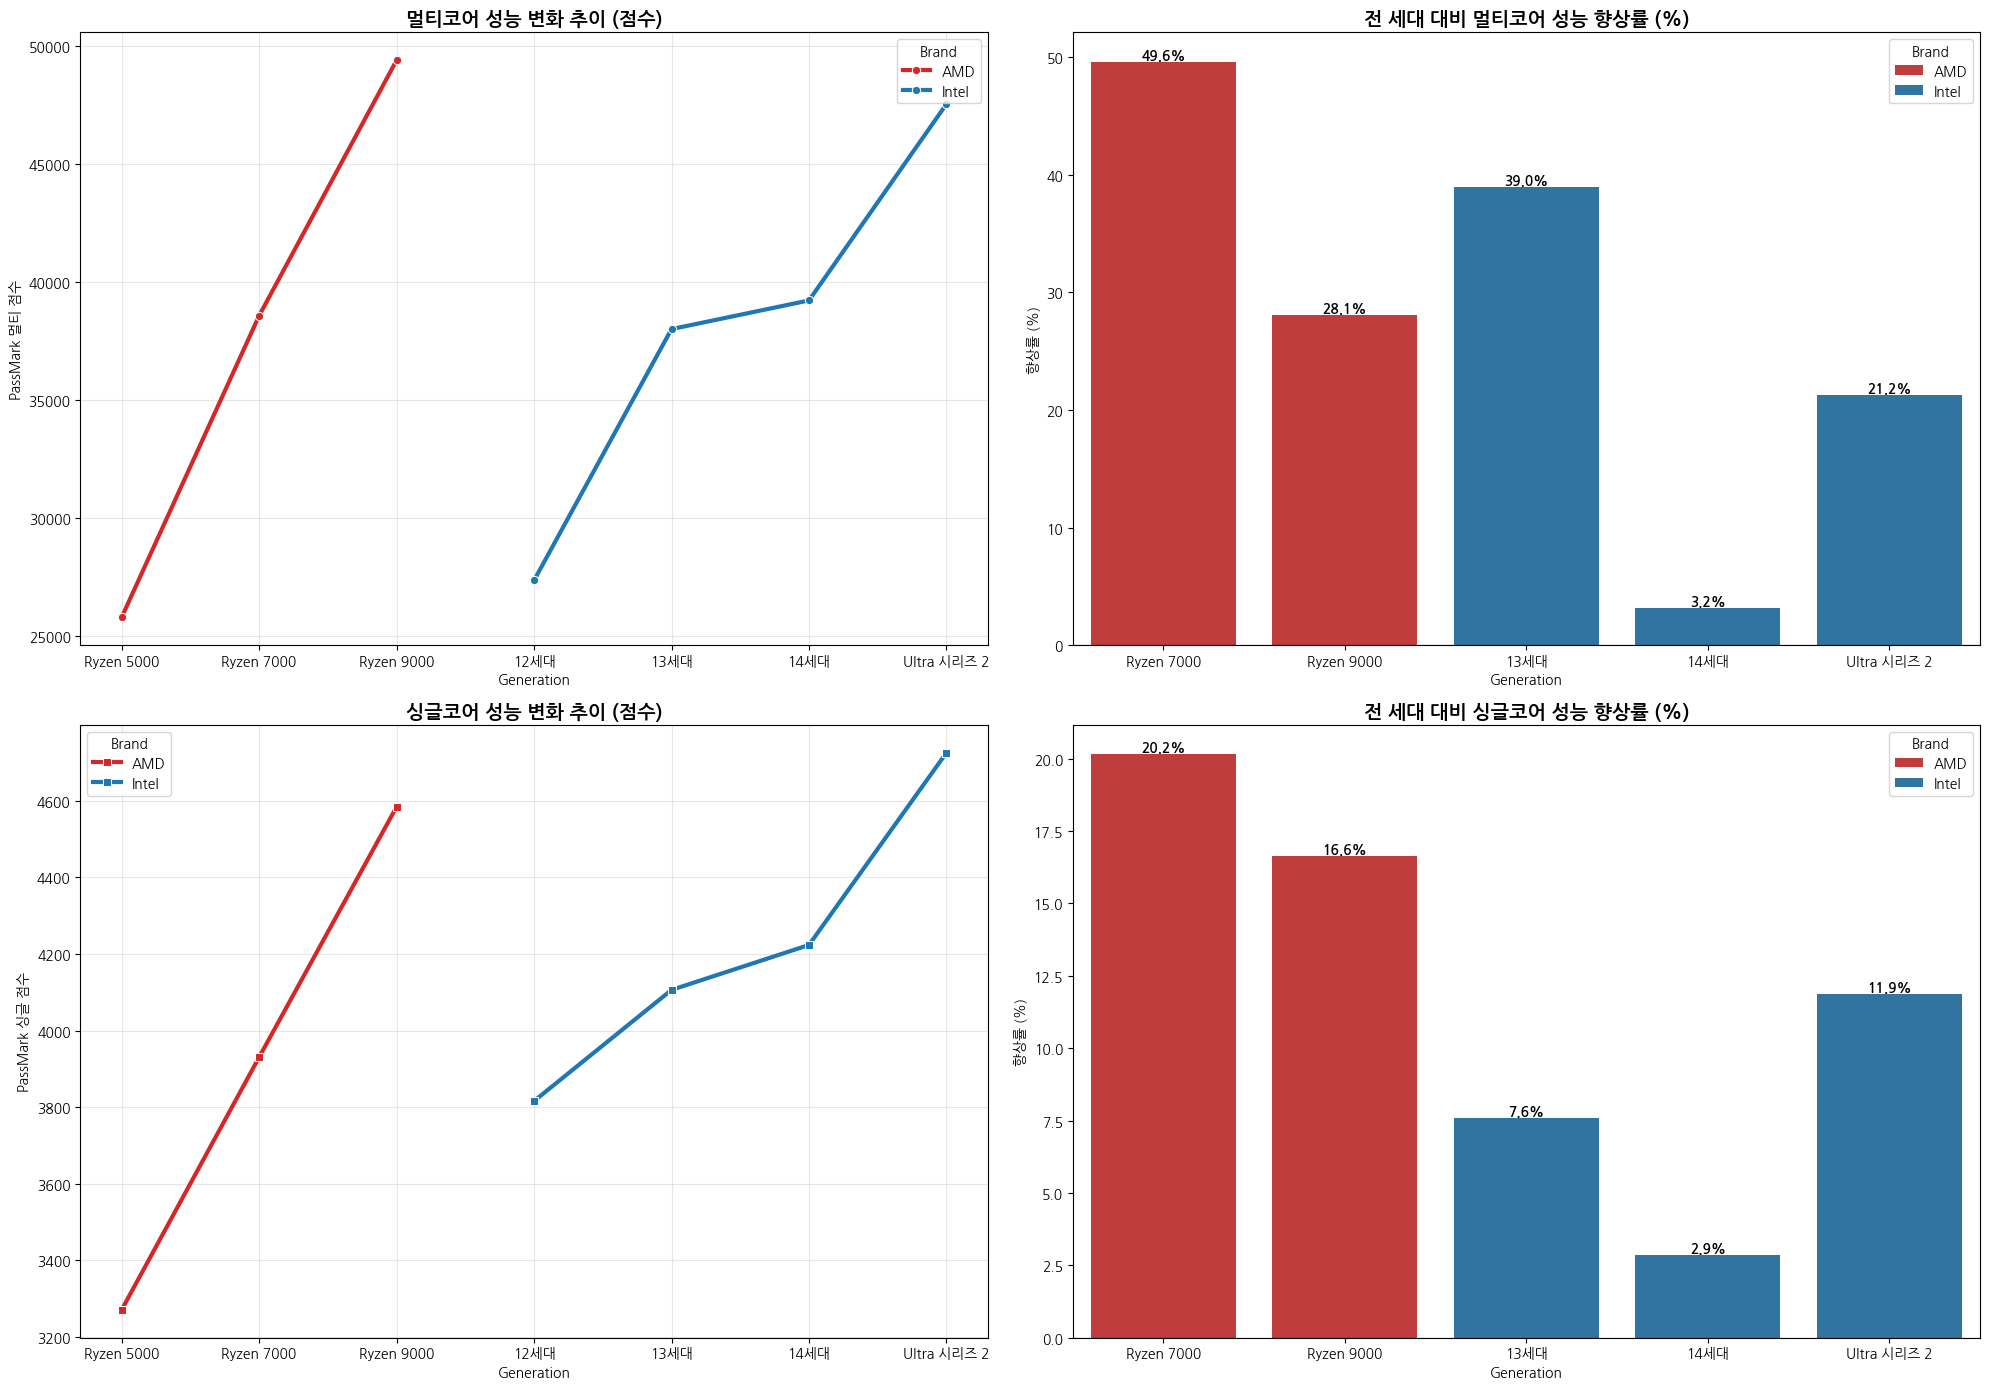

In [2]:
# --- 1. 한글 폰트 설정 (나눔바른고딕) ---
font_path = 'NanumGothic.ttf'

if not os.path.exists(font_path):
    try:
        urllib.request.urlretrieve(font_url, font_path)
    except:
        pass

try:
    fe = fm.FontEntry(fname=font_path, name='NanumGothic')
    fm.fontManager.ttflist.insert(0, fe)
    plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})
except:
    plt.rcParams['font.family'] = 'sans-serif' # 폰트 설정 실패 시 기본 폰트

# --- 2. 데이터 로드 및 전처리 ---
file_cpu = "CPU_Data.csv"

def load_process_cpu(filepath):
    if not os.path.exists(filepath): return pd.DataFrame()
    df = pd.read_csv(filepath)

    # 브랜드 추출
    df['Brand'] = df['Model'].apply(lambda x: 'Intel' if 'Intel' in str(x) else ('AMD' if 'AMD' in str(x) else 'Other'))

    # 세대 추출 로직
    def get_gen(name):
        name = str(name)
        # Intel
        if 'Intel' in name or 'Core' in name:
            m = re.search(r'Core\s+i\d[-\s](\d{2,5})', name)
            if m: return f"{int(m.group(1)[:2])}세대"
            if "Ultra" in name:
                m = re.search(r'Ultra\s+\d+\s+(\d)', name)
                if m: return f"Ultra 시리즈 {m.group(1)}"
        # AMD
        if 'AMD' in name or 'Ryzen' in name:
            m = re.search(r'Ryzen\s+\d+\s+(\d)(\d+)', name)
            if m: return f"Ryzen {m.group(1)}000"
        return "Legacy"

    df['Generation'] = df['Model'].apply(get_gen)

    # 분석 대상 (순서 중요: 구형 -> 신형)
    target_gens = ['Ryzen 5000', '12세대', '13세대', 'Ryzen 7000', '14세대', 'Ryzen 9000', 'Ultra 시리즈 2']
    df = df[df['Generation'].isin(target_gens)].copy()

    # 정렬을 위한 맵핑
    # AMD와 Intel을 별도 흐름으로 비교하기 위해 순서 그룹핑
    gen_order = {
        'Ryzen 5000': 1, 'Ryzen 7000': 2, 'Ryzen 9000': 3,
        '12세대': 1, '13세대': 2, '14세대': 3, 'Ultra 시리즈 2': 4
    }
    df['Gen_Order'] = df['Generation'].map(gen_order)
    return df.sort_values(['Brand', 'Gen_Order'])

df_cpu = load_process_cpu(file_cpu)

# --- 3. 통계 계산 및 시각화 ---
if not df_cpu.empty:
    # 브랜드별, 세대별 평균 점수 (멀티 & 싱글)
    stats = df_cpu.groupby(['Brand', 'Generation', 'Gen_Order'])[['Multi_Score', 'Single_Score']].mean().reset_index()
    stats = stats.sort_values(['Brand', 'Gen_Order'])

    # 향상률 계산 (브랜드별로 그룹화하여 pct_change)
    stats['Multi_Pct'] = stats.groupby('Brand')['Multi_Score'].pct_change() * 100
    stats['Single_Pct'] = stats.groupby('Brand')['Single_Score'].pct_change() * 100

    # NaN(첫 세대)을 0으로 채우지 않고, 그래프에서 '기준(Baseline)'으로 표시하기 위해 그대로 둠

    # 시각화 (2행 2열)
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    plt.subplots_adjust(hspace=0.35, wspace=0.2)

    # 색상 팔레트
    colors = {'AMD': 'tab:red', 'Intel': 'tab:blue'}

    # [1] 멀티코어 성능 트렌드 (Line)
    sns.lineplot(data=stats, x='Generation', y='Multi_Score', hue='Brand', marker='o', ax=axes[0, 0], palette=colors, linewidth=3)
    axes[0, 0].set_title('멀티코어 성능 변화 추이 (점수)', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('PassMark 멀티 점수')
    axes[0, 0].grid(True, alpha=0.3)

    # [2] 멀티코어 향상률 (Bar)
    # 향상률이 NaN인(기준 세대) 경우 제외하고 그리기
    stats_improvement = stats.dropna(subset=['Multi_Pct', 'Single_Pct'])

    sns.barplot(data=stats_improvement, x='Generation', y='Multi_Pct', hue='Brand', ax=axes[0, 1], palette=colors)
    axes[0, 1].set_title('전 세대 대비 멀티코어 성능 향상률 (%)', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('향상률 (%)')
    axes[0, 1].axhline(0, color='black', linewidth=0.8)

    # 값 표시
    for p in axes[0, 1].patches:
        if abs(p.get_height()) > 0:
            axes[0, 1].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()/2., p.get_height()),
                                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # [3] 싱글코어 성능 트렌드 (Line)
    sns.lineplot(data=stats, x='Generation', y='Single_Score', hue='Brand', marker='s', ax=axes[1, 0], palette=colors, linewidth=3)
    axes[1, 0].set_title('싱글코어 성능 변화 추이 (점수)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('PassMark 싱글 점수')
    axes[1, 0].grid(True, alpha=0.3)

    # [4] 싱글코어 향상률 (Bar)
    sns.barplot(data=stats_improvement, x='Generation', y='Single_Pct', hue='Brand', ax=axes[1, 1], palette=colors)
    axes[1, 1].set_title('전 세대 대비 싱글코어 성능 향상률 (%)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('향상률 (%)')
    axes[1, 1].axhline(0, color='black', linewidth=0.8)

    for p in axes[1, 1].patches:
        if abs(p.get_height()) > 0:
            axes[1, 1].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()/2., p.get_height()),
                                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('cpu_performance_analysis_full.png')

    # 텍스트 리포트
    print("\n" + "="*50)
    print("[CPU 성능 분석 요약 (멀티 & 싱글)]")
    print("="*50)

    # 보기 좋게 출력
    display_cols = ['Brand', 'Generation', 'Multi_Score', 'Multi_Pct', 'Single_Score', 'Single_Pct']
    print(stats[display_cols].round(1).to_string(index=False))
    print("\n* Multi_Pct / Single_Pct: 전 세대 대비 향상률 (NaN은 기준 세대)")

else:
    print("데이터를 분석할 수 없습니다.")

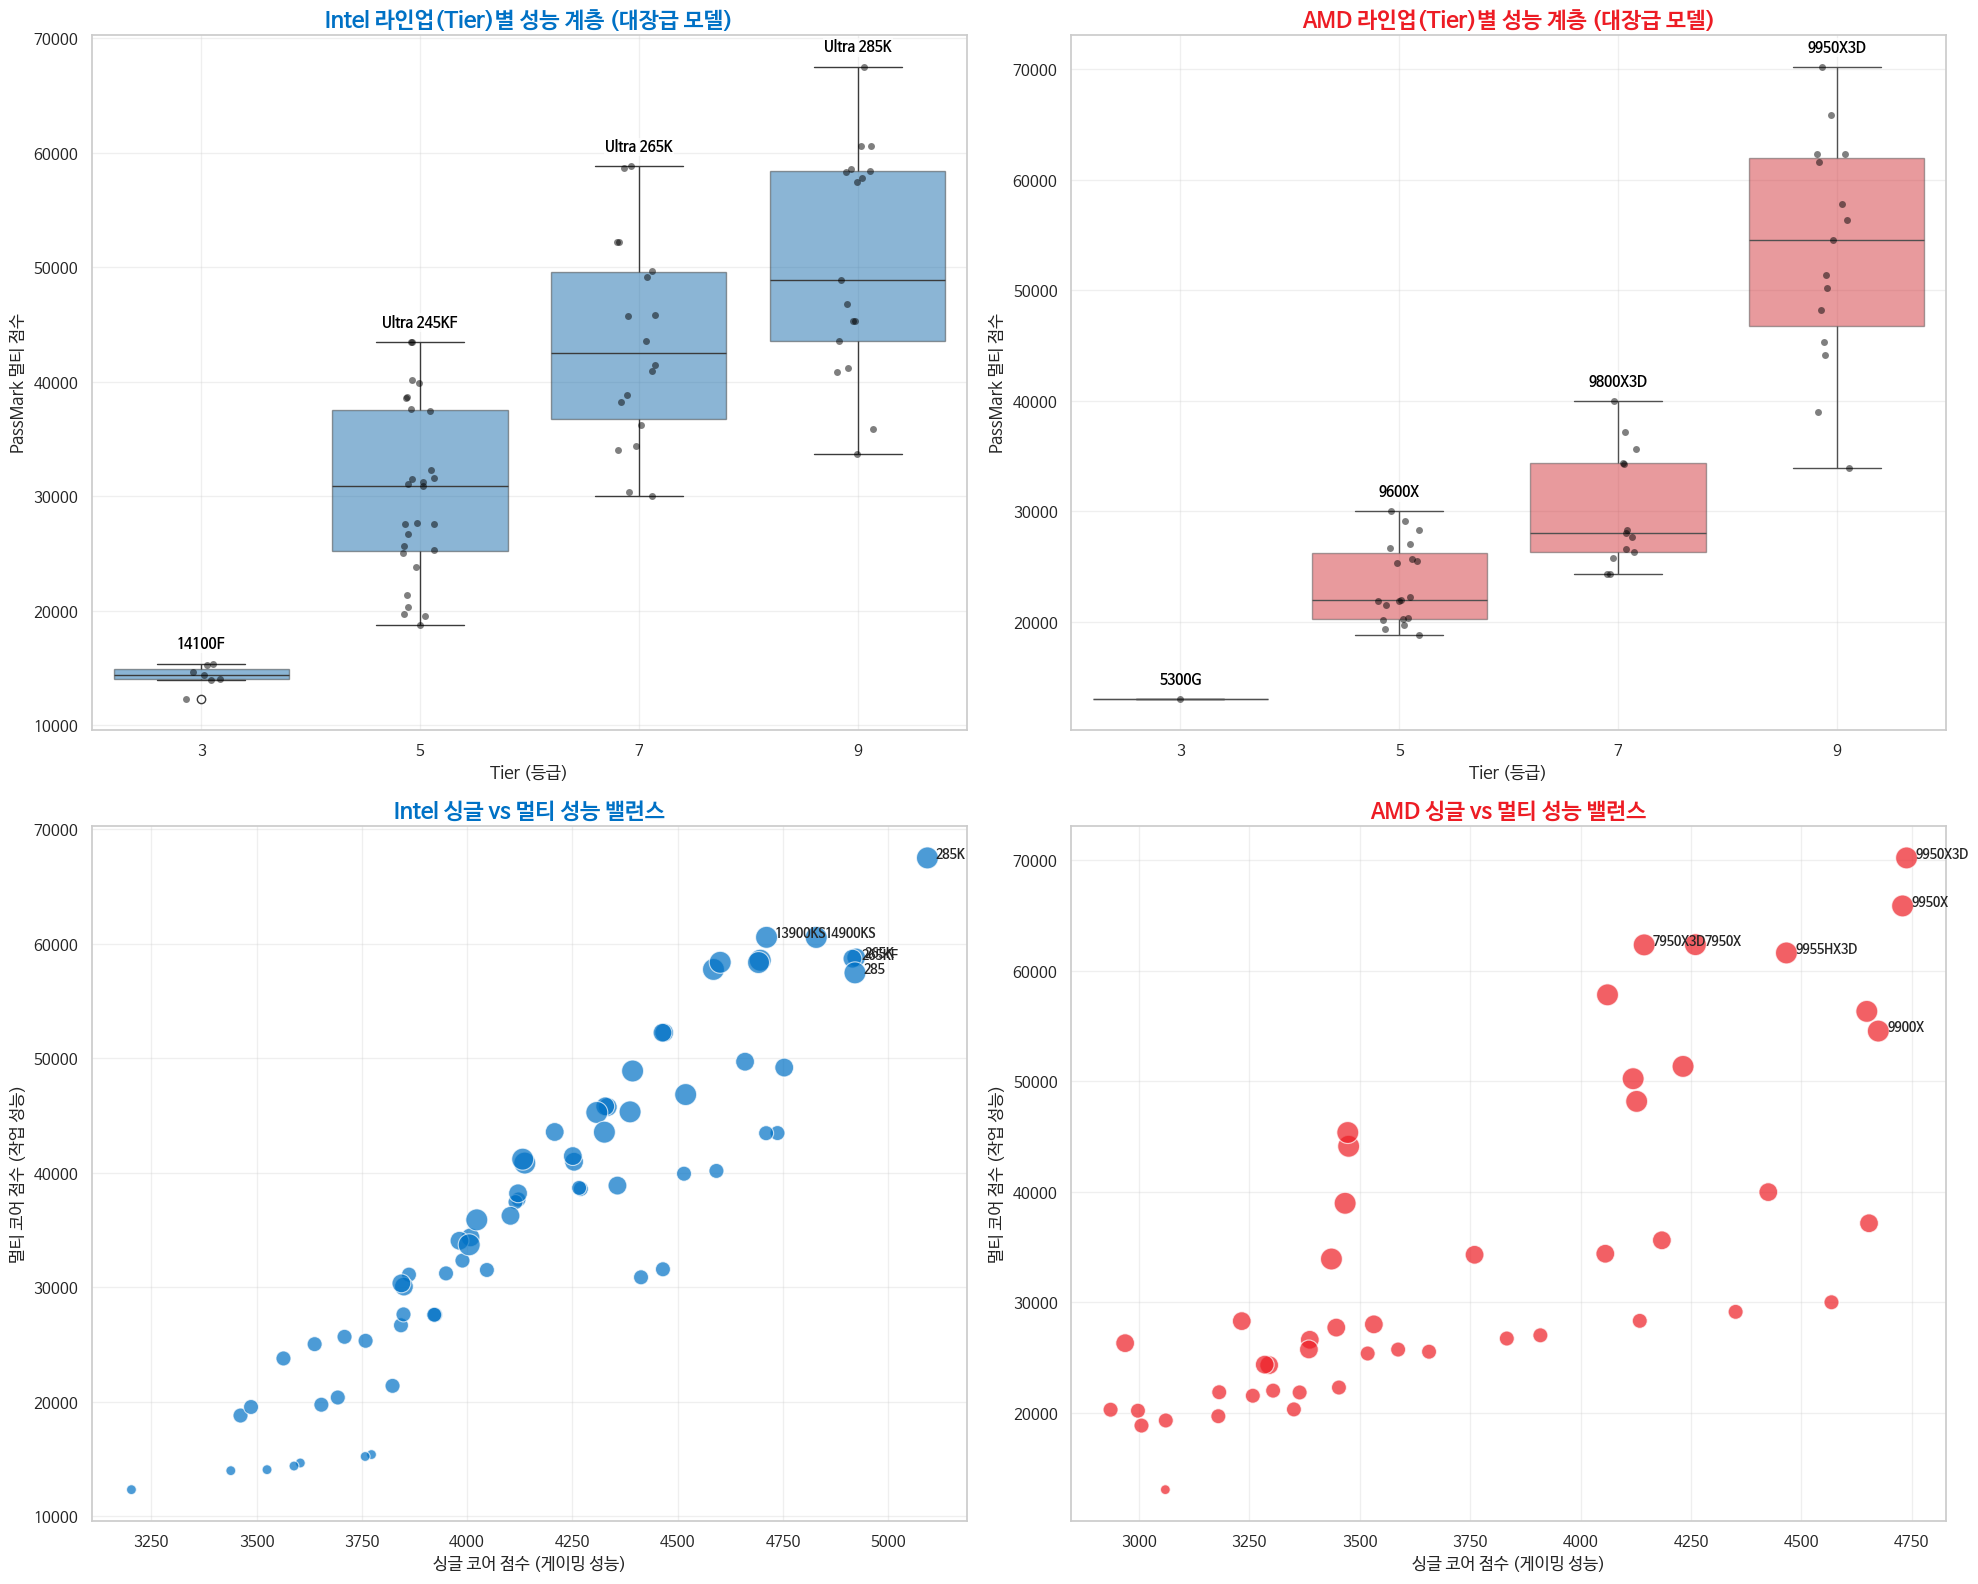

In [ ]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", font='NanumBarunGothic')

# ---------------------------------------------------------
# [2] 데이터 로드 및 전처리
# ---------------------------------------------------------
file_cpu = "CPU_Data.csv"

def load_and_prep(filepath):
    if not os.path.exists(filepath): return pd.DataFrame()
    df = pd.read_csv(filepath)

    # 1. 브랜드 추출
    df['Brand'] = df['Model'].apply(lambda x: 'Intel' if 'Intel' in str(x) else ('AMD' if 'AMD' in str(x) else 'Other'))

    # 2. 최신 세대만 필터링
    def is_recent(name):
        name = str(name)
        # Intel: 12~14세대, Ultra
        if 'Intel' in name or 'Core' in name:
            if re.search(r'Core\s+i\d[-\s](1[234])', name): return True
            if 'Ultra' in name: return True
        # AMD: Ryzen 5000, 7000, 9000
        if 'AMD' in name or 'Ryzen' in name:
            if re.search(r'Ryzen\s+\d+\s+[579]\d{3}', name): return True
        return False

    df = df[df['Model'].apply(is_recent)].copy()

    # 3. Tier (등급) 추출
    def get_tier(name):
        m = re.search(r'(?:Core\s+i|Ultra\s+|Ryzen\s+)(\d)', str(name))
        return int(m.group(1)) if m else None

    df['Tier'] = df['Model'].apply(get_tier)
    df = df.dropna(subset=['Tier'])
    df['Tier'] = df['Tier'].astype(int)

    return df

df_analysis = load_and_prep(file_cpu)

# ---------------------------------------------------------
# [3] 시각화 (Intel vs AMD 분리 + 라벨링 추가)
# ---------------------------------------------------------
if not df_analysis.empty:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    plt.subplots_adjust(hspace=0.3, wspace=0.15)

    brands = ['Intel', 'AMD']
    colors = {'Intel': '#0071C5', 'AMD': '#ED1C24'}

    for i, brand in enumerate(brands):
        # 해당 브랜드 데이터만 필터링
        data = df_analysis[df_analysis['Brand'] == brand].sort_values('Tier')
        color = colors[brand]

        # --- [Row 1] 라인업(Tier)별 성능 분포 (Box Plot) ---
        sns.boxplot(x='Tier', y='Multi_Score', data=data, ax=axes[0, i],
                    color=color, boxprops=dict(alpha=0.5))
        sns.stripplot(x='Tier', y='Multi_Score', data=data, ax=axes[0, i],
                      color='black', alpha=0.5, jitter=True)

        # 1. 각 등급별 1등 데이터 찾고 각 Tier별 최고 점수 모델 이름 표시
        top_performers = data.loc[data.groupby('Tier')['Multi_Score'].idxmax()]

        # 2. 박스 플롯의 X축 좌표 매핑 (Tier가 3,5,7,9 순서대로 0,1,2,3 인덱스를 가짐)
        unique_tiers = sorted(data['Tier'].unique())
        tier_to_idx = {t: idx for idx, t in enumerate(unique_tiers)}

        # 3. 텍스트 표시
        for _, row in top_performers.iterrows():
            tier_val = row['Tier']
            if tier_val in tier_to_idx:
                x_pos = tier_to_idx[tier_val]
                y_pos = row['Multi_Score']
                # 모델명 줄이기
                short_name = row['Model'].split()[-1]
                if "Ultra" in row['Model']: short_name = "Ultra " + short_name

                axes[0, i].text(x_pos, y_pos + 1000, short_name,
                                ha='center', va='bottom', fontweight='bold', fontsize=10,
                                color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

        axes[0, i].set_title(f'{brand} 라인업(Tier)별 성능 계층 (대장급 모델)', fontsize=16, fontweight='bold', color=color)
        axes[0, i].set_xlabel('Tier (등급)')
        axes[0, i].set_ylabel('PassMark 멀티 점수')
        axes[0, i].grid(True, alpha=0.3)


        # --- [Row 2] 싱글 vs 멀티 성능 밸런스 (Scatter Plot) ---
        sns.scatterplot(x='Single_Score', y='Multi_Score', size='Tier', sizes=(50, 250),
                        data=data, ax=axes[1, i], color=color, alpha=0.7, legend=False)

        axes[1, i].set_title(f'{brand} 싱글 vs 멀티 성능 밸런스', fontsize=16, fontweight='bold', color=color)
        axes[1, i].set_xlabel('싱글 코어 점수 (게이밍 성능)')
        axes[1, i].set_ylabel('멀티 코어 점수 (작업 성능)')
        axes[1, i].grid(True, alpha=0.3)

        # 주요 모델 이름 표시 (가독성을 위해 상위 모델 위주)
        # 멀티 점수 Top 5 + 싱글 점수 Top 3
        top_models = data.sort_values('Multi_Score', ascending=False).head(5)['Model'].tolist()
        top_gaming = data.sort_values('Single_Score', ascending=False).head(3)['Model'].tolist()
        label_models = set(top_models + top_gaming)

        for idx, row in data.iterrows():
            if row['Model'] in label_models:
                short_name = row['Model'].split()[-1]
                axes[1, i].text(row['Single_Score']+20, row['Multi_Score'], short_name,
                                fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig('cpu_Tier_Balance.png')
    plt.show()

else:
    print("데이터가 없어 시각화할 수 없습니다.")

In [ ]:
# --- 1. 데이터 로드 및 전처리 ---
file_cpu = "CPU_Data.csv"

def load_and_prep(filepath):
    if not os.path.exists(filepath): return pd.DataFrame()
    df = pd.read_csv(filepath)

    # 브랜드
    df['Brand'] = df['Model'].apply(lambda x: 'Intel' if 'Intel' in str(x) else ('AMD' if 'AMD' in str(x) else 'Other'))

    # Tier 추출
    def get_tier(name):
        m = re.search(r'(?:Core\s+i|Ultra\s+|Ryzen\s+)(\d)', str(name))
        return int(m.group(1)) if m else None

    df['Tier'] = df['Model'].apply(get_tier)
    df = df.dropna(subset=['Tier'])
    df['Tier'] = df['Tier'].astype(int)

    return df

df = load_and_prep(file_cpu)

# --- 2. 인터랙티브 시각화 ---
if not df.empty:
    # (1) 싱글 vs 멀티 성능 밸런스 (Scatter Plot)
    fig = px.scatter(df,
                     x='Single_Score',
                     y='Multi_Score',
                     color='Brand',
                     size='Tier',
                     hover_name='Model', # 마우스 올리면 모델명 표시
                     hover_data=['Tier', 'MSRP', 'Release Date'], # 추가로 보여줄 정보
                     color_discrete_map={'Intel': '#0071C5', 'AMD': '#ED1C24'},
                     title='<b>싱글 vs 멀티 성능 밸런스 분석</b> (마우스를 올려보세요!)',
                     labels={'Single_Score': '싱글 코어 점수 (게이밍)', 'Multi_Score': '멀티 코어 점수 (작업)'},
                     height=700)

    # 그래프 꾸미기
    fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')), opacity=0.8)
    fig.update_layout(title_font_size=20, hovermode='closest')

    # 기준선이나 영역 표시 (선택 사항)
    fig.add_hline(y=40000, line_dash="dot", annotation_text="High-End Workstation")

    fig.show()
    fig.write_html("single_multi_balance.html")

    # (2) 라인업(Tier)별 성능 분포 (Box Plot with Points)
    fig2 = px.box(df,
                  x='Tier',
                  y='Multi_Score',
                  color='Brand',
                  points="all", # 모든 점 표시 (마우스 오버 가능하게)
                  hover_name='Model',
                  hover_data=['Single_Score', 'Release Date'],
                  color_discrete_map={'Intel': '#0071C5', 'AMD': '#ED1C24'},
                  title='<b>라인업(Tier)별 성능 계층 구조</b>',
                  labels={'Multi_Score': 'PassMark 멀티 점수'},
                  height=600)

    fig2.update_layout(boxmode='group') # 브랜드별로 나란히 보기
    fig2.show()
    fig2.write_html("tier_distribution.html")

else:
    print("데이터가 없습니다.")

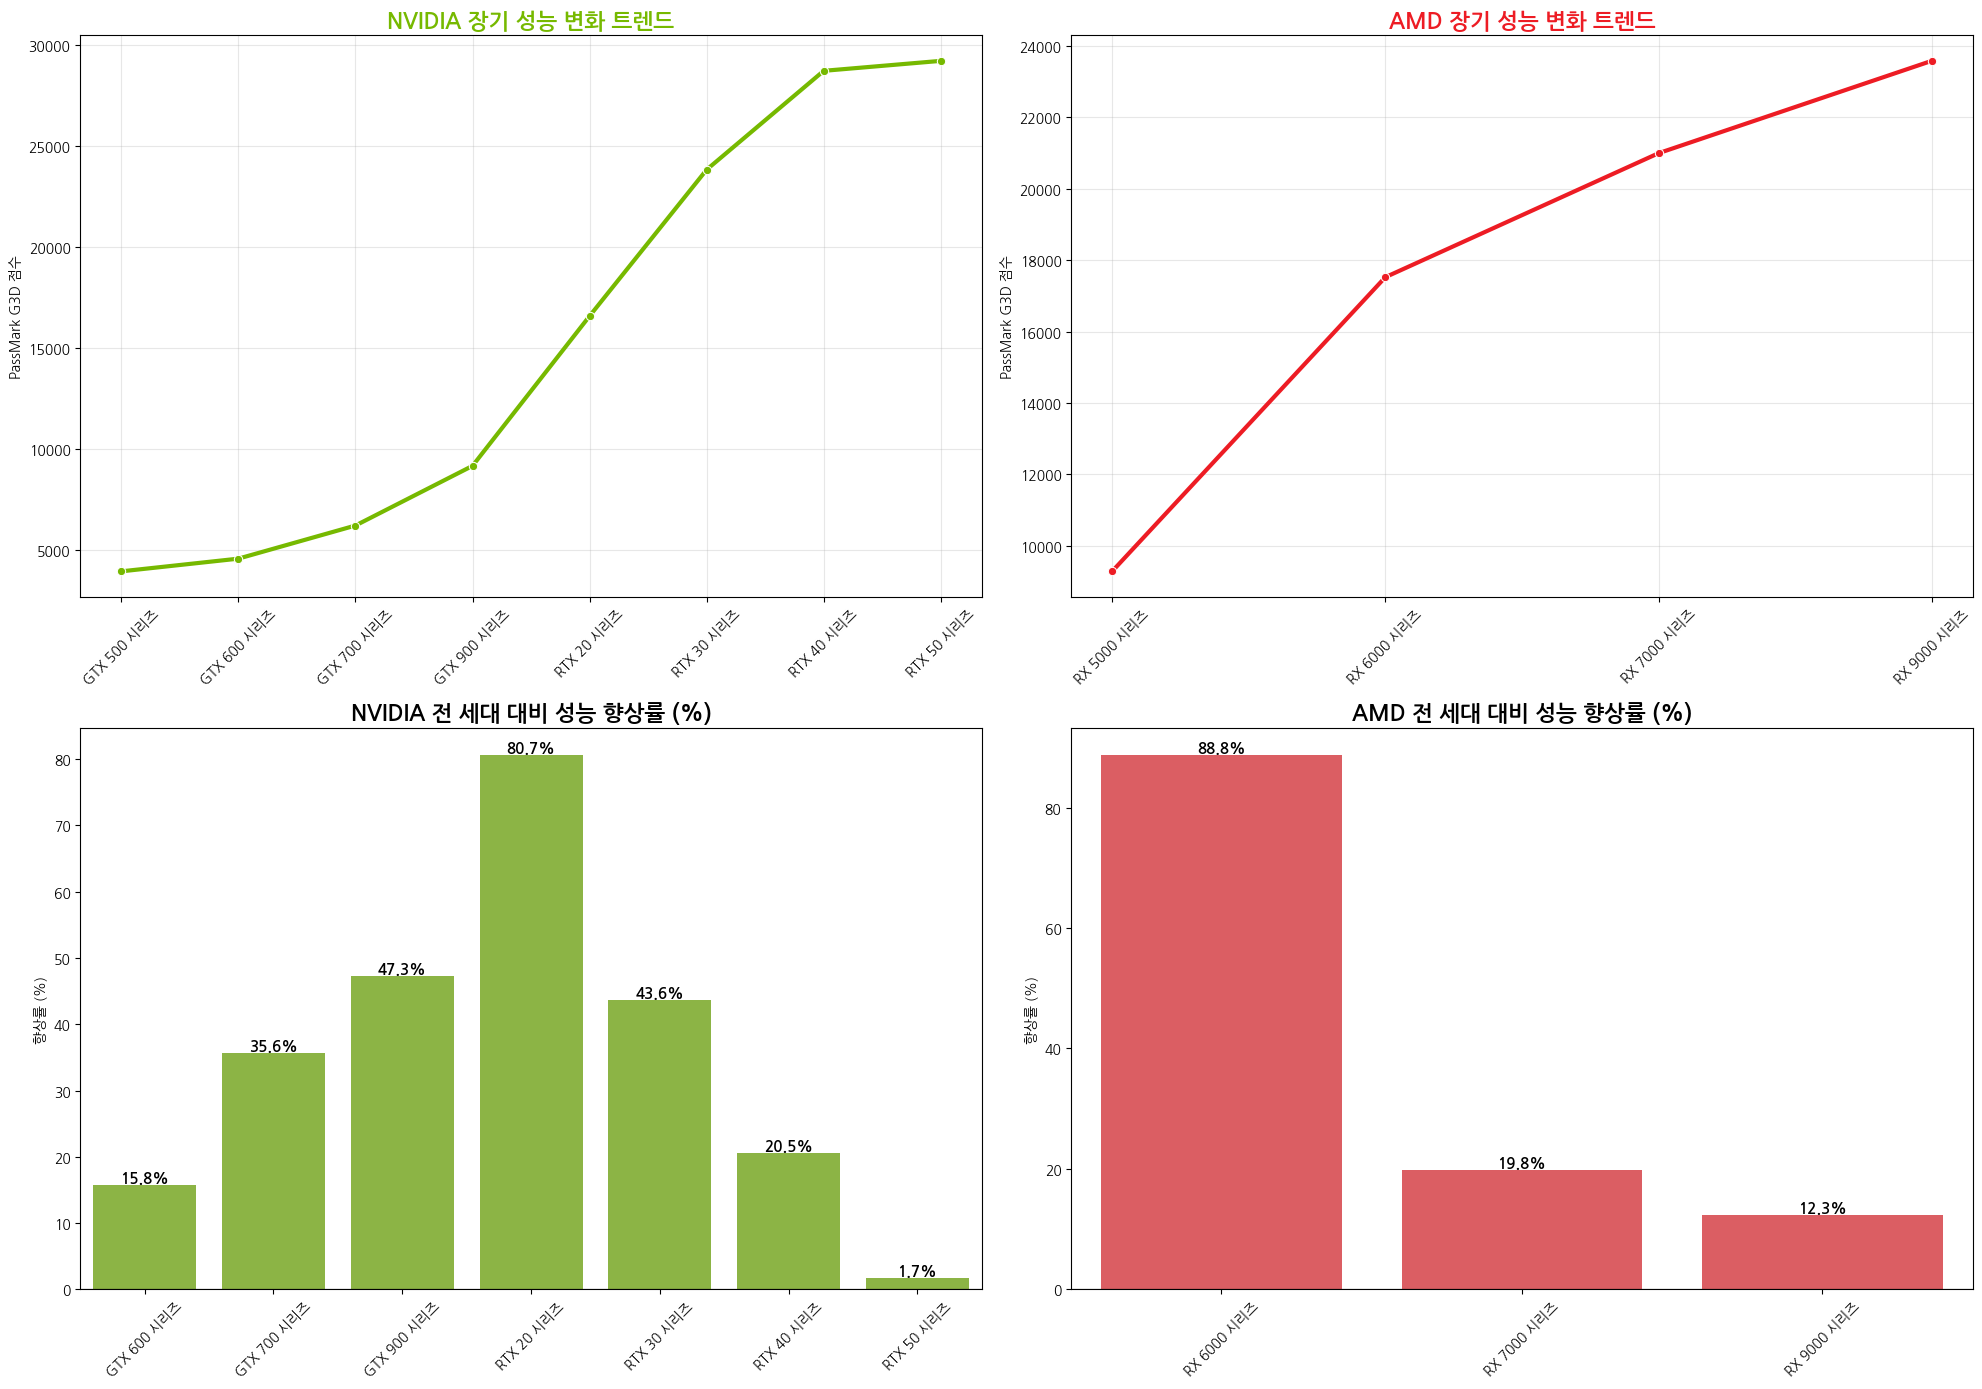


📊 [NVIDIA 성능 역사]
 Generation  G3D_Score  Pct_Change
GTX 500 시리즈     3968.3         NaN
GTX 600 시리즈     4596.1        15.8
GTX 700 시리즈     6233.0        35.6
GTX 900 시리즈     9183.2        47.3
 RTX 20 시리즈    16592.8        80.7
 RTX 30 시리즈    23830.5        43.6
 RTX 40 시리즈    28717.2        20.5
 RTX 50 시리즈    29210.0         1.7

📊 [AMD 성능 역사]
 Generation  G3D_Score  Pct_Change
RX 5000 시리즈     9280.3         NaN
RX 6000 시리즈    17521.8        88.8
RX 7000 시리즈    20995.2        19.8
RX 9000 시리즈    23582.8        12.3


In [4]:
file_gpu = "GPU_Data.csv"

def load_and_prep_gpu_extended(filepath):
    if not os.path.exists(filepath): return pd.DataFrame()
    df = pd.read_csv(filepath)

    # 1. 브랜드 추출
    def get_brand(name):
        name = str(name).upper()
        if 'NVIDIA' in name or 'GEFORCE' in name or 'RTX' in name or 'GTX' in name: return 'NVIDIA'
        if 'AMD' in name or 'RADEON' in name: return 'AMD'
        return 'Other'
    df['Brand'] = df['Model'].apply(get_brand)
    df = df[df['Brand'].isin(['NVIDIA', 'AMD'])].copy()

    # 2. 세대(Generation) 추출 - 범위 확장
    def get_gen(name):
        name = str(name).upper()
        # NVIDIA
        if 'RTX' in name:
            m = re.search(r'RTX\s+(\d{2})', name)
            if m: return f"RTX {m.group(1)} 시리즈"
        if 'GTX' in name:
            m = re.search(r'GTX\s+(\d{2,3})', name) # 10, 16, 900, 700...
            if m:
                num = int(m.group(1))
                # 3자리수 (500~900)
                if 500 <= num < 600: return "GTX 500 시리즈"
                if 600 <= num < 700: return "GTX 600 시리즈"
                if 700 <= num < 800: return "GTX 700 시리즈"
                if 900 <= num < 1000: return "GTX 900 시리즈"
                # 2자리수 (10, 16)
                if num == 10: return "GTX 10 시리즈"
                if num == 16: return "GTX 16 시리즈"

        # AMD (RX 5000+)
        if 'RX' in name:
            m = re.search(r'RX\s+(\d)(\d+)', name)
            if m:
                series_num = int(m.group(1))
                if series_num >= 5: # 5000, 6000, 7000, 9000
                    return f"RX {series_num}000 시리즈"
        return "Legacy"

    df['Generation'] = df['Model'].apply(get_gen)

    # 분석 대상 세대 (순서 지정용)
    nvidia_gens = ['GTX 500 시리즈', 'GTX 600 시리즈', 'GTX 700 시리즈', 'GTX 900 시리즈',
                   'GTX 10 시리즈', 'GTX 16 시리즈', 'RTX 20 시리즈', 'RTX 30 시리즈', 'RTX 40 시리즈', 'RTX 50 시리즈']
    amd_gens = ['RX 5000 시리즈', 'RX 6000 시리즈', 'RX 7000 시리즈', 'RX 9000 시리즈']

    target_gens = nvidia_gens + amd_gens
    df = df[df['Generation'].isin(target_gens)].copy()

    # 정렬 순서 (Gen_Order)
    gen_map = {gen: i for i, gen in enumerate(nvidia_gens)}
    gen_map.update({gen: i for i, gen in enumerate(amd_gens)}) # AMD는 별도 그래프라 인덱스 겹쳐도 무관

    df['Gen_Order'] = df['Generation'].map(gen_map)

    return df.sort_values(['Brand', 'Gen_Order'])

df_gpu = load_and_prep_gpu_extended(file_gpu)

# ---------------------------------------------------------
# [3] 시각화 (브랜드별 분리)
# ---------------------------------------------------------
if not df_gpu.empty:
    # 통계 계산
    gpu_stats = df_gpu.groupby(['Brand', 'Generation', 'Gen_Order'])['G3D_Score'].mean().reset_index().sort_values('Gen_Order')
    gpu_stats['Pct_Change'] = gpu_stats.groupby('Brand')['G3D_Score'].pct_change() * 100

    # 그래프 그리기
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

    brands = ['NVIDIA', 'AMD']
    colors = {'NVIDIA': '#76B900', 'AMD': '#ED1C24'}

    for i, brand in enumerate(brands):
        # 해당 브랜드 데이터
        data = gpu_stats[gpu_stats['Brand'] == brand]

        # [상단] 세대별 성능 트렌드 (Line Plot)
        sns.lineplot(data=data, x='Generation', y='G3D_Score', marker='o', ax=axes[0, i],
                     color=colors[brand], linewidth=3)

        axes[0, i].set_title(f'{brand} 장기 성능 변화 트렌드', fontsize=16, fontweight='bold', color=colors[brand])
        axes[0, i].set_ylabel('PassMark G3D 점수')
        axes[0, i].set_xlabel('')
        axes[0, i].tick_params(axis='x', rotation=45) # X축 라벨 회전
        axes[0, i].grid(True, alpha=0.3)

        # [하단] 세대별 성능 향상률 (Bar Plot)
        # 첫 세대는 향상률이 NaN이므로 제외
        data_imp = data.dropna(subset=['Pct_Change'])

        sns.barplot(data=data_imp, x='Generation', y='Pct_Change', ax=axes[1, i],
                    color=colors[brand], alpha=0.8)

        axes[1, i].set_title(f'{brand} 전 세대 대비 성능 향상률 (%)', fontsize=16, fontweight='bold')
        axes[1, i].set_ylabel('향상률 (%)')
        axes[1, i].set_xlabel('')
        axes[1, i].axhline(0, color='black', linewidth=0.8)
        axes[1, i].tick_params(axis='x', rotation=45)

        # 값 표시
        for p in axes[1, i].patches:
            if abs(p.get_height()) > 0:
                axes[1, i].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                                 ha='center', va='bottom' if p.get_height() > 0 else 'top',
                                 fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig('gpu_history_analysis.png')
    plt.show()

    # 요약 표 출력
    print("\n📊 [NVIDIA 성능 역사]")
    print(gpu_stats[gpu_stats['Brand']=='NVIDIA'][['Generation', 'G3D_Score', 'Pct_Change']].round(1).to_string(index=False))

    print("\n📊 [AMD 성능 역사]")
    print(gpu_stats[gpu_stats['Brand']=='AMD'][['Generation', 'G3D_Score', 'Pct_Change']].round(1).to_string(index=False))

else:
    print("❌ 데이터가 없습니다.")

# **5. 게임 목록 획득**

In [ ]:
# PCGamingWiki의 API 엔드포인트 URL
API_URL = "https://www.pcgamingwiki.com/w/api.php"

# API에 보낼 파라미터 설정
# 'list=categorymembers' : 카테고리 멤버(항목)를 가져옵니다.
# 'cmtitle=Category:Games' : 'Games' 카테고리를 대상으로 합니다.
# 'cmlimit=500' : 한 번의 요청으로 최대 500개까지 가져옵니다. (API 최대치)
params = {
    "action": "query",
    "list": "categorymembers",
    "cmtitle": "Category:Games",
    "cmlimit": "500",
    "format": "json"
}

# 모든 게임 타이틀을 저장할 리스트
all_games = []

# API 서버에 과도한 요청을 피하기 위한 세션 생성
session = requests.Session()

print("PCGamingWiki 'Games' 카테고리 목록 가져오기 시작...")

while True:
    try:
        # API 요청 보내기
        response = session.get(url=API_URL, params=params)
        response.raise_for_status()  # 오류가 발생하면 예외 발생

        data = response.json()

        # 받아온 게임 목록(data['query']['categorymembers'])을 all_games 리스트에 추가
        games_batch = data.get("query", {}).get("categorymembers", [])
        if not games_batch:
            print("더 이상 가져올 게임이 없거나 API 응답에 'categorymembers'가 없습니다.")
            break

        for game in games_batch:
            all_games.append(game["title"])

        print(f"현재까지 {len(all_games)}개 게임 목록 확보...")

        # --- 페이지 넘김(Pagination) 처리 ---
        # 'continue' 항목이 응답에 포함되어 있는지 확인
        if "continue" in data:
            # 다음 페이지를 요청하기 위한 'cmcontinue' 토큰을 파라미터에 추가
            params["cmcontinue"] = data["continue"]["cmcontinue"]

            # (예의상) 다음 요청 전에 잠시 대기 (서버 부하 방지)
            time.sleep(0.5)
        else:
            # 'continue' 항목이 없으면 모든 데이터를 가져온 것이므로 반복 종료
            print("모든 페이지를 다 가져왔습니다.")
            break

    except requests.exceptions.RequestException as e:
        print(f"오류 발생: {e}")
        break
    except KeyError as e:
        print(f"JSON 응답 구조 오류: {e}")
        print("응답 데이터:", data)
        break

print("---" * 10)
print(f"총 {len(all_games)}개의 게임 타이틀을 가져왔습니다.")
print("---" * 10)

# 가져온 목록 샘플 출력 (처음 20개)
print("\n[가져온 게임 목록 샘플 (처음 20개)]")
for game_title in all_games[:20]:
    print(game_title)

PCGamingWiki 'Games' 카테고리 목록 가져오기 시작...
현재까지 500개 게임 목록 확보...
현재까지 1000개 게임 목록 확보...
현재까지 1500개 게임 목록 확보...
현재까지 2000개 게임 목록 확보...
현재까지 2500개 게임 목록 확보...
현재까지 3000개 게임 목록 확보...
현재까지 3500개 게임 목록 확보...
현재까지 4000개 게임 목록 확보...
현재까지 4500개 게임 목록 확보...
현재까지 5000개 게임 목록 확보...
현재까지 5500개 게임 목록 확보...
현재까지 6000개 게임 목록 확보...
현재까지 6500개 게임 목록 확보...
현재까지 7000개 게임 목록 확보...
현재까지 7500개 게임 목록 확보...
현재까지 8000개 게임 목록 확보...
현재까지 8500개 게임 목록 확보...
현재까지 9000개 게임 목록 확보...
현재까지 9500개 게임 목록 확보...
현재까지 10000개 게임 목록 확보...
현재까지 10500개 게임 목록 확보...
현재까지 11000개 게임 목록 확보...
현재까지 11500개 게임 목록 확보...
현재까지 12000개 게임 목록 확보...
현재까지 12500개 게임 목록 확보...
현재까지 13000개 게임 목록 확보...
현재까지 13500개 게임 목록 확보...
현재까지 14000개 게임 목록 확보...
현재까지 14500개 게임 목록 확보...
현재까지 15000개 게임 목록 확보...
현재까지 15500개 게임 목록 확보...
현재까지 16000개 게임 목록 확보...
현재까지 16500개 게임 목록 확보...
현재까지 17000개 게임 목록 확보...
현재까지 17500개 게임 목록 확보...
현재까지 18000개 게임 목록 확보...
현재까지 18500개 게임 목록 확보...
현재까지 19000개 게임 목록 확보...
현재까지 19500개 게임 목록 확보...
현재까지 20000개 게임 목록 확보...
현재까지 20500개 게임 목록 확보

In [ ]:
df = pd.DataFrame(all_games, columns=["Game Title"])
file_name = "pc_games_list.csv"
df.to_csv(file_name, index=False, encoding='utf-8-sig')

print(f"총 {len(all_games)}개의 게임 목록을 '{file_name}' 파일로 저장했습니다.")

총 53224개의 게임 목록을 'pc_games_list.csv' 파일로 저장했습니다.


In [ ]:
# --- 설정 ---
INPUT_FILE = "pc_games_list.csv"       # 원본 게임 목록
OUTPUT_FILE = "./original_source_pc_games_specs_fixed.csv" # 결과 저장 파일
API_URL = "https://www.pcgamingwiki.com/w/api.php"

session = requests.Session()

# CSV 헤더 정의
fieldnames = [
    "Game Title",
    "OS (Min)", "CPU (Min)", "GPU (Min)", "RAM (Min)", "Storage (Min)",
    "OS (Rec)", "CPU (Rec)", "GPU (Rec)", "RAM (Rec)", "Storage (Rec)"
]

print("--- 작업 준비 중 ---")

# 1. 이미 작업된 게임 확인 (이어하기 기능)
completed_games = set()
if os.path.exists(OUTPUT_FILE):
    try:
        with open(OUTPUT_FILE, 'r', encoding='utf-8-sig') as f:
            reader = csv.reader(f)
            next(reader, None)
            for row in reader:
                if row:
                    completed_games.add(row[0])
        print(f"이미 작업 완료된 게임: {len(completed_games)}개 (건너뜁니다)")
    except Exception as e:
        print(f"기존 파일 읽기 오류 (무시하고 진행): {e}")

# 2. 작업할 게임 목록 읽기
games_to_search = []
try:
    with open(INPUT_FILE, 'r', encoding='utf-8-sig') as f:
        reader = csv.reader(f)
        next(reader, None)
        for row in reader:
            if row:
                game_title = row[0]
                if game_title not in completed_games:
                    games_to_search.append(game_title)
except FileNotFoundError:
    print(f"오류: '{INPUT_FILE}' 파일이 없습니다.")
    exit()

print(f"남은 작업 대상: {len(games_to_search)}개")
print("--- 수집 시작 ---")

def parse_specs(wikitext):
    """
    개선된 파싱 함수:
    Regex로 하나씩 찾는 대신, 템플릿 전체를 먼저 파싱하여 딕셔너리로 만듭니다.
    이 방식은 줄바꿈이 없거나 형식이 깨진 위키 텍스트에서도 밀림 현상을 방지합니다.
    """
    specs = {k: "" for k in fieldnames if k != "Game Title"}

    # 1. System requirements 템플릿 추출
    match = re.search(r'\{\{System requirements\s*(.*?)\}\}', wikitext, re.IGNORECASE | re.DOTALL)

    if match:
        content = match.group(1)

        # 2. 파라미터 분리 로직
        # 파이프(|)로 시작하고 등호(=)가 있는 패턴을 기준으로 텍스트를 쪼갭니다.
        # lookahead (?=...)를 사용하여 다음 파라미터가 시작되기 직전까지만 가져옵니다.
        # 패턴: |키이름 = 값 (다음 |키이름= 전까지)
        param_pattern = re.compile(r'\|\s*([a-zA-Z0-9_]+)\s*=\s*(.*?)(?=(?:\|\s*[a-zA-Z0-9_]+\s*=)|$|\}\})', re.DOTALL)

        # 추출된 파라미터를 딕셔너리에 저장 (Key는 소문자로 통일하여 매칭 확률 높임)
        raw_params = {}
        for m in param_pattern.finditer(content):
            key = m.group(1).strip().lower()
            value = m.group(2).strip()
            raw_params[key] = value

        # 3. 값 정제 및 추출 헬퍼 함수
        def get_clean_val(candidate_keys):
            found_values = []
            for key in candidate_keys:
                key = key.lower() # 검색 키도 소문자로 변환
                if key in raw_params:
                    raw_val = raw_params[key]
                    if raw_val:
                        # 정제 과정
                        # 1. 링크 제거 [[Link|Text]] -> Text
                        clean = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', raw_val)
                        # 2. HTML 태그 제거 <br>, <ref> 등
                        clean = re.sub(r'<[^>]+>', ' ', clean)
                        # 3. 중괄호 {{...}} 제거 (가끔 템플릿 안에 템플릿이 있는 경우)
                        clean = re.sub(r'\{\{.*?\}\}', '', clean)
                        # 4. 공백 정리
                        clean = ' '.join(clean.split())

                        if clean:
                            found_values.append(clean)

            return " / ".join(found_values)

        # === 데이터 매핑 ===
        # 이제 딕셔너리에서 꺼내옵니다.
        specs["OS (Min)"] = get_clean_val(["minOS", "min_OS"])
        specs["CPU (Min)"] = get_clean_val(["minCPU", "min_CPU", "minCPU2", "min_CPU2", "minCPU3"])
        specs["GPU (Min)"] = get_clean_val(["minGPU", "min_GPU", "minGPU2", "min_GPU2", "minGPU3"])
        specs["RAM (Min)"] = get_clean_val(["minRAM", "min_RAM"])
        specs["Storage (Min)"] = get_clean_val(["minHD", "min_HD", "minStorage"])

        specs["OS (Rec)"] = get_clean_val(["recOS", "rec_OS"])
        specs["CPU (Rec)"] = get_clean_val(["recCPU", "rec_CPU", "recCPU2", "rec_CPU2", "recCPU3"])
        specs["GPU (Rec)"] = get_clean_val(["recGPU", "rec_GPU", "recGPU2", "rec_GPU2", "recGPU3"])
        specs["RAM (Rec)"] = get_clean_val(["recRAM", "rec_RAM"])
        specs["Storage (Rec)"] = get_clean_val(["recHD", "rec_HD", "recStorage"])

        return specs, True

    return specs, False

# 3. 결과 파일 열기 (이어쓰기 모드)
file_exists = os.path.exists(OUTPUT_FILE)

with open(OUTPUT_FILE, 'a', newline='', encoding='utf-8-sig') as out_f:
    writer = csv.DictWriter(out_f, fieldnames=fieldnames)

    if not file_exists or os.path.getsize(OUTPUT_FILE) == 0:
        writer.writeheader()

    for index, game_title in enumerate(games_to_search):

        # 진행 상황 표시
        print(f"[{index+1}/{len(games_to_search)}] {game_title} ... ", end="")

        params = {
            "action": "query",
            "titles": game_title,
            "prop": "revisions",
            "rvprop": "content",
            "format": "json",
            "redirects": 1
        }

        try:
            response = session.get(API_URL, params=params, timeout=10) # 타임아웃 추가
            data = response.json()

            pages = data.get("query", {}).get("pages", {})
            page_id = next(iter(pages))

            row_data = {"Game Title": game_title}
            row_data.update({k: "" for k in fieldnames if k != "Game Title"})

            status_symbol = ""

            if page_id != "-1":
                page_data = pages[page_id]
                if "revisions" in page_data:
                    wikitext = page_data["revisions"][0]["*"]
                    extracted_specs, found = parse_specs(wikitext)

                    if found:
                        has_data = any(extracted_specs.values())
                        row_data.update(extracted_specs)
                        status_symbol = "✅" if has_data else "⚠️(빈 내용)"
                    else:
                        status_symbol = "🚫(틀 없음)"
                else:
                    status_symbol = "❌(내용 없음)"
            else:
                status_symbol = "❌(페이지 없음)"

            writer.writerow(row_data)
            print(status_symbol) # 같은 줄에 상태 출력

        except Exception as e:
            print(f"Err: {e}", end="")
            # 에러 발생 시 잠시 대기
            time.sleep(1)

        time.sleep(0.1) # 서버 부하 방지용 딜레이

print("\n" + "=" * 30)
print(f"모든 작업이 완료되었습니다! '{OUTPUT_FILE}' 파일을 확인하세요.")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[13009/53222] Dreadnought Sol ... ✅ 성공 (데이터 확보)
[13010/53222] DreadOut ... ✅ 성공 (데이터 확보)
[13011/53222] DreadOut 2 ... ✅ 성공 (데이터 확보)
[13012/53222] DreadOut 3 ... ✅ 성공 (데이터 확보)
[13013/53222] DreadOut: Keepers of The Dark ... ✅ 성공 (데이터 확보)
[13014/53222] DreadStar: The Quest for Revenge ... ✅ 성공 (데이터 확보)
[13015/53222] Dream ... ✅ 성공 (데이터 확보)
[13016/53222] Dream Car Builder ... ✅ 성공 (데이터 확보)
[13017/53222] Dream Catcher ... ✅ 성공 (데이터 확보)
[13018/53222] Dream Catcher Chronicles: Manitou ... ✅ 성공 (데이터 확보)
[13019/53222] Dream Chamber ... ✅ 성공 (데이터 확보)
[13020/53222] Dream Channel ... ✅ 성공 (데이터 확보)
[13021/53222] Dream Chronicles: The Book of Air ... ✅ 성공 (데이터 확보)
[13022/53222] Dream Chronicles: The Chosen Child ... ✅ 성공 (데이터 확보)
[13023/53222] Dream Coaster VR ... ✅ 성공 (데이터 확보)
[13024/53222] Dream Cycle ... ✅ 성공 (데이터 확보)
[13025/53222] Dream Daddy: A Dad Dating Simulator ... ✅ 성공 (데이터 확보)
[13026/53222] Dream Dealer ... ✅ 성공 (데이터 확보)
[13027/53222] Dream Detective .

In [ ]:
FILENAME = "./original_source/pc_games_specs_fixed.csv"

try:
    df = pd.read_csv(FILENAME)
    print(f"원본 데이터 로드 완료: {len(df)}개 행")
except FileNotFoundError:
    print(f"오류: '{FILENAME}' 파일을 찾을 수 없습니다. 코랩 파일 탭에 업로드했는지 확인해주세요.")
    df = pd.DataFrame() # 빈 프레임 생성하여 에러 방지

if not df.empty:
    # 1-1. 중복 제거
    df_clean = df.drop_duplicates(subset=['Game Title'])

    # 1-2. 완전히 빈 행(사양 정보가 하나도 없는 경우) 제거
    # 사양 관련 열 목록
    spec_cols = ['OS (Min)', 'CPU (Min)', 'GPU (Min)', 'RAM (Min)', 'Storage (Min)',
                 'OS (Rec)', 'CPU (Rec)', 'GPU (Rec)', 'RAM (Rec)', 'Storage (Rec)']

    # 모든 사양 열이 비어있는(NaN) 행 삭제
    df_clean = df_clean.dropna(subset=spec_cols, how='all')

    print(f"데이터 청소 완료: {len(df)} -> {len(df_clean)}개 (삭제된 빈 껍데기: {len(df) - len(df_clean)}개)")

    # 2. 데이터 정규화 (Normalization) 함수 정의
    # [함수 1] 텍스트 용량(MB, GB 등)을 숫자(GB)로 변환
    def parse_size_to_gb(text):
        if pd.isna(text) or text == "":
            return None

        # 텍스트 정리 (콤마 제거, 대문자 변환)
        text = str(text).upper().replace(",", "")

        # 정규표현식: 숫자 + 단위 찾기 (예: 512 MB, 4 GB)
        match = re.search(r'(\d+(?:\.\d+)?)\s*(TB|GB|MB|KB)', text)

        if match:
            number = float(match.group(1))
            unit = match.group(2)

            if unit == 'TB': return number * 1024
            elif unit == 'GB': return number
            elif unit == 'MB': return number / 1024
            elif unit == 'KB': return number / (1024 * 1024)

        return None

    # [함수 2] 운영체제(OS) 이름을 표준 카테고리로 분류
    def normalize_os(text):
        if pd.isna(text) or text == "":
            return "Unknown"

        text = str(text).lower()

        # Windows 계열 우선 확인
        if any(x in text for x in ['win', 'xp', 'vista']) or re.search(r'\b(7|8|10|11)\b', text):
            if any(x in text for x in ['95', '98', 'me']): return "Windows 9x/ME"
            if '2000' in text: return "Windows 2000"
            if 'xp' in text: return "Windows XP"
            if 'vista' in text: return "Windows Vista"
            if '7' in text: return "Windows 7"
            if '8' in text: return "Windows 8"
            if '10' in text: return "Windows 10"
            if '11' in text: return "Windows 11"
            return "Windows (Other)" # 버전 불명

        elif any(x in text for x in ['mac', 'osx', 'os x']):
            return "macOS"
        elif any(x in text for x in ['linux', 'ubuntu', 'steam os']):
            return "Linux"
        elif 'dos' in text:
            return "DOS"

        return "Other" # 그 외 (Unknown과 구별)

    # 3. 변환 적용 및 저장
    print("정규화 작업 진행 중...")

    # 변환 적용 (새로운 열 생성)
    df_clean['RAM (Min) GB'] = df_clean['RAM (Min)'].apply(parse_size_to_gb)
    df_clean['Storage (Min) GB'] = df_clean['Storage (Min)'].apply(parse_size_to_gb)
    df_clean['OS (Min) Class'] = df_clean['OS (Min)'].apply(normalize_os)

    # 결과 저장
    OUTPUT_FILE = "./first_fixed/pc_games_specs_normalized.csv"
    df_clean.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')

    print(f"\n작업 완료! '{OUTPUT_FILE}' 파일이 저장되었습니다.")

    # 4. 결과 요약 출력
    print("\n--- [결과 미리보기] ---")
    print(df_clean[['Game Title', 'OS (Min) Class', 'RAM (Min) GB', 'Storage (Min) GB']].head())

    print("\n--- [통계 요약] ---")
    print(f"평균 최소 RAM: {df_clean['RAM (Min) GB'].mean():.2f} GB")
    print(f"평균 최소 저장공간: {df_clean['Storage (Min) GB'].mean():.2f} GB")
    print("\n[OS 분포 Top 5]")
    print(df_clean['OS (Min) Class'].value_counts().head(5))

else:
    print("데이터 프레임이 비어있어 작업을 중단합니다.")

✅ 원본 데이터 로드 완료: 53222개 행
🧹 데이터 청소 완료: 53222 -> 50513개 (삭제된 빈 껍데기: 2709개)
🔄 정규화 작업 진행 중...

✅ 작업 완료! './first_fixed/pc_games_specs_normalized.csv' 파일이 저장되었습니다.

--- [결과 미리보기] ---
                                     Game Title OS (Min) Class  RAM (Min) GB  \
0  ! That Bastard Is Trying To Steal Our Gold !     Windows XP      1.000000   
1                                    !4RC4N01D!        Unknown           NaN   
4                 !4RC4N01D! 4: Kohbeep Edition        Unknown           NaN   
5                                      !Anyway!      Windows 7      1.300000   
6                                   !BurnToDie!        Unknown      0.244141   

   Storage (Min) GB  
0          0.390625  
1          0.029297  
4               NaN  
5          0.146484  
6          0.014648  

--- [통계 요약] ---
평균 최소 RAM: 3.38 GB
평균 최소 저장공간: 4.20 GB

[OS 분포 Top 5]
OS (Min) Class
Windows 7     22362
Windows XP     8244
Unknown        5879
Windows 10     5597
Other          4113
Name: count, dtype: int

/tmp/ipython-input-1925267415.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_os, x='OS Class', y='RAM (Min) GB', order=os_order, palette='viridis')


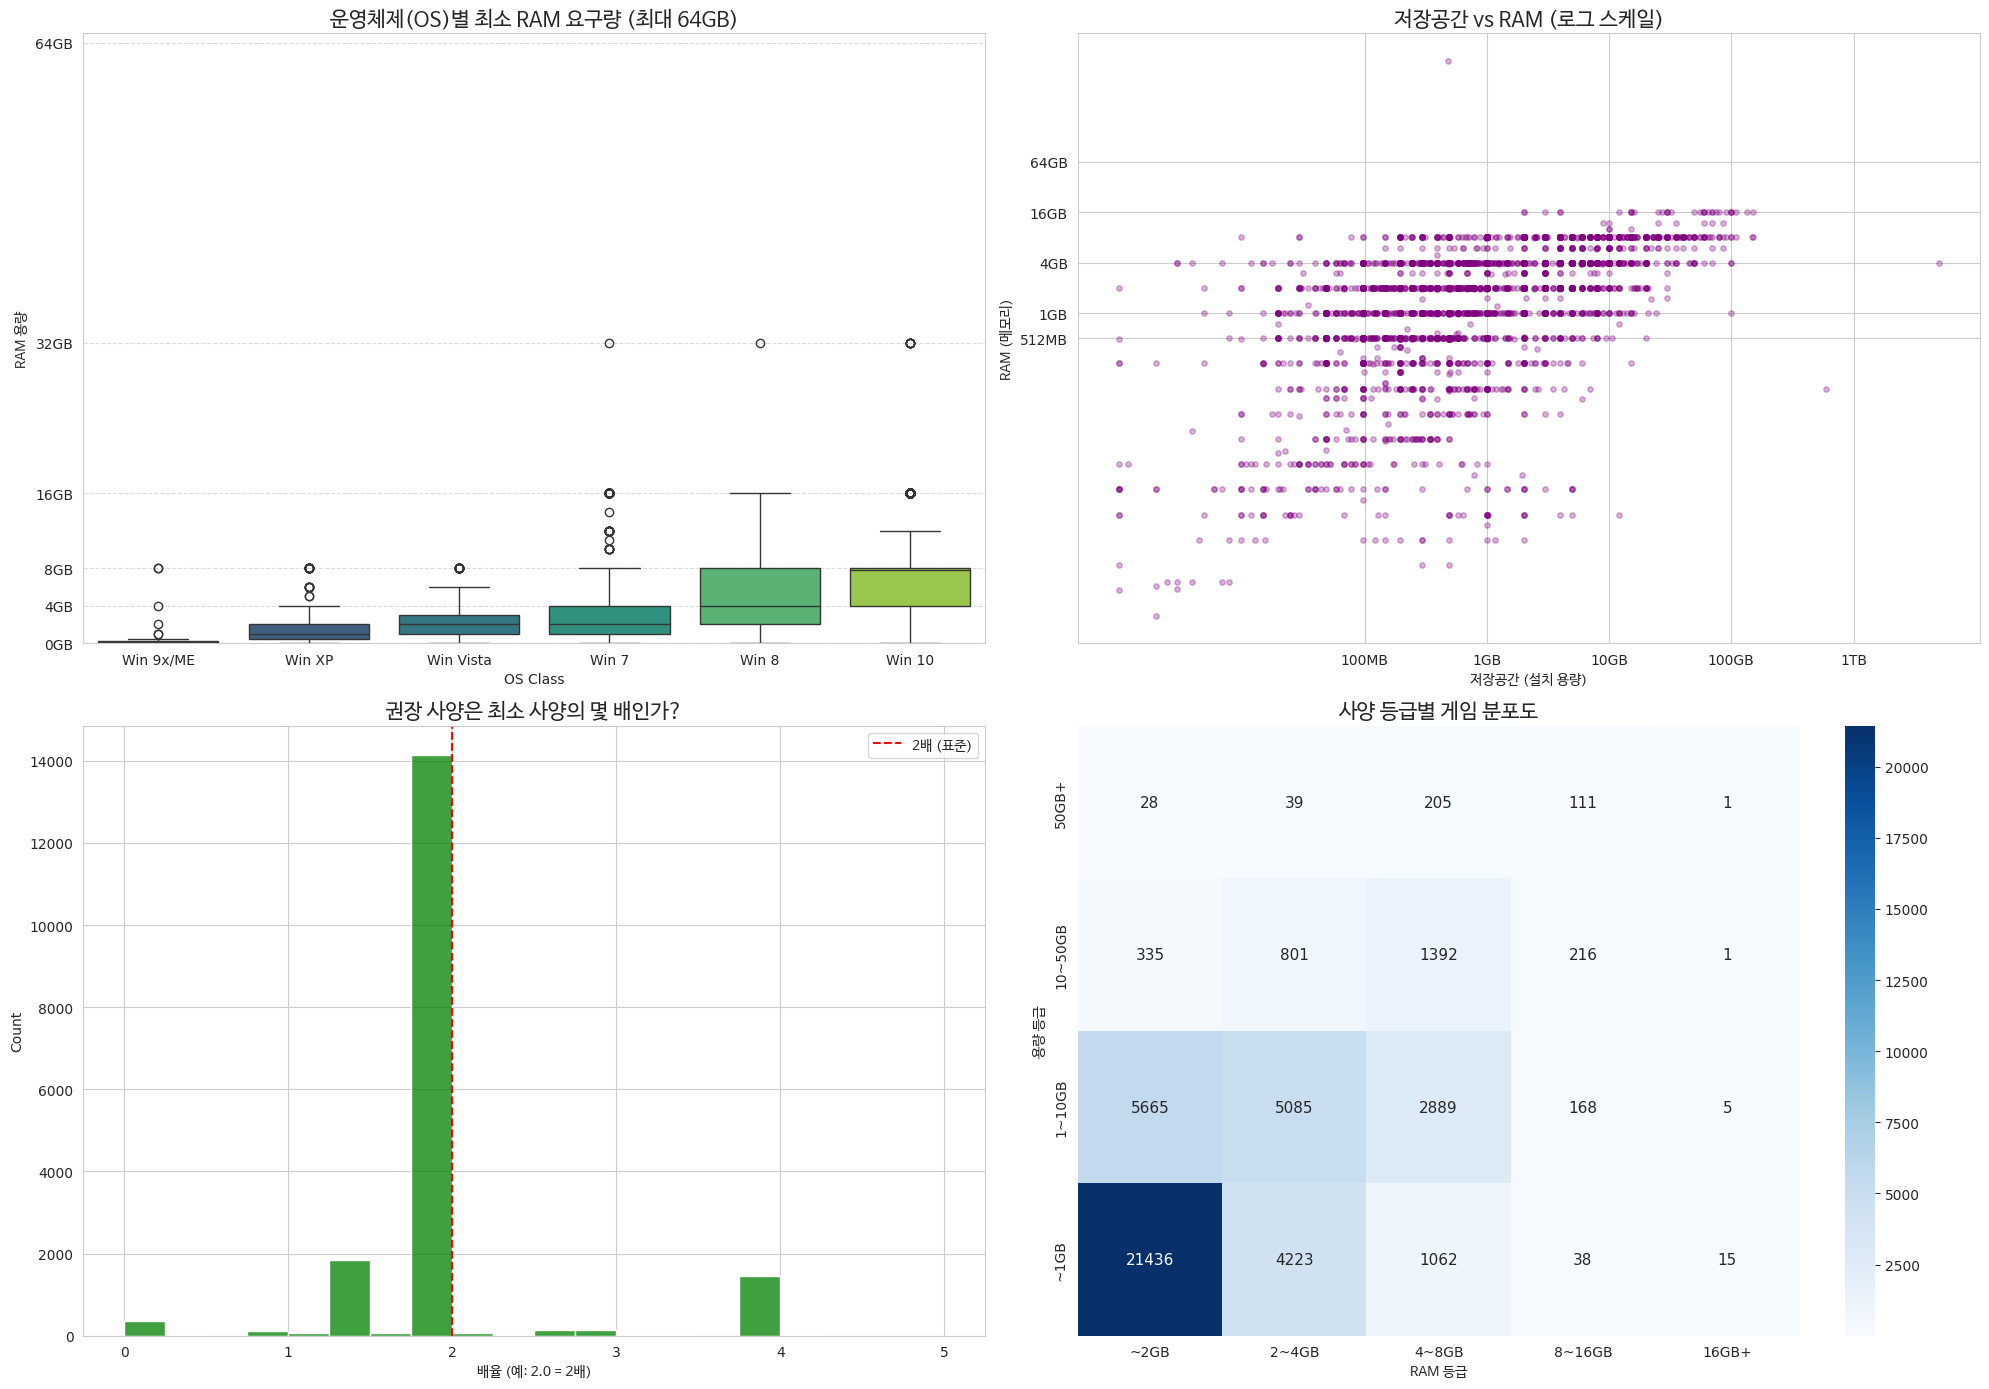

In [9]:
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path, size=10)

# 전역 폰트 설정
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드 및 전처리
filename = "./first_fixed/pc_games_specs_normalized.csv"
try:
    df = pd.read_csv(filename)
except:
    df = pd.DataFrame()

if not df.empty:
    # 단위 변환 (GB 기준)
    def parse_size_to_gb(text):
        if pd.isna(text) or text == "": return None
        text = str(text).upper().replace(",", "")
        match = re.search(r'(\d+(?:\.\d+)?)\s*(TB|GB|MB|KB)', text)
        if match:
            num, unit = float(match.group(1)), match.group(2)
            if unit == 'TB': return num * 1024
            elif unit == 'GB': return num
            elif unit == 'MB': return num / 1024
            elif unit == 'KB': return num / (1024 * 1024)
        return None

    # OS 정규화
    def normalize_os(text):
        if pd.isna(text) or text == "": return "Unknown"
        text = str(text).lower()
        if 'win' in text or 'xp' in text or 'vista' in text or re.search(r'\b(7|8|10)\b', text):
            if any(x in text for x in ['95', '98', 'me']): return "Win 9x/ME"
            if '2000' in text: return "Win 2000"
            if 'xp' in text: return "Win XP"
            if 'vista' in text: return "Win Vista"
            if '7' in text: return "Win 7"
            if '8' in text: return "Win 8"
            if '10' in text: return "Win 10"
            return "Win (기타)"
        return "Other"

    df['RAM (Min) GB'] = df['RAM (Min)'].apply(parse_size_to_gb)
    df['Storage (Min) GB'] = df['Storage (Min)'].apply(parse_size_to_gb)
    df['RAM (Rec) GB'] = df['RAM (Rec)'].apply(parse_size_to_gb)
    df['OS Class'] = df['OS (Min)'].apply(normalize_os)

    # 3. 시각화
    plt.figure(figsize=(20, 14))
    sns.set_style("whitegrid")

    # [1] OS별 RAM 요구량 (Boxplot) - 64GB 확장 & 2의 제곱수 눈금
    os_order = ['Win 9x/ME', 'Win XP', 'Win Vista', 'Win 7', 'Win 8', 'Win 10']
    df_os = df[df['OS Class'].isin(os_order)]

    plt.subplot(2, 2, 1)
    sns.boxplot(data=df_os, x='OS Class', y='RAM (Min) GB', order=os_order, palette='viridis')

    plt.title('운영체제(OS)별 최소 RAM 요구량 (최대 64GB)', fontproperties=font_prop, fontsize=15)
    plt.ylabel('RAM 용량', fontproperties=font_prop)

    # 💡 [핵심] Y축을 0, 4, 8, 16, 32, 64 GB로 설정
    plt.ylim(0, 65)
    major_ticks = [0, 4, 8, 16, 32, 64]
    plt.yticks(major_ticks, [f"{x}GB" for x in major_ticks]) # 단위를 붙여서 표시
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # [2] 저장공간 vs RAM 상관관계 (Scatter)
    plt.subplot(2, 2, 2)
    subset = df.sample(n=min(5000, len(df)), random_state=42)
    plt.scatter(subset['Storage (Min) GB'], subset['RAM (Min) GB'], alpha=0.3, color='purple', s=15)

    plt.xscale('log')
    plt.yscale('log')
    plt.title('저장공간 vs RAM (로그 스케일)', fontproperties=font_prop, fontsize=15)
    plt.xlabel('저장공간 (설치 용량)', fontproperties=font_prop)
    plt.ylabel('RAM (메모리)', fontproperties=font_prop)

    # 축 눈금을 "사람이 보기 쉬운 단위"로 강제 변환
    # X축: 100MB, 1GB, 10GB, 100GB
    x_ticks = [0.1, 1, 10, 100, 1000]
    x_labels = ['100MB', '1GB', '10GB', '100GB', '1TB']
    plt.xticks(x_ticks, x_labels)

    # Y축: 512MB, 1GB, 4GB, 16GB, 64GB
    y_ticks = [0.5, 1, 4, 16, 64]
    y_labels = ['512MB', '1GB', '4GB', '16GB', '64GB']
    plt.yticks(y_ticks, y_labels)


    # [3] 권장/최소 사양 비율 (그대로 유지하되 라벨 개선)
    plt.subplot(2, 2, 3)
    df_gap = df.dropna(subset=['RAM (Min) GB', 'RAM (Rec) GB'])
    df_gap = df_gap[df_gap['RAM (Min) GB'] > 0]
    df_gap['Ratio'] = df_gap['RAM (Rec) GB'] / df_gap['RAM (Min) GB']

    sns.histplot(df_gap[df_gap['Ratio'] <= 5]['Ratio'], bins=20, color='green', kde=False)
    plt.axvline(x=2.0, color='red', linestyle='--', label='2배 (표준)')
    plt.title('권장 사양은 최소 사양의 몇 배인가?', fontproperties=font_prop, fontsize=15)
    plt.xlabel('배율 (예: 2.0 = 2배)', fontproperties=font_prop)
    plt.legend(prop=font_prop)

    # [4] 구간별 게임 분포 (Heatmap) - 라벨 한글화 및 가독성 향상
    plt.subplot(2, 2, 4)

    # 구간 정의
    ram_bins = [0, 2, 4, 8, 16, 1000]
    ram_labels = ['~2GB', '2~4GB', '4~8GB', '8~16GB', '16GB+']

    hd_bins = [0, 1, 10, 50, 10000]
    hd_labels = ['~1GB', '1~10GB', '10~50GB', '50GB+']

    df['RAM Group'] = pd.cut(df['RAM (Min) GB'], bins=ram_bins, labels=ram_labels)
    df['HD Group'] = pd.cut(df['Storage (Min) GB'], bins=hd_bins, labels=hd_labels)

    heatmap_data = pd.crosstab(df['HD Group'], df['RAM Group'])
    heatmap_data = heatmap_data.iloc[::-1] # Y축 뒤집기 (큰 게 위로)

    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 11})
    plt.title('사양 등급별 게임 분포도', fontproperties=font_prop, fontsize=15)
    plt.xlabel('RAM 등급', fontproperties=font_prop)
    plt.ylabel('용량 등급', fontproperties=font_prop)

    plt.tight_layout()
    plt.savefig('games.png')
    plt.show()

else:
    print("CSV 파일이 없습니다.")

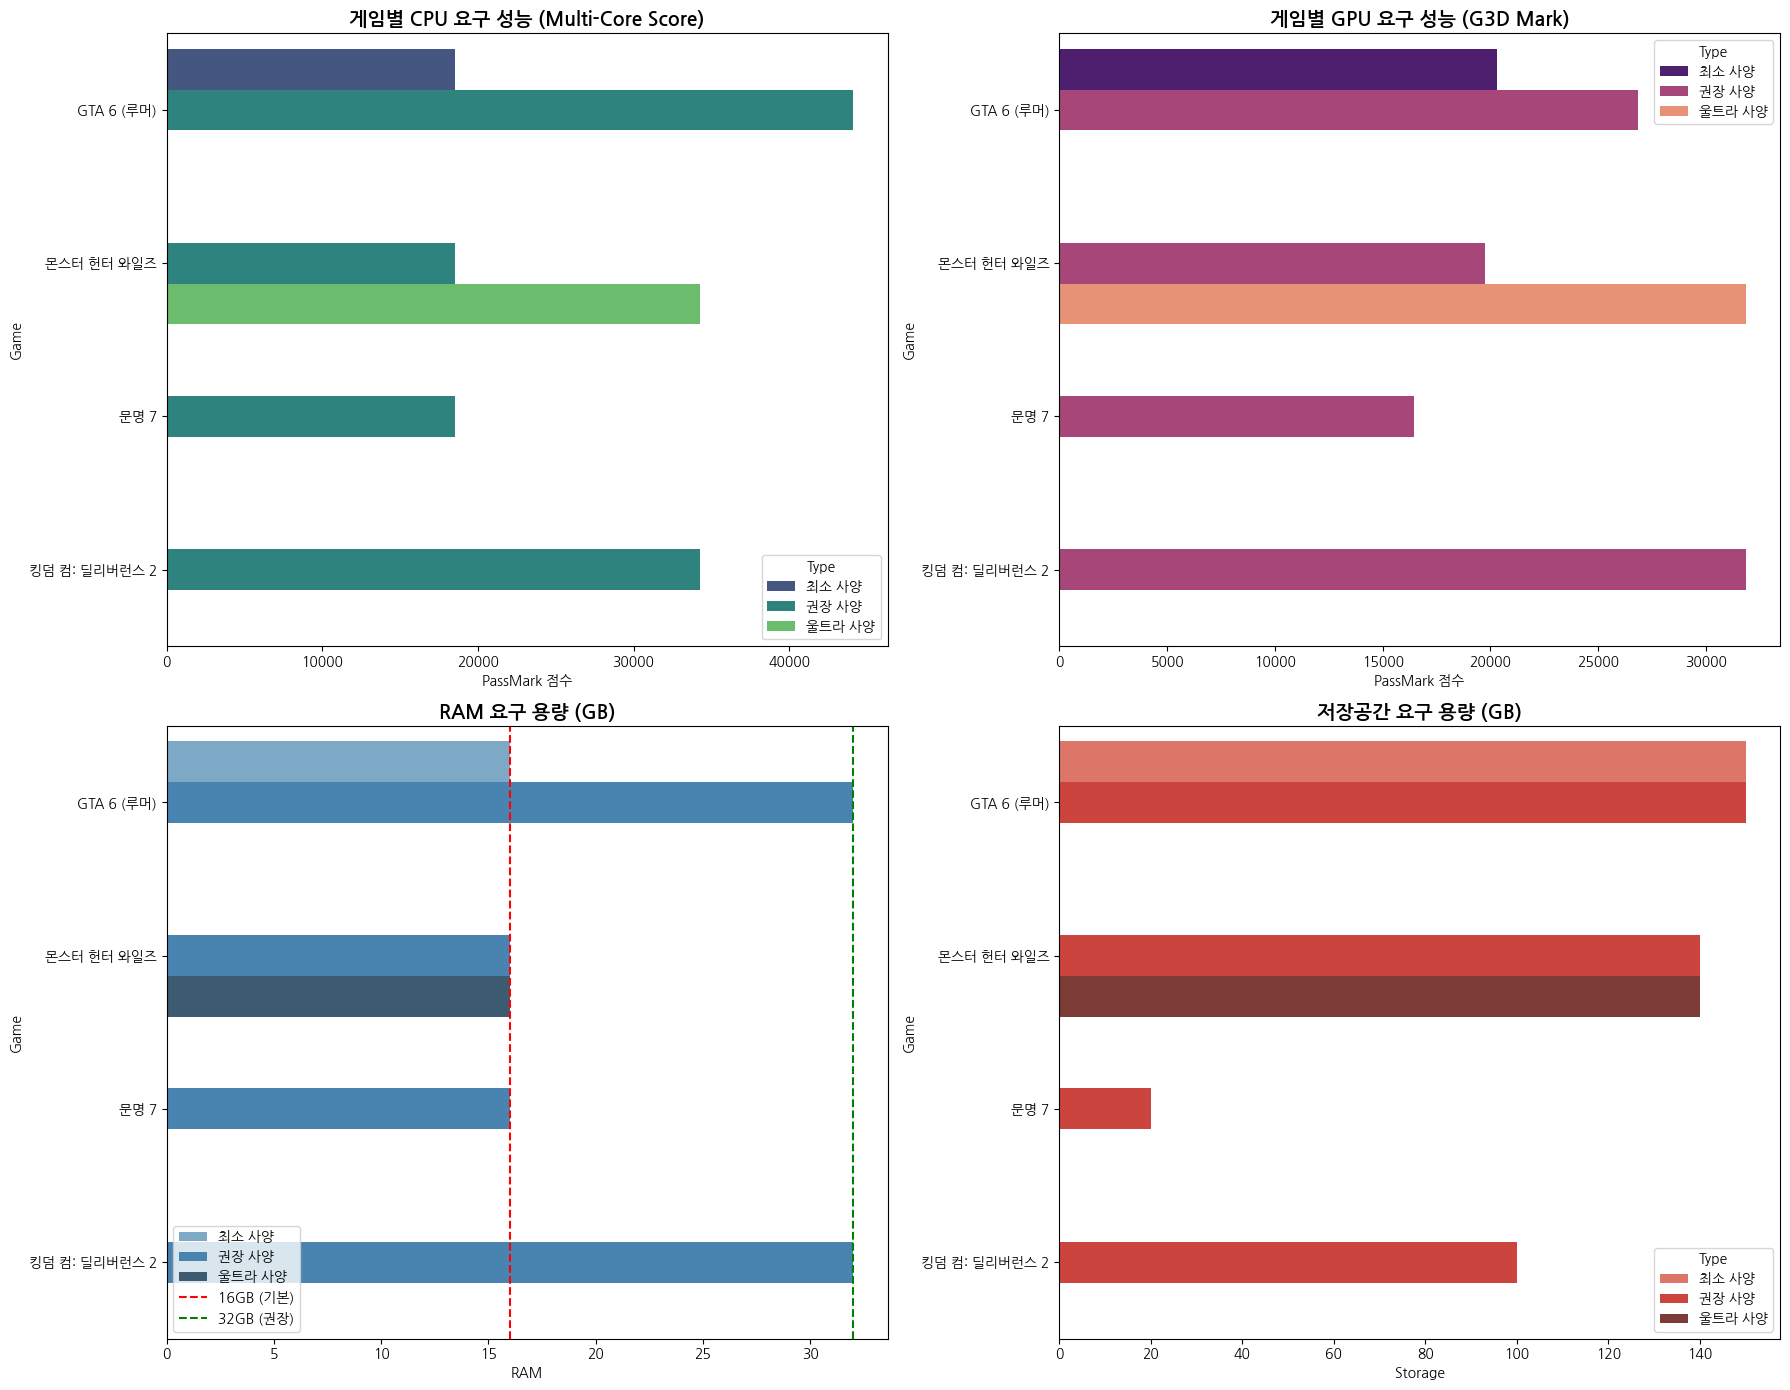


🎮 [2025년 게임 원활 구동을 위한 PC 권장 사양]
✅ 목표 CPU 점수 (Multi): 44,106 점 이상
✅ 목표 GPU 점수 (G3D): 31,829 점 이상
✅ 권장 RAM 용량: 32 GB
✅ 필요 저장공간: 150 GB (NVMe SSD)

[추천 CPU 모델 (목표 성능 충족)]
                Model  Multi_Score MSRP
Intel Core i7 13700KF        45730 $384
 Intel Core i7 13700K        45786 $409
 Intel Core i7 14700K        52216 $409

[추천 GPU 모델 (목표 성능 충족)]
                           Model  G3D_Score
NVIDIA GeForce RTX 4070 Ti Super      31829
      NVIDIA GeForce RTX 5070 Ti      32545
   NVIDIA GeForce RTX 4080 Super      34221


In [6]:
file_cpu = "CPU_Data.csv"
file_gpu = "GPU_Data.csv"

def load_hardware_data(file_cpu, file_gpu):
    if not os.path.exists(file_cpu) or not os.path.exists(file_gpu):
        print("❌ 데이터 파일이 없습니다. (CPU_Data.csv, GPU_Data.csv)")
        return pd.DataFrame(), pd.DataFrame()

    df_cpu = pd.read_csv(file_cpu)
    df_gpu = pd.read_csv(file_gpu)
    return df_cpu, df_gpu

df_cpu, df_gpu = load_hardware_data(file_cpu, file_gpu)

# ---------------------------------------------------------
# [3] 게임별 요구 사양 데이터 정의 (2025 기대작)
# ---------------------------------------------------------
# 루머 및 공개된 권장 사양 기반
games_data = [
    {
        "Game": "GTA 6 (루머)",
        "Type": "최소 사양",
        "CPU_Model": ["Core i5-9600K", "Ryzen 5 3600"],
        "GPU_Model": ["RTX 3060", "RX 6600 XT"],
        "RAM": 16, "Storage": 150
    },
    {
        "Game": "GTA 6 (루머)",
        "Type": "권장 사양",
        "CPU_Model": ["Core i9-10900K", "Ryzen 9 5900X"],
        "GPU_Model": ["RTX 3080", "RX 6800 XT"],
        "RAM": 32, "Storage": 150
    },
    {
        "Game": "몬스터 헌터 와일즈",
        "Type": "권장 사양",
        "CPU_Model": ["Core i5-11600K", "Ryzen 5 3600X"],
        "GPU_Model": ["RTX 2070 Super", "RX 6700 XT"],
        "RAM": 16, "Storage": 140
    },
    {
        "Game": "몬스터 헌터 와일즈",
        "Type": "울트라 사양",
        "CPU_Model": ["Core i7-13700K", "Ryzen 7 7800X3D"],
        "GPU_Model": ["RTX 4070", "RX 7800 XT"],
        "RAM": 16, "Storage": 140
    },
    {
        "Game": "문명 7",
        "Type": "권장 사양",
        "CPU_Model": ["Core i5-10400", "Ryzen 5 3600X"],
        "GPU_Model": ["RTX 2060", "RX 6600"],
        "RAM": 16, "Storage": 20
    },
    {
        "Game": "킹덤 컴: 딜리버런스 2",
        "Type": "권장 사양",
        "CPU_Model": ["Core i7-13700K", "Ryzen 7 7800X3D"],
        "GPU_Model": ["RTX 4070", "RX 7800 XT"],
        "RAM": 32, "Storage": 100
    }
]

# ---------------------------------------------------------
# [4] 요구 사양 점수 매칭 (데이터셋에서 점수 찾기)
# ---------------------------------------------------------
def get_max_score(models, df, score_col, name_col):
    scores = []
    for model in models:
        # 검색 정확도를 위해 브랜드명 제거 ("Core i5-9600K" -> "i5-9600K")
        clean_model = model.replace("Core ", "").replace("Ryzen ", "").replace("GeForce ", "").replace("Radeon ", "")

        # 포함 검색 (contains)
        match = df[df[name_col].str.contains(clean_model, case=False, regex=False)]
        if not match.empty:
            scores.append(match[score_col].max())

    return max(scores) if scores else None

analysis_results = []

for game in games_data:
    cpu_score = get_max_score(game['CPU_Model'], df_cpu, 'Multi_Score', 'Model')
    gpu_score = get_max_score(game['GPU_Model'], df_gpu, 'G3D_Score', 'Model')

    if cpu_score and gpu_score:
        analysis_results.append({
            "Game": game['Game'],
            "Type": game['Type'],
            "CPU_Score": cpu_score,
            "GPU_Score": gpu_score,
            "RAM": game['RAM'],
            "Storage": game['Storage']
        })

df_reqs = pd.DataFrame(analysis_results)

# ---------------------------------------------------------
# [5] 시각화 및 목표 사양 도출
# ---------------------------------------------------------
if not df_reqs.empty:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # [1] CPU 요구 점수
    sns.barplot(data=df_reqs, y='Game', x='CPU_Score', hue='Type', ax=axes[0, 0], palette='viridis')
    axes[0, 0].set_title('게임별 CPU 요구 성능 (Multi-Core Score)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('PassMark 점수')

    # [2] GPU 요구 점수
    sns.barplot(data=df_reqs, y='Game', x='GPU_Score', hue='Type', ax=axes[0, 1], palette='magma')
    axes[0, 1].set_title('게임별 GPU 요구 성능 (G3D Mark)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('PassMark 점수')

    # [3] RAM 용량
    sns.barplot(data=df_reqs, y='Game', x='RAM', hue='Type', ax=axes[1, 0], palette='Blues_d')
    axes[1, 0].set_title('RAM 요구 용량 (GB)', fontsize=14, fontweight='bold')
    axes[1, 0].axvline(16, color='red', linestyle='--', label='16GB (기본)')
    axes[1, 0].axvline(32, color='green', linestyle='--', label='32GB (권장)')
    axes[1, 0].legend()

    # [4] 저장공간
    sns.barplot(data=df_reqs, y='Game', x='Storage', hue='Type', ax=axes[1, 1], palette='Reds_d')
    axes[1, 1].set_title('저장공간 요구 용량 (GB)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('game_requirements.png')
    plt.show() # 이미지 출력

    # --- [결과 분석: 목표 사양 산출] ---
    # 권장/울트라 사양 중 최댓값을 목표치로 설정
    rec_filter = df_reqs[df_reqs['Type'].isin(['권장 사양', '울트라 사양'])]

    target_cpu = rec_filter['CPU_Score'].max()
    target_gpu = rec_filter['GPU_Score'].max()
    target_ram = rec_filter['RAM'].max()
    target_storage = df_reqs['Storage'].max()

    print("\n" + "="*50)
    print("🎮 [2025년 게임 원활 구동을 위한 PC 권장 사양]")
    print("="*50)
    print(f"✅ 목표 CPU 점수 (Multi): {int(target_cpu):,} 점 이상")
    print(f"✅ 목표 GPU 점수 (G3D): {int(target_gpu):,} 점 이상")
    print(f"✅ 권장 RAM 용량: {int(target_ram)} GB")
    print(f"✅ 필요 저장공간: {int(target_storage)} GB (NVMe SSD)")

    # --- [데이터셋 기반 모델 추천] ---
    # 목표 점수 이상인 모델 중 가성비/인기 모델 추출
    rec_cpus = df_cpu[(df_cpu['Multi_Score'] >= target_cpu) & (df_cpu['Model'].str.contains('Core i7|Ryzen 7'))].sort_values('Multi_Score').head(3)
    rec_gpus = df_gpu[(df_gpu['G3D_Score'] >= target_gpu) & (df_gpu['Model'].str.contains('RTX 40|RTX 50|RX 7'))].sort_values('G3D_Score').head(3)

    print("\n[추천 CPU 모델 (목표 성능 충족)]")
    print(rec_cpus[['Model', 'Multi_Score', 'MSRP']].to_string(index=False))

    print("\n[추천 GPU 모델 (목표 성능 충족)]")
    print(rec_gpus[['Model', 'G3D_Score']].to_string(index=False))

else:
    print("❌ 매칭된 게임 데이터가 없습니다.")